In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import sklearn.decomposition
from collections import defaultdict
from scipy.stats import pearsonr
import seaborn as sn


In [2]:
basket = pd.read_csv('../Dataset/baskets_supermarket.csv', skipinitialspace=True, sep=',',index_col=0)
cat = pd.read_csv('../Dataset/item_categories.csv', skipinitialspace=True, sep=',')
items = pd.read_csv('../Dataset/items.csv', skipinitialspace=True, sep=',')

all = basket.reset_index().merge(items, on='item_id', how="left").set_index('index')
all = all.reset_index().merge(cat, on='item_category_id', how="left").set_index('index')

In [3]:
all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 504087 entries, 32632 to 1263632
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                352861 non-null  object 
 1   shop_id             469023 non-null  float64
 2   item_id             405085 non-null  float64
 3   item_price          451795 non-null  float64
 4   item_cnt_day        497039 non-null  float64
 5   user_id             433351 non-null  float64
 6   basket_id           437967 non-null  object 
 7   item_name           405085 non-null  object 
 8   item_category_id    405085 non-null  float64
 9   item_category_name  405085 non-null  object 
dtypes: float64(6), object(4)
memory usage: 42.3+ MB


#**a) First overview of the dataset**

##**Dataset description**
The data for this project consists of purchases made in various stores in Russia, it also contains information about the items stored and their categories. There are three different datasets:

**Category**

Possible categories to which items can belong

*   *item_category_name*:  category's name.
*   *item_category_id*: category's identifier.


**Items**

Items belonging to different shops

*   *item_name*: item's name.
*   *item_id*: item's identifier.
*   *item_category_id*: category's id of the item.


**Basket**

Every row represents a purchase of an item by an user

*   *date*: Date of the purchase
*   *shop_id*: Identifier of the shop from which the purchase was made
*   *item_id*: Identifier of the item bought
*   *item_price*: Cost of the item (in Rubles) 
*   *item_cnt_day*: Number of items purchased in a single shopping session
*   *user_id*: Identifier of the user who purchased the item
*   *basket_id*: identifier of the basket of the shopping session



In [4]:
basket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504087 entries, 32632 to 1263632
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          352861 non-null  object 
 1   shop_id       469023 non-null  float64
 2   item_id       405085 non-null  float64
 3   item_price    451795 non-null  float64
 4   item_cnt_day  497039 non-null  float64
 5   user_id       433351 non-null  float64
 6   basket_id     437967 non-null  object 
dtypes: float64(5), object(2)
memory usage: 30.8+ MB


In [5]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [7]:
basket

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
32632,NaN,2.0,NaN,249.0,1.0,1.0,B11
33487,01.01.2013,2.0,20424.0,NaN,1.0,1.0,B11
32099,01.01.2013,2.0,6916.0,999.5,1.0,1.0,B11
33529,01.01.2013,2.0,19718.0,149.0,1.0,1.0,B11
31974,NaN,2.0,11828.0,1699.0,1.0,1.0,B11
...,...,...,...,...,...,...,...
1263642,06.12.2013,46.0,18698.0,199.0,1.0,809.0,B8636824
1263638,06.12.2013,46.0,18701.0,199.0,1.0,809.0,B8636824
1266426,06.12.2013,46.0,1511.0,799.0,1.0,809.0,B8636824
1263258,NaN,46.0,16159.0,629.0,1.0,809.0,B8636824


In [8]:
basket.groupby('basket_id').count().mean()

date             8.576131
shop_id         11.401522
item_id          9.846423
item_price      10.980114
item_cnt_day    12.078732
user_id         10.528109
dtype: float64

##**Null value distribution**

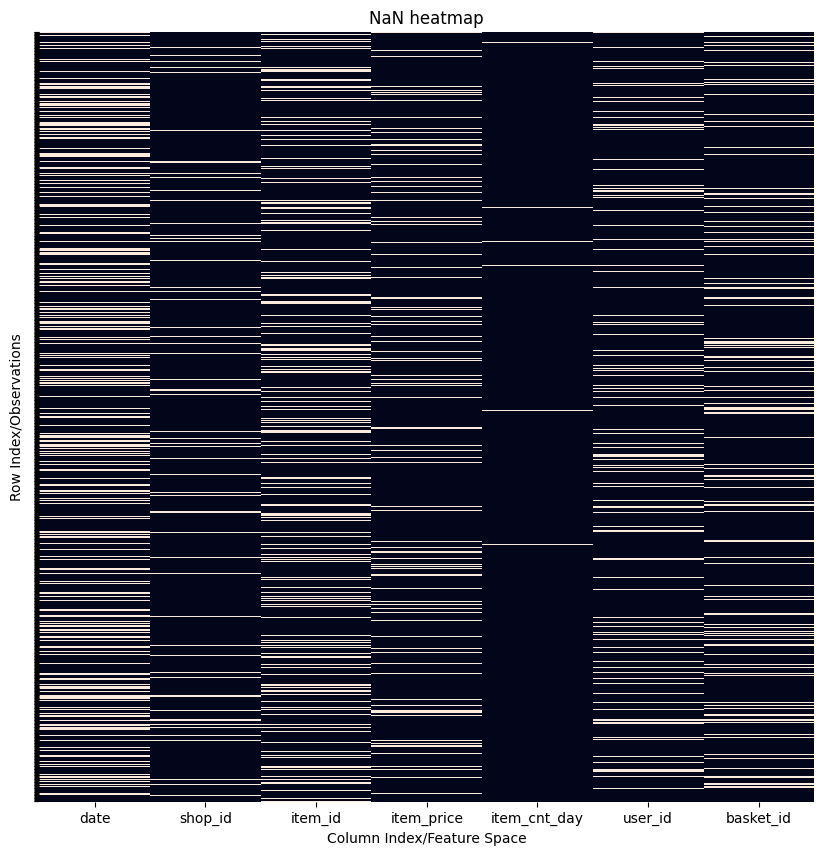

In [9]:
#set figure size
plt.figure(figsize=(10,10))

#generate heatmap
sn.heatmap(basket.isnull(), cbar=False)

#labels and titles
plt.title("NaN heatmap")
plt.yticks(np.arange(0, basket.shape[0], 500))
plt.xlabel("Column Index/Feature Space")
plt.ylabel("Row Index/Observations")

plt.show()

Percentage of null values

In [10]:
basket.isnull().sum()/504087*100


date            29.999980
shop_id          6.955942
item_id         19.639864
item_price      10.373606
item_cnt_day     1.398171
user_id         14.032498
basket_id       13.116783
dtype: float64

In [11]:
cat.isnull().any()

item_category_name    False
item_category_id      False
dtype: bool

In [12]:
items.isnull().any()

item_name           False
item_id             False
item_category_id    False
dtype: bool

We will drop rows with 6 null values or having all ids null

In [13]:
#drop later
basket[basket.isnull().sum(axis=1) == 6]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
457954,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2792963,NaN,NaN,NaN,NaN,1.0,NaN,NaN
51720,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2075732,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2629952,NaN,NaN,NaN,NaN,1.0,NaN,NaN
810831,NaN,28.0,NaN,NaN,NaN,NaN,NaN


In [14]:
#keep, maybe we can fill
basket[basket.isnull().sum(axis=1) == 5]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
54677,NaN,NaN,NaN,NaN,1.0,NaN,B525
35477,NaN,7.0,NaN,NaN,1.0,NaN,NaN
1341497,01.01.2014,NaN,NaN,NaN,1.0,NaN,NaN
1306667,NaN,NaN,NaN,1399.0,1.0,NaN,NaN
1378323,NaN,26.0,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...
2807570,NaN,NaN,NaN,299.0,1.0,NaN,NaN
2828804,NaN,NaN,NaN,1449.0,1.0,NaN,NaN
1985045,NaN,NaN,NaN,NaN,1.0,790.0,NaN
975788,NaN,NaN,NaN,NaN,1.0,NaN,B8635916


In [15]:
#drop later
basket[ (basket.shop_id.isna()) & (basket.item_id.isna()) & (basket.user_id.isna()) & (basket.basket_id.isna())]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
7766,01.01.2013,NaN,NaN,79.0,2.0,NaN,NaN
1341497,01.01.2014,NaN,NaN,NaN,1.0,NaN,NaN
1306667,NaN,NaN,NaN,1399.0,1.0,NaN,NaN
120071,01.02.2013,NaN,NaN,349.0,1.0,NaN,NaN
272660,NaN,NaN,NaN,434.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...
2805990,06.08.2015,NaN,NaN,79.0,1.0,NaN,NaN
2807570,NaN,NaN,NaN,299.0,1.0,NaN,NaN
2828804,NaN,NaN,NaN,1449.0,1.0,NaN,NaN
2149875,NaN,NaN,NaN,899.0,2.0,NaN,NaN


## **Data Distribution**

array([[<AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>],
       [<AxesSubplot:title={'center':'user_id'}>, <AxesSubplot:>]],
      dtype=object)

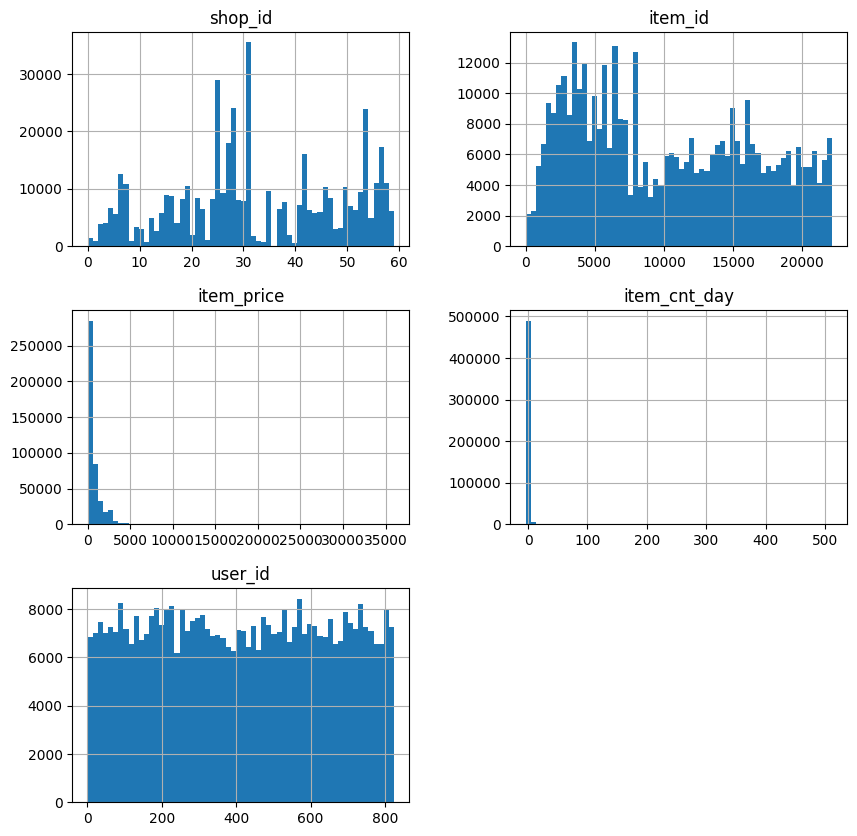

In [16]:
basket.hist(figsize = (10,10), bins=60)

In [17]:
basket.describe()

,shop_id,item_id,item_price,item_cnt_day,user_id
count,469023.000000,405085.000000,451795.000000,497039.000000,433351.000000
mean,32.696322,10216.814306,871.297822,1.241623,411.705091
std,16.228241,6331.294031,1660.772383,1.785192,238.033542
min,0.000000,0.000000,0.100000,-4.000000,1.000000
25%,21.000000,4477.000000,249.000000,1.000000,205.000000
50%,31.000000,9355.000000,399.000000,1.000000,412.000000
75%,47.000000,15702.000000,999.000000,1.000000,618.000000
max,59.000000,22168.000000,35990.000000,512.000000,824.000000


## **Correlation**

No correlation found in the basket dataset

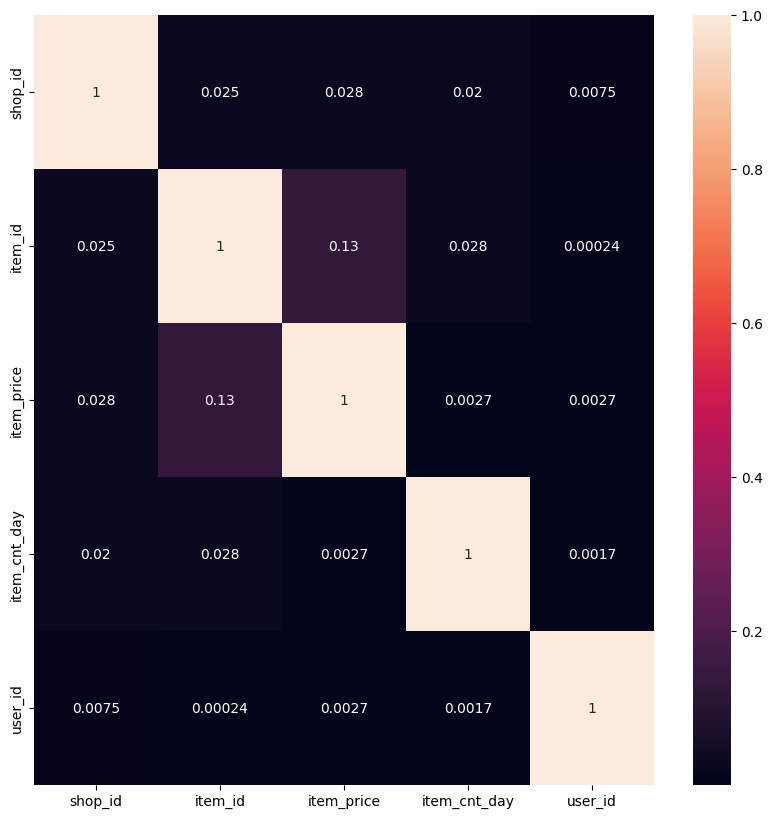

In [18]:
corr_matrix = basket.corr()
plt.figure(figsize=(10,10))
sn.heatmap(abs(corr_matrix), annot=True)
plt.show()

## **Null value distribution among users**
We check how "complete" is every user, counting the number of null values for every user in the dataset basket

In [19]:
# For every user we calculate the number of occurences in the basket dataframe (i.e the number of purchasing)
total_sum = basket.groupby('user_id').size().reset_index(name='total')
total_sum.shape

(824, 2)

In [20]:
total_sum

,user_id,total
0,1.0,571
1,2.0,678
2,3.0,321
3,4.0,680
4,5.0,618
...,...,...
819,820.0,600
820,821.0,494
821,822.0,514
822,823.0,510


<AxesSubplot:>

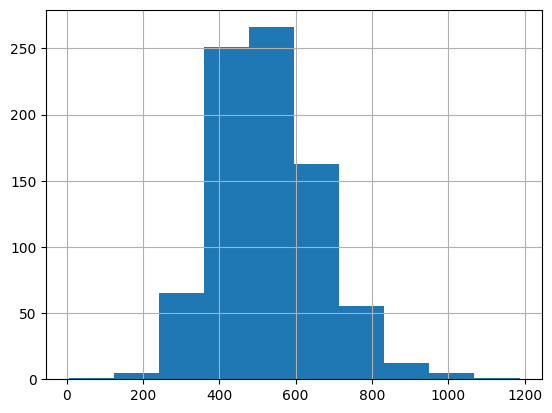

In [21]:
total_sum['total'].hist()

For every user and for every attribute we calculate the number of not null values

In [22]:
#For every user and for every attribute we calculate the number of not null values

date_valid = basket.date.notnull().groupby(basket['user_id']).sum().astype(int).reset_index(name='date_valid')
shop_id_valid = basket.shop_id.notnull().groupby(basket['user_id']).sum().astype(int).reset_index(name='shop_id_valid')
item_id_valid = basket.item_id.notnull().groupby(basket['user_id']).sum().astype(int).reset_index(name='item_id_valid')
item_price_valid = basket.item_price.notnull().groupby(basket['user_id']).sum().astype(int).reset_index(name='item_price_valid')
item_cnt_day_valid = basket.item_cnt_day.notnull().groupby(basket['user_id']).sum().astype(int).reset_index(name='item_cnt_day_valid')
basket_id_valid = basket.basket_id.notnull().groupby(basket['user_id']).sum().astype(int).reset_index(name='basket_id_valid')


In [23]:
#Percentage

# date_valid ratio
ratio = pd.merge(total_sum, date_valid, on='user_id')
ratio['date_valid'] = ratio['date_valid']/ratio['total']*100
ratio.rename(columns = {'date_valid': 'date_valid_ratio'}, inplace = True)

# shop_id_valid ratio
ratio = pd.merge(ratio, shop_id_valid, on='user_id')
ratio['shop_id_valid'] = ratio['shop_id_valid']/ratio['total']*100
ratio.rename(columns = {'shop_id_valid': 'shop_id_valid_ratio'}, inplace = True)

# item_id_valid ratio
ratio = pd.merge(ratio, item_id_valid, on='user_id')
ratio['item_id_valid'] = ratio['item_id_valid']/ratio['total']*100
ratio.rename(columns = {'item_id_valid': 'item_id_valid_ratio'}, inplace = True)

# item_price_valid ratio
ratio = pd.merge(ratio, item_price_valid, on='user_id')
ratio['item_price_valid'] = ratio['item_price_valid']/ratio['total']*100
ratio.rename(columns = {'item_price_valid': 'item_price_valid_ratio'}, inplace = True)

# item_cnt_day_valid ratio
ratio = pd.merge(ratio, item_cnt_day_valid, on='user_id')
ratio['item_cnt_day_valid'] = ratio['item_cnt_day_valid']/ratio['total']*100
ratio.rename(columns = {'item_cnt_day_valid': 'item_cnt_day_valid_ratio'}, inplace = True)

# basket_id_valid ratio
ratio = pd.merge(ratio, basket_id_valid, on='user_id')
ratio['basket_id_valid'] = ratio['basket_id_valid']/ratio['total']*100
ratio.rename(columns = {'basket_id_valid': 'basket_id_valid_ratio'}, inplace = True)


# 0 < ratio < 100
# 100 = no null 
# 0 = all null

In [24]:
# Total completeness of a user calculated as the sum of all values on the total
ratio['completeness'] = ratio['date_valid_ratio'] + ratio['shop_id_valid_ratio'] + ratio['item_id_valid_ratio'] +\
 ratio['item_price_valid_ratio'] + ratio['item_cnt_day_valid_ratio'] + ratio['basket_id_valid_ratio']
num_attributes = 6
ratio['completeness'] = ratio['completeness']/num_attributes

In [25]:
# rounding results
ratio.loc[:, ratio.columns != 'user_id'] = ratio.loc[:, ratio.columns != 'user_id'].round(2)
ratio

,user_id,total,date_valid_ratio,shop_id_valid_ratio,item_id_valid_ratio,item_price_valid_ratio,item_cnt_day_valid_ratio,basket_id_valid_ratio,completeness
0,1.0,571,66.37,94.05,77.93,91.24,98.95,89.67,86.37
1,2.0,678,70.35,92.04,79.79,88.35,98.23,86.58,85.89
2,3.0,321,70.72,91.59,79.75,91.59,97.20,85.67,86.09
3,4.0,680,69.12,93.38,80.74,90.59,99.56,87.21,86.76
4,5.0,618,69.74,92.23,79.45,88.03,99.19,87.06,85.95
...,...,...,...,...,...,...,...,...,...
819,820.0,600,68.67,94.50,81.83,89.50,97.83,85.67,86.33
820,821.0,494,71.66,94.33,80.36,89.47,98.99,86.44,86.88
821,822.0,514,71.79,94.55,79.77,87.35,98.83,83.46,85.96
822,823.0,510,71.57,92.55,81.96,89.02,98.43,87.45,86.83


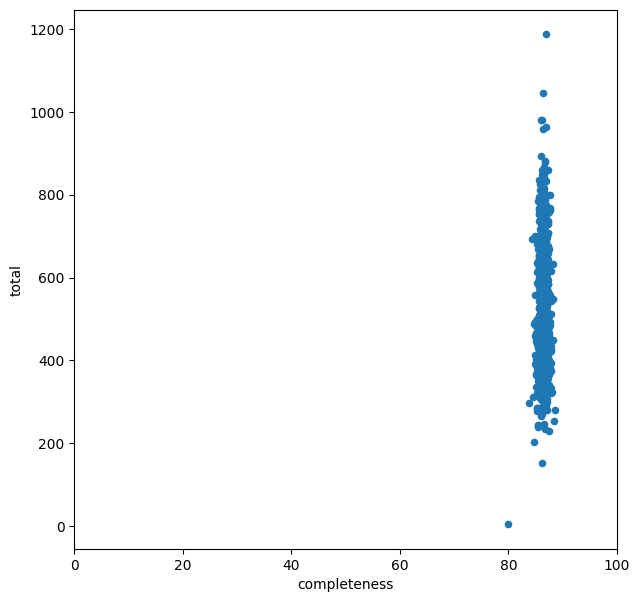

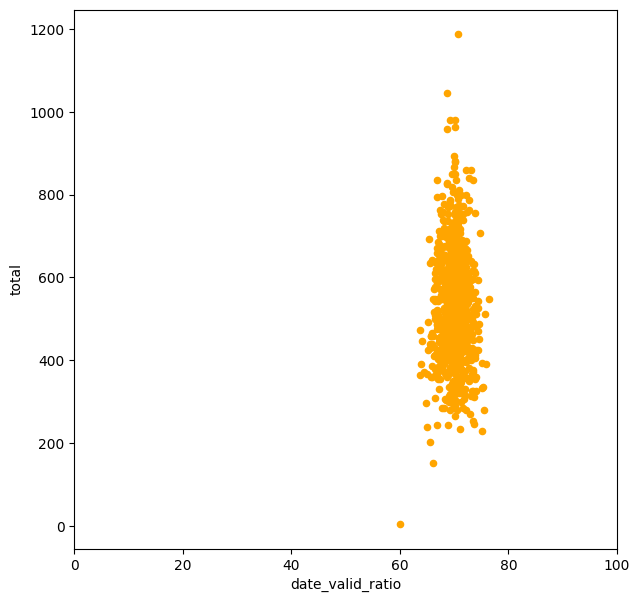

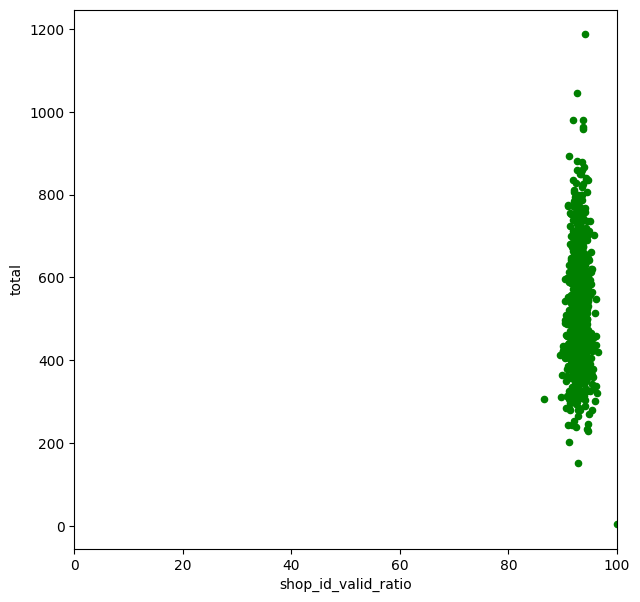

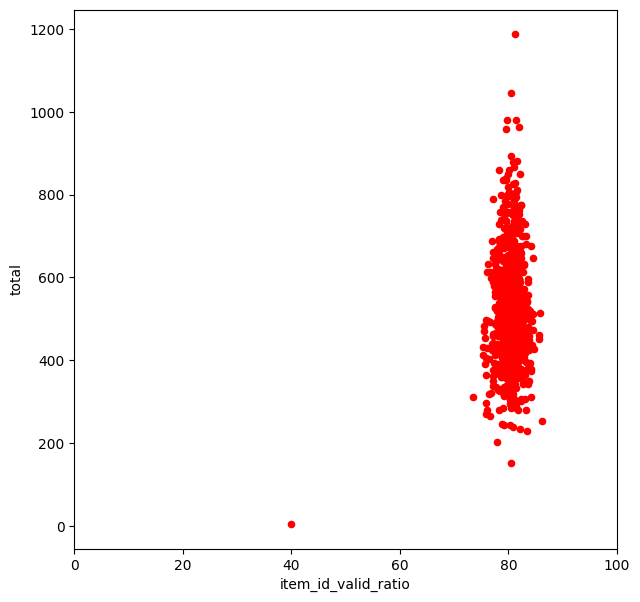

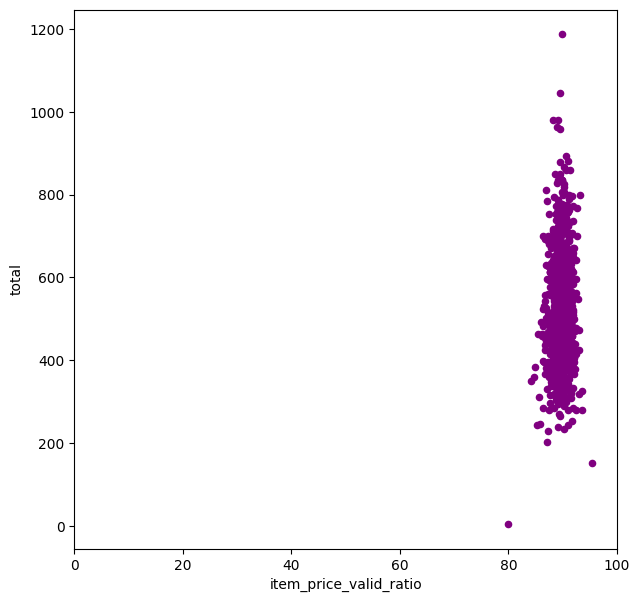

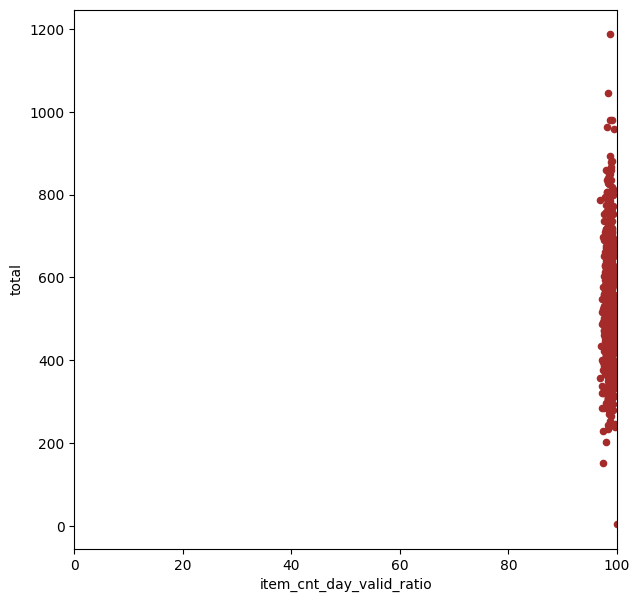

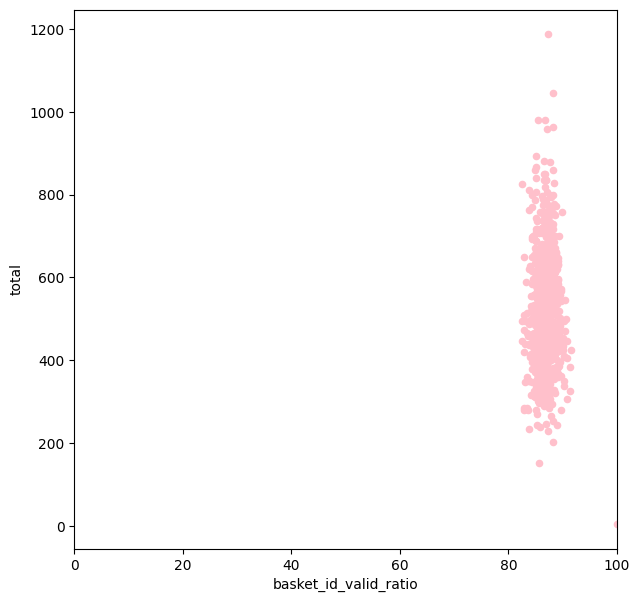

In [26]:
ratio2=ratio.drop('user_id', axis=1)
ratio2['total']=ratio['total']

ratio2.plot.scatter(x='completeness',y='total', figsize = (7, 7))
plt.xlim(0,100)
ratio2.plot.scatter(x='date_valid_ratio',y='total', c='orange', figsize =  (7, 7))
plt.xlim(0,100)
ratio2.plot.scatter(x='shop_id_valid_ratio',y='total', c='green', figsize =  (7, 7))
plt.xlim(0,100)
ratio2.plot.scatter(x='item_id_valid_ratio',y='total', c='Red', figsize =  (7, 7))
plt.xlim(0,100)
ratio2.plot.scatter(x='item_price_valid_ratio',y='total', c='purple', figsize =  (7, 7))
plt.xlim(0,100)
ratio2.plot.scatter(x='item_cnt_day_valid_ratio',y='total', c='brown', figsize =  (7, 7))
plt.xlim(0,100)
ratio2.plot.scatter(x='basket_id_valid_ratio',y='total', c='pink', figsize =  (7, 7))
plt.xlim(0,100)

plt.show()

<AxesSubplot:>

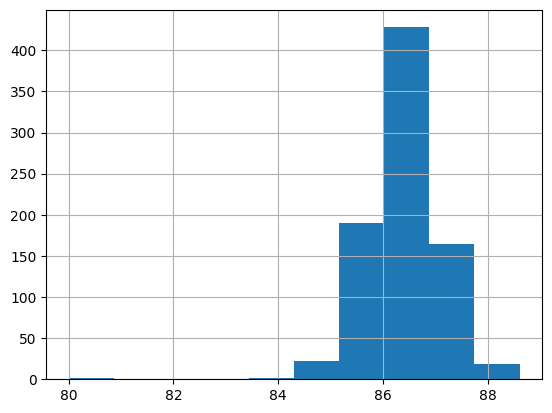

In [27]:
ratio2.completeness.hist()

In [28]:
ratio2.describe()

,total,date_valid_ratio,shop_id_valid_ratio,item_id_valid_ratio,item_price_valid_ratio,item_cnt_day_valid_ratio,basket_id_valid_ratio,completeness
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000
mean,525.911408,70.009551,93.042439,80.328762,89.609709,98.610765,86.879587,86.413422
std,136.337880,2.062987,1.163189,2.277513,1.456682,0.513962,1.594932,0.664955
min,5.000000,60.000000,86.600000,40.000000,80.000000,96.930000,82.550000,80.000000
25%,433.500000,68.735000,92.290000,79.277500,88.720000,98.280000,85.870000,86.000000
50%,509.000000,70.100000,93.025000,80.370000,89.660000,98.630000,86.930000,86.410000
75%,612.000000,71.295000,93.750000,81.602500,90.570000,98.972500,87.900000,86.840000
max,1187.000000,76.500000,100.000000,86.170000,95.420000,100.000000,100.000000,88.610000


In [29]:
ratio2['completeness'].describe()

count    824.000000
mean      86.413422
std        0.664955
min       80.000000
25%       86.000000
50%       86.410000
75%       86.840000
max       88.610000
Name: completeness, dtype: float64

**Conclusions:**
As we can see all the users have at least 80% of valid values (completeness).

The important thing is that there aren't points with low values of completeness and high number of total purchases.

#b) **Data validation**


## **Duplicated check**

In [30]:
notnull = basket.dropna()

In [31]:
ndupl=notnull.duplicated()
ndupl=notnull[ndupl]
ndupl

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id


We check if there are basket id with the same item id associated, we suppose that for a single shopping session only one item id is allowed, if have been purchased multiple items then item_cnt_day must be > 1, but the item id can't be repeated

In [32]:
basket[ (basket.duplicated(subset=['basket_id','item_id',])) & (basket.item_id.notnull()) & (basket.basket_id.notnull())]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id


Duplicated are present only when NaN values are included, we will have to substitute them later

In [33]:
ndupl=basket.duplicated()
ndupl=basket[ndupl]
ndupl

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
55107,01.01.2013,7.0,NaN,299.0,1.0,7.0,B127
52861,01.01.2013,8.0,NaN,NaN,1.0,9.0,NaN
58036,01.01.2013,14.0,NaN,149.0,1.0,17.0,B5217
48316,NaN,15.0,NaN,149.0,1.0,22.0,B7422
49644,01.01.2013,18.0,NaN,NaN,1.0,25.0,B5225
...,...,...,...,...,...,...,...
1241829,06.12.2013,7.0,NaN,199.0,1.0,571.0,B5236785
1246121,NaN,7.0,NaN,149.0,1.0,571.0,NaN
1246478,NaN,31.0,NaN,999.0,1.0,NaN,NaN
1239778,NaN,38.0,NaN,1999.0,1.0,22.0,B8236798


## **Unique Values**
We verify that every category and category id is unique.

We verify that every item and item id is unique.

We verify that for each basket id are not associated different users id, different dates or shop ids.

In [34]:
items[items.duplicated(subset=['item_name'])]

,item_name,item_id,item_category_id


In [35]:
items[items.duplicated(subset=['item_id'])]

,item_name,item_id,item_category_id


In [36]:
cat[cat.duplicated(subset=['item_category_name'])]

,item_category_name,item_category_id


In [37]:
cat[cat.duplicated(subset=['item_category_id'])]

,item_category_name,item_category_id


In [38]:
cat.value_counts()

item_category_name                 item_category_id
PC - Гарнитуры/Наушники            0                   1
Книги - Художественная литература  53                  1
Подарки - Атрибутика               61                  1
Музыка - Подарочные издания        60                  1
Музыка - Музыкальное видео         59                  1
                                                      ..
Игры Android - Цифра               26                  1
Игры - Аксессуары для игр          25                  1
Игры - XBOX ONE                    24                  1
Игры - XBOX 360                    23                  1
Элементы питания                   83                  1
Length: 84, dtype: int64

In [39]:
#Basket_id ----> associated to a single date
basket.groupby(['basket_id']).date.nunique().value_counts()

1    34209
0     1545
Name: date, dtype: int64

In [40]:
# Basket_id ------> associated to a single user
basket.groupby(['basket_id']).user_id.nunique().value_counts()

1    35151
0      603
Name: user_id, dtype: int64

In [41]:
# Basket_id ------> associated to a single shop
basket.groupby(['basket_id']).shop_id.nunique().value_counts()

1    35499
0      255
Name: shop_id, dtype: int64

## **Dates**

In [42]:
basket[basket['item_price']<=0]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id


In [43]:
basket['date'].isnull().sum()

151226

In [44]:
basket['date']=pd.to_datetime(basket['date'], format="%d.%m.%Y",errors='coerce')

In [45]:
basket['date'].isnull().sum()

151226

Dates are reasonable, no need for changes

<AxesSubplot:>

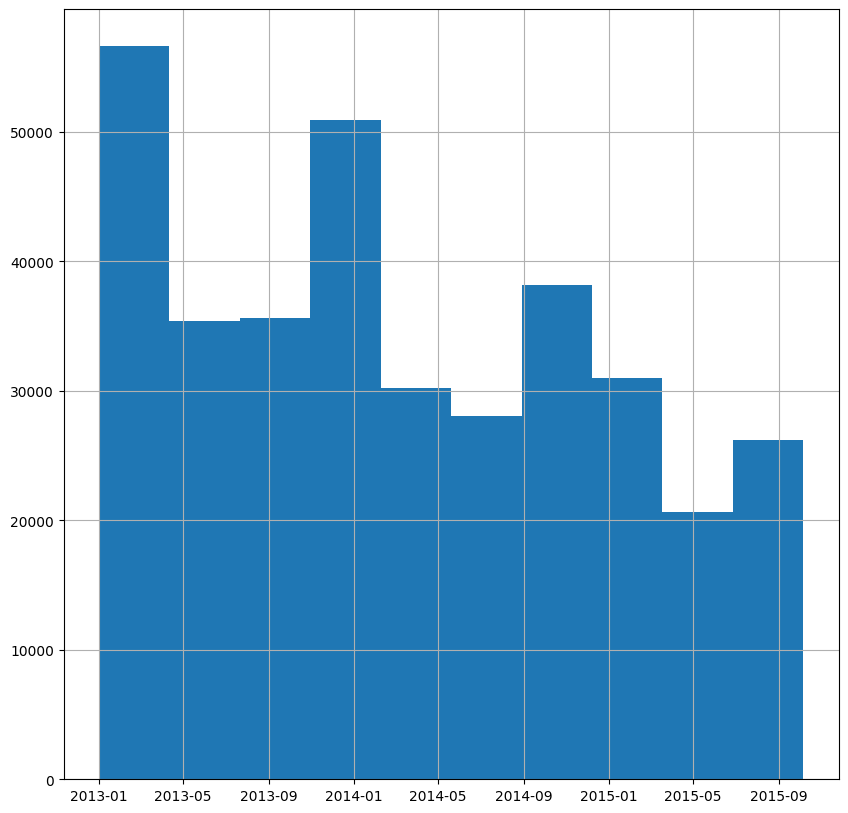

In [46]:
basket['date'].hist(figsize = (10,10))

## Prices
We check items with very different prices among all the purchases to see if there are evident errors

In [47]:
maxPrice = basket.groupby('item_id')['item_price'].max()
minPrice = basket.groupby('item_id')['item_price'].min()
avgPrice = basket.groupby('item_id')['item_price'].mean()
medianPrice = basket.groupby('item_id')['item_price'].median()

In [48]:
maxPrice = pd.DataFrame({'item_id':maxPrice.index, 'maxPrice': maxPrice.values} )
minPrice = pd.DataFrame({'item_id':minPrice.index, 'minPrice': minPrice.values} )
avgPrice = pd.DataFrame({'item_id':avgPrice.index, 'avgPrice': avgPrice.values} )
medianPrice = pd.DataFrame({'item_id':medianPrice.index, 'medianPrice': medianPrice.values} )

In [49]:
pricesInfo = pd.merge(minPrice, maxPrice, how='inner', on='item_id')
pricesInfo = pd.merge(pricesInfo, avgPrice, how='inner', on='item_id')
pricesInfo = pd.merge(pricesInfo, medianPrice, how='inner', on='item_id')

In [50]:
pricesInfo['difference'] = pricesInfo['maxPrice'] - pricesInfo['minPrice']

Coefficient to find high variation price items

In [51]:
pricesInfo['difference_ratio'] = pricesInfo['difference']/pricesInfo['avgPrice']*100
pricesInfo['difference_ratio_median'] = pricesInfo['difference']/pricesInfo['medianPrice']*100

In [52]:
pricesInfo.dropna(inplace=True)

<AxesSubplot:>

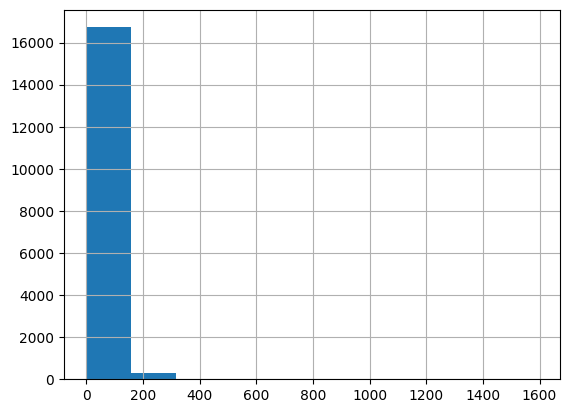

In [53]:
pricesInfo['difference_ratio'].hist()

<AxesSubplot:>

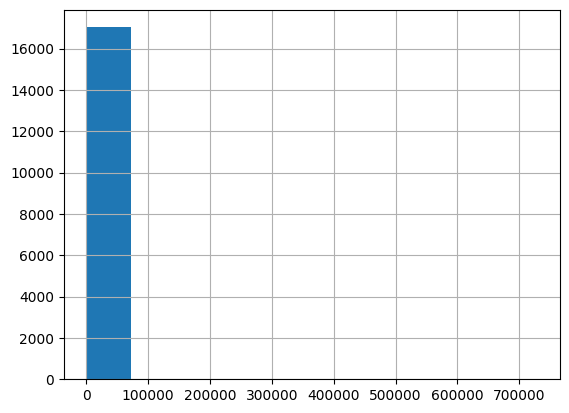

In [54]:
pricesInfo['difference_ratio_median'].hist()

In [55]:
mean = pricesInfo['difference_ratio'].mean()

In [56]:
mean2 = pricesInfo['difference_ratio_median'].mean()

In [57]:
#Cut with mean+3sigma
sigma = np.std(pricesInfo['difference_ratio'] )
sigma2 = np.std(pricesInfo['difference_ratio_median'] )

In [58]:

pricesInfo[pricesInfo['difference_ratio']>mean+3*sigma]

,item_id,minPrice,maxPrice,avgPrice,medianPrice,difference,difference_ratio,difference_ratio_median
811,1438.0,14.00,349.0,170.055556,198.00,335.00,196.994446,169.191919
824,1453.0,248.00,2199.0,905.233333,699.00,1951.00,215.524542,279.113019
1089,1823.0,49.00,599.0,167.881014,149.50,550.00,327.612983,367.892977
1090,1824.0,28.00,599.0,199.881072,169.94,571.00,285.669870,336.000942
1091,1825.0,49.00,599.0,177.241552,174.47,550.00,310.310982,315.240442
...,...,...,...,...,...,...,...,...
17123,21902.0,49.00,400.0,137.590303,99.00,351.00,255.105187,354.545455
17125,21906.0,99.00,499.0,177.125000,149.00,400.00,225.829217,268.456376
17129,21910.0,99.00,549.0,204.016667,199.00,450.00,220.570215,226.130653
17214,22013.0,99.00,749.0,289.909091,199.00,650.00,224.208216,326.633166


In [59]:
bad = pricesInfo[pricesInfo['difference_ratio']>mean+3*sigma]

In [60]:
pricesInfo[pricesInfo['difference_ratio']>mean2+3*sigma2]

,item_id,minPrice,maxPrice,avgPrice,medianPrice,difference,difference_ratio,difference_ratio_median


In [61]:
badItemsPrice = all.merge(bad, on='item_id', how='inner')

In [62]:
badItems = badItemsPrice[badItemsPrice['item_price']==0.1].item_name.unique()

In [63]:
badItems = pd.DataFrame(badItems, columns = ['Column_A'])

In [64]:
badItemsPrice = pd.DataFrame(badItemsPrice, columns = ['item_name'])

In [65]:
badItemsPrice = badItemsPrice.item_name.unique()

In [66]:
badItemsPrice = pd.DataFrame(badItemsPrice, columns = ['item_name'])

In [67]:
badItemsPrice

,item_name
0,МАДАГАСКАР 3
1,БЕЛОСНЕЖКА И ОХОТНИК
2,Прием денежных средств для 1С-Онлайн
3,Forza Motorsport 4 [Xbox 360]
4,"КОД ДОСТУПА ""КЕЙПТАУН"" (BD)"
...,...
187,ГРУППА 7 (BD)
188,"Armored Core: Verdict Day [PS3, английская вер..."
189,МУЖЧИНА С ГАРАНТИЕЙ (BD)
190,ПРИТВОРИСЬ МОИМ МУЖЕМ


We check individually some values

In [68]:
basket[basket['item_id']==11872.0]


,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
575572,2013-06-01,NaN,11872.0,0.1,1.0,509.0,B522409
539288,2013-06-01,19.0,11872.0,0.1,2.0,531.0,B822482
612529,NaT,57.0,11872.0,0.1,NaN,782.0,B522569
608798,2013-06-01,58.0,11872.0,0.1,2.0,718.0,B822574
789836,2013-08-02,21.0,11872.0,0.1,1.0,414.0,B529757
737237,NaT,59.0,11872.0,0.1,1.0,676.0,B529873
612528,2013-06-03,57.0,11872.0,0.1,2.0,35.0,B8615016
608797,2013-06-03,58.0,11872.0,0.1,1.0,734.0,B8215018
745189,NaT,42.0,11872.0,0.1,1.0,NaN,B5216057
15988,NaT,28.0,11872.0,307.0,1.0,166.0,B5218433


In [69]:
items[items['item_id']==11872.0]
#Plushie

,item_name,item_id,item_category_id
11872,Змея ВАСИЛИСА 23 см,11872,63


In [70]:

basket[basket['item_id']==11370.0]



,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
176606,2013-02-01,12.0,11370.0,916.666667,3.0,253.0,B52253
302557,2013-03-01,12.0,11370.0,571.428571,7.0,790.0,B74790
2608377,2015-04-01,12.0,11370.0,233.000000,10.0,722.0,B521721
2699430,2015-06-01,12.0,11370.0,NaN,6.0,794.0,B512803
661589,NaT,12.0,11370.0,750.000000,1.0,264.0,B522973
1830027,2014-07-01,12.0,11370.0,312.500000,8.0,775.0,B823158
2048708,2014-10-01,NaN,11370.0,281.818182,11.0,255.0,B824794
2909775,2015-10-01,12.0,11370.0,333.846154,13.0,153.0,B824998
1058264,2013-11-01,12.0,11370.0,750.000000,1.0,310.0,NaN
2144501,2014-11-01,NaN,11370.0,62.500000,4.0,87.0,B525345


In [71]:
items[items['item_id']==11370.0]
#Traduzione: Consegna (a Mosca)

,item_name,item_id,item_category_id
11370,Доставка (по Москве),11370,9


In [72]:
cat[cat['item_category_id'] == 9]
#Traduzione: Consegna della merce

,item_category_name,item_category_id
9,Доставка товара,9


In [73]:
basket[basket['item_id']==11864.0]


,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id
320780,2013-03-01,25.0,11864.0,NaN,1.0,353.0,B52833
568637,NaT,16.0,11864.0,0.1,1.0,752.0,B822450
595740,2013-06-01,18.0,11864.0,269.0,1.0,696.0,B822454
608755,2013-06-01,58.0,11864.0,0.1,1.0,354.0,B522573
828689,NaT,4.0,11864.0,0.1,1.0,556.0,NaN
789833,NaT,NaN,11864.0,0.1,1.0,454.0,NaN
27088,NaT,27.0,11864.0,469.0,1.0,613.0,B825970
71613,2013-01-02,31.0,11864.0,469.0,1.0,737.0,B525985
579751,2013-06-02,16.0,11864.0,0.1,1.0,100.0,B868624
586986,2013-06-02,26.0,11864.0,0.1,1.0,75.0,B528677


In [74]:
items[items['item_id']==11864.0]


,item_name,item_id,item_category_id
11864,Змей ДЖЕККИ с сердечком 36 см,11864,63


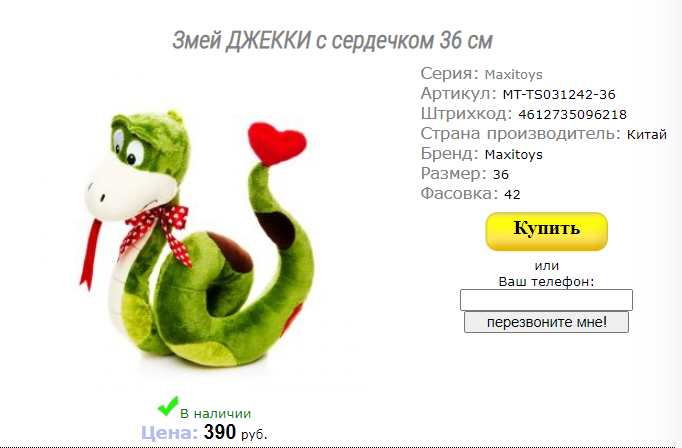

In [75]:
cat[cat['item_category_id'] == 63]

,item_category_name,item_category_id
63,Подарки - Мягкие игрушки,63


In [76]:
all[all['item_price']==0.1] #these are gifts!!!

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
575572,01.06.2013,NaN,11872.0,0.1,1.0,509.0,B522409,Змея ВАСИЛИСА 23 см,63.0,Подарки - Мягкие игрушки
574943,01.06.2013,2.0,20141.0,0.1,1.0,NaN,B822410,Удавчик Плюшевый: 40см на сердечке,63.0,Подарки - Мягкие игрушки
576636,01.06.2013,3.0,11868.0,0.1,1.0,75.0,B512415,Змей ШНУР 52 см,63.0,Подарки - Мягкие игрушки
573375,NaN,4.0,20140.0,0.1,4.0,674.0,B822418,Удавчик Плюшевый: 40см,63.0,Подарки - Мягкие игрушки
576273,NaN,4.0,11870.0,0.1,1.0,NaN,B512419,Змейка СЕРДЕЧКО 60 см,63.0,Подарки - Мягкие игрушки
...,...,...,...,...,...,...,...,...,...,...
778778,06.08.2013,37.0,11854.0,0.1,1.0,633.0,B5134779,Змей ВАСЯ 22 см,63.0,Подарки - Мягкие игрушки
747529,06.08.2013,38.0,11867.0,0.1,1.0,157.0,B5134783,Змей ШНУР 15 см,63.0,Подарки - Мягкие игрушки
745116,06.08.2013,42.0,11853.0,0.1,1.0,90.0,NaN,Змей ВАЛЕНТИН 16 см,63.0,Подарки - Мягкие игрушки


In [77]:
gifts = all[all.item_category_name.str.contains('Подарки', na=False)]

In [78]:
gifts

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
33487,01.01.2013,2.0,20424.0,NaN,1.0,1.0,B11,Фигурка Beavis and Butt-Head Beavis Talking Bo...,72.0,Подарки - Фигурки
32367,01.01.2013,2.0,15456.0,549.0,1.0,4.0,B24,Мягкая игрушка СОЮЗМУЛЬТФИЛЬМ Умка музыкальный,63.0,Подарки - Мягкие игрушки
32569,01.01.2013,2.0,991.0,99.0,1.0,4.0,B24,"3D Action Puzzle ""Динозавры"" Тиранозавр",67.0,Подарки - Развитие
54704,01.01.2013,7.0,9301.0,1389.0,1.0,6.0,B746,Большой игровой набор с микророботами Нано Нан...,62.0,"Подарки - Гаджеты, роботы, спорт"
55980,01.01.2013,7.0,15123.0,170.0,1.0,6.0,B746,Мини-головоломка 19**/ Mini Wire 19** Арт. 473319,67.0,Подарки - Развитие
...,...,...,...,...,...,...,...,...,...,...
1265904,06.12.2013,45.0,21963.0,1499.0,1.0,133.0,B8236818,Шар-лабиринт Perplexus Epic (125 барьеров),67.0,Подарки - Развитие
1260066,NaN,45.0,16295.0,498.0,1.0,221.0,B5136819,"НеоТуб, 5мм, 125 сфер, Золото",67.0,Подарки - Развитие
1263343,NaN,46.0,16227.0,419.0,1.0,151.0,B5236821,Настольная игра Уно,65.0,Подарки - Настольные игры (компактные)


<AxesSubplot:>

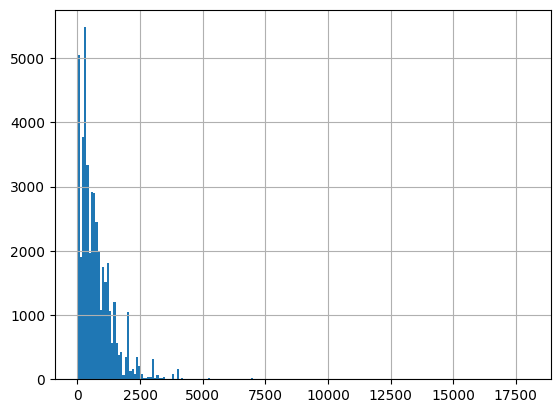

In [79]:
gifts.item_price.hist(bins=200)

<AxesSubplot:>

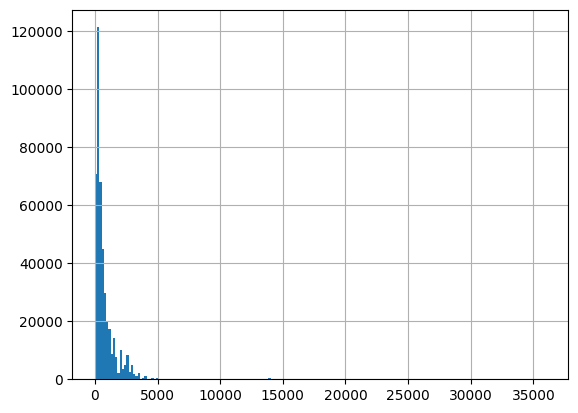

In [80]:
all.item_price.hist(bins=200)

In [81]:
#scenario where we drop gifts
#all.drop(all[all.item_category_name.str.contains('Подарки', na=False)].index, inplace=True)

In [82]:
all.to_csv('../Dataset/purchases0.csv')

##Negative values
We change negative values to their abs value

In [83]:
purchasesAll = pd.read_csv('../Dataset/purchases0.csv', skipinitialspace=True, sep=',')
df = purchasesAll.set_index('index')

In [84]:
df[df['item_cnt_day']<= 0]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
49083,01.01.2013,18.0,NaN,299.5,-1.0,NaN,B7426,NaN,NaN,NaN
10621,01.01.2013,19.0,NaN,1499.0,-1.0,30.0,B7430,NaN,NaN,NaN
26526,NaN,27.0,12269.0,1499.0,-1.0,34.0,B7434,Йо-йо AERO Droid,62.0,"Подарки - Гаджеты, роботы, спорт"
82413,01.01.2013,54.0,3429.0,2799.0,-1.0,67.0,NaN,Far Cry 3 + Код на активацию дополнения Пропав...,23.0,Игры - XBOX 360
1336323,01.01.2014,15.0,13736.0,599.0,-1.0,86.0,B7486,"Крэш: Повелитель мутантов (Essentials) [PSP, р...",21.0,Игры - PSP
...,...,...,...,...,...,...,...,...,...,...
2133415,NaN,57.0,6495.0,499.0,-1.0,801.0,B8636680,"Sims 3: Времена года (дополнение) [PC, русская...",28.0,Игры PC - Дополнительные издания
1187052,06.12.2013,4.0,13921.0,499.0,-1.0,226.0,B8236698,ЛИГА ВЫДАЮЩИХСЯ ДЖЕНТЕЛЬМЕНОВ (BD),37.0,Кино - Blu-Ray
1175201,06.12.2013,12.0,11813.0,2699.0,-1.0,343.0,B5236717,"За гранью: Две души. Специальное издание [PS3,...",19.0,Игры - PS3


In [85]:
df.loc[ (df['item_cnt_day'] <= 0), 'item_cnt_day'] = df.loc[ (df['item_cnt_day'] <= 0), 'item_cnt_day'].abs()

In [86]:
df[df['item_cnt_day']<=0]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504087 entries, 32632 to 1263632
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                352861 non-null  object 
 1   shop_id             469023 non-null  float64
 2   item_id             405085 non-null  float64
 3   item_price          451795 non-null  float64
 4   item_cnt_day        497039 non-null  float64
 5   user_id             433351 non-null  float64
 6   basket_id           437967 non-null  object 
 7   item_name           405085 non-null  object 
 8   item_category_id    405085 non-null  float64
 9   item_category_name  405085 non-null  object 
dtypes: float64(6), object(4)
memory usage: 42.3+ MB


In [88]:
df.to_csv('../Dataset/purchases1.csv')

#c1) **Filling missing values**


Date -> from Basket_id 

Shop_id -> from Basket_id 

Item_id -> ? (unkown object)

item_price -> price for the same object in other shopping session 

item_cnt -> global median

user_id -> from Basket_id (dropping the ones we can't recover from basket)

basket_id -> user+date+shop_id and different item


In [89]:
purchasesAll = pd.read_csv('../Dataset/purchases1.csv', skipinitialspace=True, sep=',')
purchasesAll = purchasesAll.set_index('index')
df = purchasesAll

## Dates

In [90]:
validDate = df.groupby('basket_id')['date'].first()
validDate = pd.DataFrame({'basket_id':validDate.index, 'date_2': validDate.values} )
validDate

,basket_id,date_2
0,B11,01.01.2013
1,B12103,01.01.2014
2,B12107,01.01.2014
3,B1211,01.01.2013
4,B12111,01.01.2014
...,...,...
35749,B869980,None
35750,B869984,02.08.2014
35751,B869988,02.08.2014
35752,B869992,02.08.2014


In [91]:
df = df.reset_index().merge(validDate, on='basket_id', how="left").set_index('index')
df.loc[ (df.date.isna()) & (df.date_2.notnull()), 'date'] = df.loc[ (df.date.isna()) & (df.date_2.notnull()), 'date_2']

In [92]:
df[ (df.date_2.isna()) & (df.basket_id.notnull())]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2
index,,,,,,,,,,,
1340496,NaN,2.0,13039.0,NaN,1.0,71.0,B1271,КУНГ-ФУ ПАНДА 2,40.0,Кино - DVD,None
1361323,NaN,19.0,16057.0,619.0,1.0,96.0,B296,Настольная игра Ёрш,64.0,Подарки - Настольные игры,None
1323227,NaN,38.0,13488.0,11990.0,1.0,120.0,B2120,Комплект «Sony PS3 Super Slim (500 Gb) (CECH-4...,11.0,Игровые консоли - PS3,None
2359743,NaN,4.0,16787.0,1599.0,1.0,NaN,B12191,"Одни из нас [PS3, русская версия]",19.0,Игры - PS3,None
164006,NaN,4.0,2417.0,349.0,1.0,NaN,B12235,Counter Strike. Source (рус.в) (PC-DVD) (Jewel),30.0,Игры PC - Стандартные издания,None
...,...,...,...,...,...,...,...,...,...,...,...
2128446,NaN,50.0,9399.0,299.0,1.0,60.0,B5236649,Брелок металлический WOT Невозмутимый (100112),70.0,Подарки - Сувениры (в навеску),None
2128755,NaN,50.0,4997.0,3199.0,1.0,60.0,B5236649,"NBA 2K15 [PS4, английская версия]",20.0,Игры - PS4,None
2128459,NaN,50.0,NaN,199.0,1.0,60.0,B5236649,NaN,NaN,NaN,None


In [93]:
df[df['date_2'].isnull()]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2
index,,,,,,,,,,,
55356,01.01.2013,7.0,5587.0,199.0,1.0,NaN,NaN,PS Vita/PSP: Наушники Hama HK-3023,5.0,Аксессуары - PSVita,NaN
55164,NaN,7.0,NaN,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN
54645,NaN,7.0,NaN,299.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN
35111,NaN,7.0,NaN,999.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN
55260,01.01.2013,7.0,6724.0,599.0,1.0,NaN,NaN,Star Wars Battlefront Renegade Squadron (Essen...,21.0,Игры - PSP,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1266804,06.12.2013,46.0,10803.0,149.0,1.0,151.0,NaN,ДЕВУШКА С ТАТУИРОВКОЙ ДРАКОНА COL (регион),40.0,Кино - DVD,NaN
1267202,NaN,46.0,4100.0,NaN,1.0,NaN,NaN,KNOPFLER MARK Privateering 2CD,55.0,Музыка - CD локального производства,NaN
1263653,06.12.2013,46.0,NaN,NaN,1.0,146.0,NaN,NaN,NaN,NaN,NaN


In [94]:
df.drop(columns='date_2', inplace=True)


In [95]:
df

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
32632,01.01.2013,2.0,NaN,249.0,1.0,1.0,B11,NaN,NaN,NaN
33487,01.01.2013,2.0,20424.0,NaN,1.0,1.0,B11,Фигурка Beavis and Butt-Head Beavis Talking Bo...,72.0,Подарки - Фигурки
32099,01.01.2013,2.0,6916.0,999.5,1.0,1.0,B11,Tekken Tag Tournament 2 (с поддержкой 3D) [PS3...,19.0,Игры - PS3
33529,01.01.2013,2.0,19718.0,149.0,1.0,1.0,B11,ТОМ И ДЖЕРРИ. КОЛЛЕКЦИЯ ВЫП. 3 WB (регион),40.0,Кино - DVD
31974,01.01.2013,2.0,11828.0,1699.0,1.0,1.0,B11,"Звезды PlayStation: Битва сильнейших [PS Vita,...",22.0,Игры - PSVita
...,...,...,...,...,...,...,...,...,...,...
1263642,06.12.2013,46.0,18698.0,199.0,1.0,809.0,B8636824,СКАЗКА Сказочный подарок на Новый год и Рожде...,55.0,Музыка - CD локального производства
1263638,06.12.2013,46.0,18701.0,199.0,1.0,809.0,B8636824,СКАЗКА Умная собачка Соня,55.0,Музыка - CD локального производства
1266426,06.12.2013,46.0,1511.0,799.0,1.0,809.0,B8636824,Assassin's Creed IV. Черный флаг. Special Edit...,28.0,Игры PC - Дополнительные издания


**21993 righe da sistemare** Sostituire date null con data mediana o data mediana per utente (?)

In [96]:
df[ (df.date.isna()) & (df.user_id.notna())]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
55164,NaN,7.0,NaN,NaN,1.0,5.0,NaN,NaN,NaN,NaN
54645,NaN,7.0,NaN,299.0,1.0,6.0,NaN,NaN,NaN,NaN
35111,NaN,7.0,NaN,999.0,2.0,6.0,NaN,NaN,NaN,NaN
52930,NaN,8.0,16450.0,399.0,2.0,11.0,NaN,ОБЛАЧНЫЙ АТЛАС,40.0,Кино - DVD
47518,NaN,NaN,NaN,999.0,2.0,21.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1257381,NaN,43.0,3335.0,2499.0,1.0,124.0,NaN,"FIFA 14 [Xbox 360, русская версия]",23.0,Игры - XBOX 360
1256389,NaN,43.0,NaN,2099.0,1.0,4.0,NaN,NaN,NaN,NaN
1263057,NaN,NaN,5353.0,199.0,1.0,613.0,NaN,OST Лучшие песни из кинофильмов 1,55.0,Музыка - CD локального производства


## Null ID

We remove those lines where all ids are null, because missing values can't be retrieved

In [97]:
drop1 = df[ (df.shop_id.isna()) & (df.item_id.isna()) & (df.user_id.isna()) & (df.basket_id.isna())]


In [98]:
df.drop(drop1.index, inplace=True)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503956 entries, 32632 to 1263632
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                481962 non-null  object 
 1   shop_id             469023 non-null  float64
 2   item_id             405085 non-null  float64
 3   item_price          451673 non-null  float64
 4   item_cnt_day        496908 non-null  float64
 5   user_id             433351 non-null  float64
 6   basket_id           437967 non-null  object 
 7   item_name           405085 non-null  object 
 8   item_category_id    405085 non-null  float64
 9   item_category_name  405085 non-null  object 
dtypes: float64(6), object(4)
memory usage: 42.3+ MB


In [100]:
drop2 = df[df.drop(columns=['item_name','item_category_id','item_category_name']).isnull().sum(axis=1) == 6]

In [101]:
drop1
#504087

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
7766,01.01.2013,NaN,NaN,79.0,2.0,NaN,NaN,NaN,NaN,NaN
1341497,01.01.2014,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1306667,NaN,NaN,NaN,1399.0,1.0,NaN,NaN,NaN,NaN,NaN
120071,01.02.2013,NaN,NaN,349.0,1.0,NaN,NaN,NaN,NaN,NaN
272660,NaN,NaN,NaN,434.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2805990,06.08.2015,NaN,NaN,79.0,1.0,NaN,NaN,NaN,NaN,NaN
2807570,NaN,NaN,NaN,299.0,1.0,NaN,NaN,NaN,NaN,NaN
2828804,NaN,NaN,NaN,1449.0,1.0,NaN,NaN,NaN,NaN,NaN


In [102]:
drop2

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
810831,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
df.drop(drop2.index, inplace=True)

## Shop_id

In [104]:
validShop = df.groupby('basket_id')['shop_id'].min()
validShop = pd.DataFrame({'basket_id':validShop.index, 'shop_2': validShop.values} )

In [105]:
df = df.reset_index().merge(validShop, on='basket_id', how="left").set_index('index')

In [106]:
df.loc[ (df.shop_id.isna()) & (df.shop_2.notnull()), 'shop_id'] = df.loc[ (df.shop_id.isna()) & (df.shop_2.notnull()), 'shop_2']

In [107]:
df[df['shop_id'].isna()]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,shop_2
index,,,,,,,,,,,
52900,01.01.2013,NaN,15130.0,170.000000,1.0,9.0,NaN,Мини-головоломка 5*/ Mini Wire 05* Арт. 473305,67.0,Подарки - Развитие,NaN
47518,NaN,NaN,NaN,999.000000,2.0,21.0,NaN,NaN,NaN,NaN,NaN
47892,01.01.2013,NaN,3186.0,299.333333,3.0,22.0,NaN,"Elder Scrolls V: Skyrim [PC, Jewel, русская ве...",30.0,Игры PC - Стандартные издания,NaN
47933,NaN,NaN,NaN,119.000000,1.0,22.0,NaN,NaN,NaN,NaN,NaN
10394,NaN,NaN,11319.0,499.000000,1.0,30.0,NaN,Детская интерактивная игра: App Gear Фомфайтер...,62.0,"Подарки - Гаджеты, роботы, спорт",NaN
...,...,...,...,...,...,...,...,...,...,...,...
1231840,06.12.2013,NaN,17754.0,854.000000,1.0,NaN,NaN,"Путешествие. Коллекционное издание [PS3, русск...",19.0,Игры - PS3,NaN
1239427,06.12.2013,NaN,21767.0,149.000000,1.0,817.0,NaN,ЧУЧЕЛО-МЯУЧИЛО (регион),40.0,Кино - DVD,NaN
1263057,NaN,NaN,5353.0,199.000000,1.0,613.0,NaN,OST Лучшие песни из кинофильмов 1,55.0,Музыка - CD локального производства,NaN


## User_id

In [108]:
df[df['user_id'].isna()]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,shop_2
index,,,,,,,,,,,
32833,01.01.2013,2.0,NaN,NaN,1.0,NaN,B132,NaN,NaN,NaN,2.0
32130,01.01.2013,2.0,8712.0,198.0,1.0,NaN,B523,БЕЗ ИСТЕРИКИ!,40.0,Кино - DVD,2.0
55356,01.01.2013,7.0,5587.0,199.0,1.0,NaN,NaN,PS Vita/PSP: Наушники Hama HK-3023,5.0,Аксессуары - PSVita,NaN
54677,01.01.2013,7.0,NaN,NaN,1.0,NaN,B525,NaN,NaN,NaN,7.0
54654,01.01.2013,7.0,7770.0,1099.0,1.0,NaN,B746,"Warhammer 40,000 Dawn of War. Коллекционное из...",29.0,Игры PC - Коллекционные издания,7.0
...,...,...,...,...,...,...,...,...,...,...,...
1265633,06.12.2013,46.0,3936.0,1799.0,1.0,NaN,B8236822,"Injustice: Gods Among Us [PS3, русские субтитры]",19.0,Игры - PS3,46.0
1263552,06.12.2013,46.0,18008.0,1499.0,1.0,NaN,B8236822,РЭМБО ТРИЛОГИЯ (BD),37.0,Кино - Blu-Ray,46.0
1265683,06.12.2013,46.0,4181.0,1090.0,1.0,NaN,B8636824,Kaspersky Internet Security Multi-Device Russi...,75.0,Программы - Для дома и офиса,46.0


In [109]:
validUser = df.groupby('basket_id')['user_id'].first()
validUser = pd.DataFrame({'basket_id':validUser.index, 'user_2': validUser.values} )


In [110]:
validUser

,basket_id,user_2
0,B11,1.0
1,B12103,103.0
2,B12107,107.0
3,B1211,11.0
4,B12111,111.0
...,...,...
35749,B869980,618.0
35750,B869984,326.0
35751,B869988,62.0
35752,B869992,362.0


In [111]:
df = df.reset_index().merge(validUser, on='basket_id', how="left").set_index('index')
df.loc[ (df.user_id.isna()) & (df.user_2.notnull()), 'user_id'] = df.loc[ (df.user_id.isna()) & (df.user_2.notnull()), 'user_2']

In [112]:
df[df['user_id'].isna()]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,shop_2,user_2
index,,,,,,,,,,,,
55356,01.01.2013,7.0,5587.0,199.0,1.0,NaN,NaN,PS Vita/PSP: Наушники Hama HK-3023,5.0,Аксессуары - PSVita,NaN,NaN
55260,01.01.2013,7.0,6724.0,599.0,1.0,NaN,NaN,Star Wars Battlefront Renegade Squadron (Essen...,21.0,Игры - PSP,NaN,NaN
35477,NaN,7.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56875,01.01.2013,14.0,1249.0,299.0,1.0,NaN,NaN,ADELE 21,55.0,Музыка - CD локального производства,NaN,NaN
51974,01.01.2013,18.0,NaN,1999.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1236318,06.12.2013,41.0,2269.0,799.0,1.0,NaN,NaN,"Call of Duty. Ghosts [PС, Digipack, русская ве...",30.0,Игры PC - Стандартные издания,NaN,NaN
1261412,06.12.2013,41.0,14145.0,299.0,1.0,NaN,NaN,ЛЯПИС ТРУБЕЦКОЙ Грай (фирм.),55.0,Музыка - CD локального производства,NaN,NaN
1257050,NaN,43.0,NaN,1999.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Item_Price

In [113]:
df['item_price'].isnull().sum()

52282

In [114]:
PriceItem = df.groupby('item_id')['item_price'].mean()

In [115]:
PriceItem = pd.DataFrame({'item_id':PriceItem.index, 'item_price_2': PriceItem.values} )

In [116]:
PriceItem

,item_id,item_price_2
0,0.0,58.000000
1,1.0,4490.000000
2,3.0,100.000000
3,8.0,58.000000
4,12.0,189.000000
...,...,...
17328,22163.0,169.000000
17329,22164.0,699.000000
17330,22166.0,150.000000
17331,22167.0,297.941176


In [117]:
PriceItem[PriceItem['item_price_2'].isnull()]

,item_id,item_price_2
117,236.0,NaN
244,537.0,NaN
251,549.0,NaN
280,613.0,NaN
285,621.0,NaN
...,...,...
16990,21748.0,NaN
17003,21763.0,NaN
17048,21818.0,NaN
17232,22036.0,NaN


In [118]:
df = df.reset_index().merge(PriceItem, on='item_id', how="left").set_index('index')

In [119]:
df.loc[(df['item_price'].isnull()) & (df['item_price_2'].notnull()),'item_price']=df.loc[(df['item_price'].isnull()) & (df['item_price_2'].notnull()),'item_price_2']

In [120]:
df['item_price'].isnull().sum()

10583

In [121]:
meanPrice=df['item_price'].mean()
medianPrice=df['item_price'].median()
print(meanPrice)
print(medianPrice)

870.6986453828155
399.0


In [122]:
df[(df['item_price'].isnull()) & (df['item_id'].isnull())]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,shop_2,user_2,item_price_2
index,,,,,,,,,,,,,
32833,01.01.2013,2.0,NaN,NaN,1.0,2.0,B132,NaN,NaN,NaN,2.0,2.0,NaN
54677,01.01.2013,7.0,NaN,NaN,1.0,5.0,B525,NaN,NaN,NaN,7.0,5.0,NaN
55164,NaN,7.0,NaN,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35207,01.01.2013,7.0,NaN,NaN,1.0,6.0,B746,NaN,NaN,NaN,7.0,6.0,NaN
35477,NaN,7.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232149,06.12.2013,35.0,NaN,NaN,1.0,289.0,B8636792,NaN,NaN,NaN,35.0,289.0,NaN
1267249,06.12.2013,46.0,NaN,NaN,1.0,151.0,B5236821,NaN,NaN,NaN,46.0,151.0,NaN
1263653,06.12.2013,46.0,NaN,NaN,1.0,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
df[(df['item_price'].isnull()) & (df['item_id'].isnull())]['user_id'].nunique()

823

In [124]:
df['item_id'].isnull().sum()

98870

## item_cnt_day

In [125]:
df['item_cnt_day'].isnull().sum()

7047

In [126]:
df['item_cnt_day'].median()


1.0

In [127]:
df['item_cnt_day'].fillna(df['item_cnt_day'].median(),inplace=True)

In [128]:
df['item_cnt_day'].isnull().sum()

0

## Basket_id

In [129]:
df['basket_id'].isnull().sum()

65988

In [130]:
df[(df['basket_id'].isnull()) & (df['date'].notnull()) & (df['shop_id'].notnull()) & (df['user_id'].notnull())]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,shop_2,user_2,item_price_2
index,,,,,,,,,,,,,
54607,01.01.2013,7.0,NaN,199.000000,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35175,01.01.2013,7.0,3178.0,349.000000,1.0,6.0,NaN,"El Shaddai – Ascension of the Metatron [PS3, а...",19.0,Игры - PS3,NaN,NaN,398.500000
55858,01.01.2013,8.0,NaN,NaN,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53192,01.01.2013,8.0,4531.0,295.612903,1.0,9.0,NaN,MAE VANESSA The Best Of,55.0,Музыка - CD локального производства,NaN,NaN,295.612903
52861,01.01.2013,8.0,NaN,NaN,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265986,06.12.2013,46.0,1249.0,299.000000,1.0,151.0,NaN,ADELE 21,55.0,Музыка - CD локального производства,NaN,NaN,294.811298
1265466,06.12.2013,46.0,2808.0,999.000000,1.0,151.0,NaN,"Diablo III [PC, Jewel, русская версия]",30.0,Игры PC - Стандартные издания,NaN,NaN,1007.451223
1266804,06.12.2013,46.0,10803.0,149.000000,1.0,151.0,NaN,ДЕВУШКА С ТАТУИРОВКОЙ ДРАКОНА COL (регион),40.0,Кино - DVD,NaN,NaN,145.961538


In [131]:
validBasket=df.groupby(['date','user_id','shop_id'])['basket_id'].first()

In [132]:
validBasket=validBasket.to_frame()

In [133]:
validBasket

basket_id
date       user_id shop_id          
01.01.2013 1.0     2.0           B11
           2.0     2.0          B132
           3.0     2.0          B523
           4.0     2.0           B24
           5.0     7.0          B525
...                              ...
06.12.2013 809.0   46.0     B8636824
           811.0   7.0      B8236710
           817.0   37.0     B8236794
           820.0   5.0      B8636704
                   18.0     B8636744

[34099 rows x 1 columns]

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503955 entries, 32632 to 1263632
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                481962 non-null  object 
 1   shop_id             499062 non-null  float64
 2   item_id             405085 non-null  float64
 3   item_price          493372 non-null  float64
 4   item_cnt_day        503955 non-null  float64
 5   user_id             494198 non-null  float64
 6   basket_id           437967 non-null  object 
 7   item_name           405085 non-null  object 
 8   item_category_id    405085 non-null  float64
 9   item_category_name  405085 non-null  object 
 10  shop_2              437690 non-null  float64
 11  user_2              437269 non-null  float64
 12  item_price_2        404781 non-null  float64
dtypes: float64(9), object(4)
memory usage: 53.8+ MB


In [135]:
df.to_csv('../Dataset/purchases2.csv')

In [136]:
df = df.reset_index().merge(validBasket, on=['date','user_id','shop_id'], how="left").set_index('index')

In [137]:
df

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id_x,item_name,item_category_id,item_category_name,shop_2,user_2,item_price_2,basket_id_y
index,,,,,,,,,,,,,,
32632,01.01.2013,2.0,NaN,249.00,1.0,1.0,B11,NaN,NaN,NaN,2.0,1.0,NaN,B11
33487,01.01.2013,2.0,20424.0,919.08,1.0,1.0,B11,Фигурка Beavis and Butt-Head Beavis Talking Bo...,72.0,Подарки - Фигурки,2.0,1.0,919.080000,B11
32099,01.01.2013,2.0,6916.0,999.50,1.0,1.0,B11,Tekken Tag Tournament 2 (с поддержкой 3D) [PS3...,19.0,Игры - PS3,2.0,1.0,936.266020,B11
33529,01.01.2013,2.0,19718.0,149.00,1.0,1.0,B11,ТОМ И ДЖЕРРИ. КОЛЛЕКЦИЯ ВЫП. 3 WB (регион),40.0,Кино - DVD,2.0,1.0,140.405882,B11
31974,01.01.2013,2.0,11828.0,1699.00,1.0,1.0,B11,"Звезды PlayStation: Битва сильнейших [PS Vita,...",22.0,Игры - PSVita,2.0,1.0,1229.248611,B11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263642,06.12.2013,46.0,18698.0,199.00,1.0,809.0,B8636824,СКАЗКА Сказочный подарок на Новый год и Рожде...,55.0,Музыка - CD локального производства,46.0,809.0,199.000000,B8636824
1263638,06.12.2013,46.0,18701.0,199.00,1.0,809.0,B8636824,СКАЗКА Умная собачка Соня,55.0,Музыка - CD локального производства,46.0,809.0,193.256410,B8636824
1266426,06.12.2013,46.0,1511.0,799.00,1.0,809.0,B8636824,Assassin's Creed IV. Черный флаг. Special Edit...,28.0,Игры PC - Дополнительные издания,46.0,809.0,793.447239,B8636824


In [138]:
df.loc[(df['basket_id_x'].isnull()) & (df['basket_id_y'].notnull()),'basket_id_x']=df.loc[(df['basket_id_x'].isnull()) & (df['basket_id_y'].notnull()),'basket_id_y']

In [139]:
df['basket_id_x'].isnull().sum()

29762

In [140]:
df.drop(columns=['shop_2','user_2','item_price_2','basket_id_y'],inplace=True)
df.rename(columns={'basket_id_x':'basket_id'},inplace=True)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503955 entries, 32632 to 1263632
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                481962 non-null  object 
 1   shop_id             499062 non-null  float64
 2   item_id             405085 non-null  float64
 3   item_price          493372 non-null  float64
 4   item_cnt_day        503955 non-null  float64
 5   user_id             494198 non-null  float64
 6   basket_id           474193 non-null  object 
 7   item_name           405085 non-null  object 
 8   item_category_id    405085 non-null  float64
 9   item_category_name  405085 non-null  object 
dtypes: float64(6), object(4)
memory usage: 42.3+ MB


#c2) Filling remaining missing values
We fill these values retrieving information from the dataset using global mean, median, ecc.

## Date 2

In [142]:
df.isnull().sum()

date                  21993
shop_id                4893
item_id               98870
item_price            10583
item_cnt_day              0
user_id                9757
basket_id             29762
item_name             98870
item_category_id      98870
item_category_name    98870
dtype: int64

In [143]:
df['date']=pd.to_datetime(df['date'], format="%d.%m.%Y",errors='coerce')
validDate=df.groupby('user_id')['date'].median()
validDate=pd.DataFrame({'user_id':validDate.index, 'date_2': validDate.values} )
df = df.reset_index().merge(validDate, on='user_id', how="left").set_index('index')


In [144]:
df.loc[(df['date'].isnull()) & (df['date_2'].notnull()),'date']=df.loc[(df['date'].isnull()) & (df['date_2'].notnull()),'date_2']

In [145]:
df['date'].isnull().sum()

2882

## User_id 2

In [146]:
df['user_id'].isnull().sum()

9757

In [147]:
dfdrop=df.loc[df['user_id'].isnull()]

In [148]:
dfdrop

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2
index,,,,,,,,,,,
55356,2013-01-01,7.0,5587.0,199.000000,1.0,NaN,NaN,PS Vita/PSP: Наушники Hama HK-3023,5.0,Аксессуары - PSVita,NaT
55260,2013-01-01,7.0,6724.0,599.000000,1.0,NaN,NaN,Star Wars Battlefront Renegade Squadron (Essen...,21.0,Игры - PSP,NaT
35477,NaT,7.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaT
56875,2013-01-01,14.0,1249.0,299.000000,1.0,NaN,NaN,ADELE 21,55.0,Музыка - CD локального производства,NaT
51974,2013-01-01,18.0,NaN,1999.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...
1236318,2013-12-06,41.0,2269.0,799.000000,1.0,NaN,NaN,"Call of Duty. Ghosts [PС, Digipack, русская ве...",30.0,Игры PC - Стандартные издания,NaT
1261412,2013-12-06,41.0,14145.0,299.000000,1.0,NaN,NaN,ЛЯПИС ТРУБЕЦКОЙ Грай (фирм.),55.0,Музыка - CD локального производства,NaT
1257050,NaT,43.0,NaN,1999.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaT


In [149]:
df.drop(dfdrop.index,inplace=True)
df['user_id'].isnull().sum()

0

In [150]:
df.isnull().sum()

date                      0
shop_id                4307
item_id               97012
item_price            10369
item_cnt_day              0
user_id                   0
basket_id             20703
item_name             97012
item_category_id      97012
item_category_name    97012
date_2                    0
dtype: int64

## Shop_id 2

In [151]:
df[df['shop_id'].isnull()]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2
index,,,,,,,,,,,
52900,2013-01-01,NaN,15130.0,170.000000,1.0,9.0,NaN,Мини-головоломка 5*/ Mini Wire 05* Арт. 473305,67.0,Подарки - Развитие,2013-10-03
47518,2014-07-06,NaN,NaN,999.000000,2.0,21.0,NaN,NaN,NaN,NaN,2014-07-06
47892,2013-01-01,NaN,3186.0,299.333333,3.0,22.0,NaN,"Elder Scrolls V: Skyrim [PC, Jewel, русская ве...",30.0,Игры PC - Стандартные издания,2013-12-06
47933,2013-12-06,NaN,NaN,119.000000,1.0,22.0,NaN,NaN,NaN,NaN,2013-12-06
10394,2013-08-03,NaN,11319.0,499.000000,1.0,30.0,NaN,Детская интерактивная игра: App Gear Фомфайтер...,62.0,"Подарки - Гаджеты, роботы, спорт",2013-08-03
...,...,...,...,...,...,...,...,...,...,...,...
1234481,2013-10-06,NaN,NaN,999.000000,1.0,610.0,NaN,NaN,NaN,NaN,2013-10-06
1239427,2013-12-06,NaN,21767.0,149.000000,1.0,817.0,NaN,ЧУЧЕЛО-МЯУЧИЛО (регион),40.0,Кино - DVD,2014-03-05
1263057,2013-12-06,NaN,5353.0,199.000000,1.0,613.0,NaN,OST Лучшие песни из кинофильмов 1,55.0,Музыка - CD локального производства,2013-12-06


In [152]:
validShop=df.groupby('user_id')['shop_id'].agg(lambda x:pd.Series.mode(x)[0])
validShop=pd.DataFrame({'user_id':validShop.index, 'shop_id2': validShop.values})
validShop

,user_id,shop_id2
0,1.0,57.0
1,2.0,31.0
2,3.0,47.0
3,4.0,54.0
4,5.0,28.0
...,...,...
819,820.0,25.0
820,821.0,25.0
821,822.0,25.0
822,823.0,35.0


In [153]:
df = df.reset_index().merge(validShop, on='user_id', how="left").set_index('index')
df.loc[(df['shop_id'].isnull()) & (df['shop_id2'].notnull()),'shop_id']=df.loc[(df['shop_id'].isnull()) & (df['shop_id2'].notnull()),'shop_id2']
df.isnull().sum()

date                      0
shop_id                   0
item_id               97012
item_price            10369
item_cnt_day              0
user_id                   0
basket_id             20703
item_name             97012
item_category_id      97012
item_category_name    97012
date_2                    0
shop_id2                  0
dtype: int64

## Basket_id 2

In [154]:
df['basket_id']

index
32632           B11
33487           B11
32099           B11
33529           B11
31974           B11
             ...   
1263642    B8636824
1263638    B8636824
1266426    B8636824
1263258    B8636824
1263632    B8636824
Name: basket_id, Length: 494198, dtype: object

In [155]:
df['basket_id'].isnull().sum()

20703

In [156]:
df['basket_id'].notnull().sum()

473495

In [157]:
df[df['basket_id'].str.contains('^B', na=False, case=False)]
#df[df["A"].str.contains(r'\btest\b', regex=True, case=False)] #Returns values as expected


,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2,shop_id2
index,,,,,,,,,,,,
32632,2013-01-01,2.0,NaN,249.00,1.0,1.0,B11,NaN,NaN,NaN,2014-03-04,57.0
33487,2013-01-01,2.0,20424.0,919.08,1.0,1.0,B11,Фигурка Beavis and Butt-Head Beavis Talking Bo...,72.0,Подарки - Фигурки,2014-03-04,57.0
32099,2013-01-01,2.0,6916.0,999.50,1.0,1.0,B11,Tekken Tag Tournament 2 (с поддержкой 3D) [PS3...,19.0,Игры - PS3,2014-03-04,57.0
33529,2013-01-01,2.0,19718.0,149.00,1.0,1.0,B11,ТОМ И ДЖЕРРИ. КОЛЛЕКЦИЯ ВЫП. 3 WB (регион),40.0,Кино - DVD,2014-03-04,57.0
31974,2013-01-01,2.0,11828.0,1699.00,1.0,1.0,B11,"Звезды PlayStation: Битва сильнейших [PS Vita,...",22.0,Игры - PSVita,2014-03-04,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1263642,2013-12-06,46.0,18698.0,199.00,1.0,809.0,B8636824,СКАЗКА Сказочный подарок на Новый год и Рожде...,55.0,Музыка - CD локального производства,2014-01-03,31.0
1263638,2013-12-06,46.0,18701.0,199.00,1.0,809.0,B8636824,СКАЗКА Умная собачка Соня,55.0,Музыка - CD локального производства,2014-01-03,31.0
1266426,2013-12-06,46.0,1511.0,799.00,1.0,809.0,B8636824,Assassin's Creed IV. Черный флаг. Special Edit...,28.0,Игры PC - Дополнительные издания,2014-01-03,31.0


In [158]:
df.loc[df['basket_id'].isnull(), 'basket_id'] = range(0,df['basket_id'].isnull().sum())

In [159]:
df

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2,shop_id2
index,,,,,,,,,,,,
32632,2013-01-01,2.0,NaN,249.00,1.0,1.0,B11,NaN,NaN,NaN,2014-03-04,57.0
33487,2013-01-01,2.0,20424.0,919.08,1.0,1.0,B11,Фигурка Beavis and Butt-Head Beavis Talking Bo...,72.0,Подарки - Фигурки,2014-03-04,57.0
32099,2013-01-01,2.0,6916.0,999.50,1.0,1.0,B11,Tekken Tag Tournament 2 (с поддержкой 3D) [PS3...,19.0,Игры - PS3,2014-03-04,57.0
33529,2013-01-01,2.0,19718.0,149.00,1.0,1.0,B11,ТОМ И ДЖЕРРИ. КОЛЛЕКЦИЯ ВЫП. 3 WB (регион),40.0,Кино - DVD,2014-03-04,57.0
31974,2013-01-01,2.0,11828.0,1699.00,1.0,1.0,B11,"Звезды PlayStation: Битва сильнейших [PS Vita,...",22.0,Игры - PSVita,2014-03-04,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1263642,2013-12-06,46.0,18698.0,199.00,1.0,809.0,B8636824,СКАЗКА Сказочный подарок на Новый год и Рожде...,55.0,Музыка - CD локального производства,2014-01-03,31.0
1263638,2013-12-06,46.0,18701.0,199.00,1.0,809.0,B8636824,СКАЗКА Умная собачка Соня,55.0,Музыка - CD локального производства,2014-01-03,31.0
1266426,2013-12-06,46.0,1511.0,799.00,1.0,809.0,B8636824,Assassin's Creed IV. Черный флаг. Special Edit...,28.0,Игры PC - Дополнительные издания,2014-01-03,31.0


##Item_id and Item_price (2)

In [160]:
df.isnull().sum()

date                      0
shop_id                   0
item_id               97012
item_price            10369
item_cnt_day              0
user_id                   0
basket_id                 0
item_name             97012
item_category_id      97012
item_category_name    97012
date_2                    0
shop_id2                  0
dtype: int64

In [161]:
test = (df.groupby('user_id')['item_cnt_day'].sum()).to_frame()
print(test['item_cnt_day'].mean())
print(test['item_cnt_day'].median())

746.1966019417475
715.0


<AxesSubplot:>

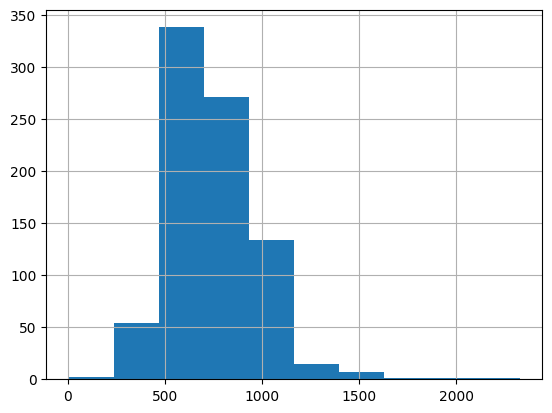

In [162]:
test['item_cnt_day'].hist()

<AxesSubplot:>

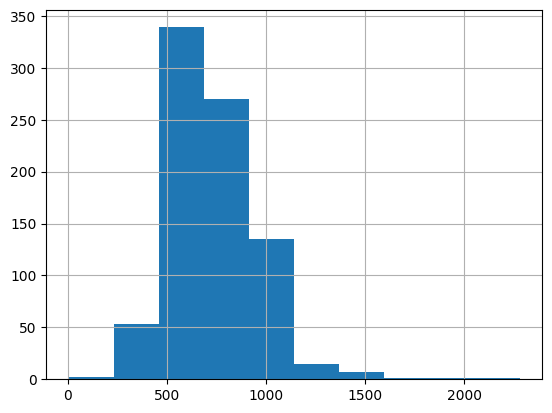

In [163]:
toDrop = df.loc[(df['item_id'].isnull() & df['item_price'].isnull())]
dfDropped = df.drop(toDrop.index)
test2 = (dfDropped.groupby('user_id')['item_cnt_day'].sum()).to_frame()
test2['item_cnt_day'].hist()

In [164]:
print(test2['item_cnt_day'].mean())
print(test2['item_cnt_day'].median())

731.1116504854369
698.0


0.06640432857845549
0.020087224014781906


<AxesSubplot:>

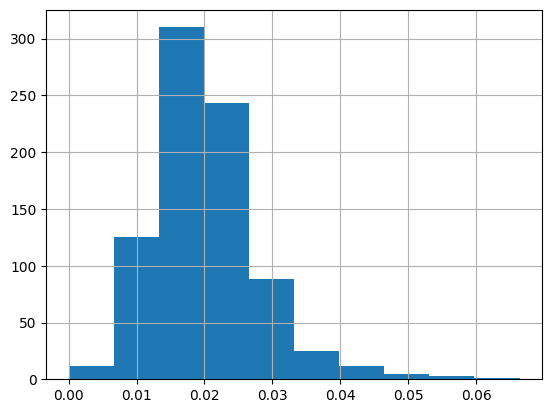

In [165]:
test3 = pd.merge(test, test2, on='user_id')
test3['diff'] = test3['item_cnt_day_x'] - test3['item_cnt_day_y']
test3['ratio'] = test3['diff']/test3['item_cnt_day_x']
print(test3['ratio'].max())
print(test3['ratio'].mean())
test3['ratio'].hist()

<AxesSubplot:>

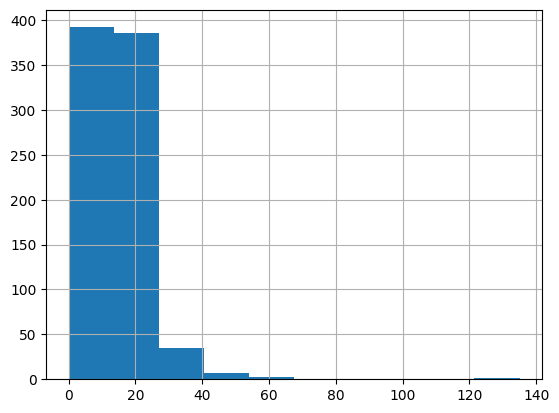

In [166]:
test3['diff'].hist()

<AxesSubplot:>

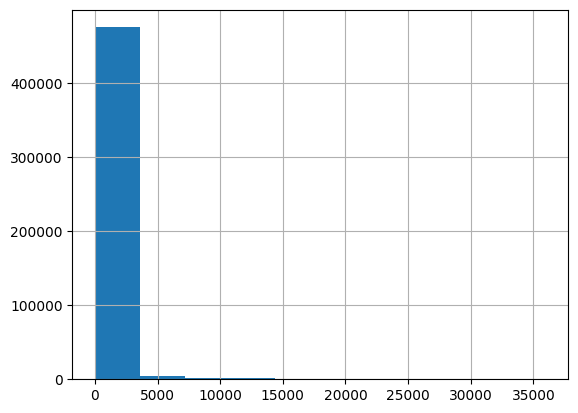

In [167]:
df['item_price'].hist()

<AxesSubplot:>

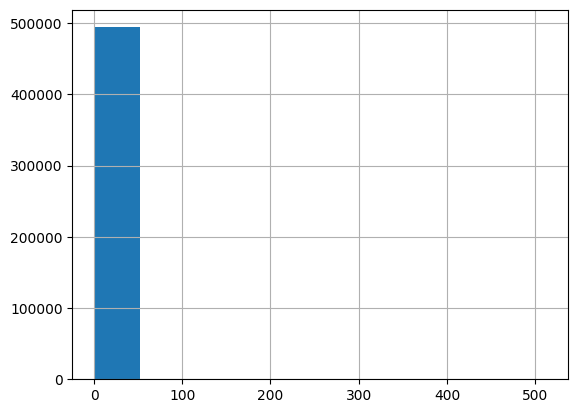

In [168]:
df['item_cnt_day'].hist()

We set item_id to -1 where item_id is NaN

In [169]:
df.loc[df['item_id'].isnull(), 'item_id'] = -1

We also add the Unknown category and item to items and cat dataframe

In [170]:
cat = cat.append({'item_category_id': -1, 'item_category_name': 'Unknown'}, ignore_index=True)
items = items.append({'item_name': 'Unknown', 'item_id': -1, 'item_category_id': -1}, ignore_index=True)

/var/folders/nx/7fwc9svx06d5smgh8xw0ql4m0000gn/T/ipykernel_65797/2516997124.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cat = cat.append({'item_category_id': -1, 'item_category_name': 'Unknown'}, ignore_index=True)
/var/folders/nx/7fwc9svx06d5smgh8xw0ql4m0000gn/T/ipykernel_65797/2516997124.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  items = items.append({'item_name': 'Unknown', 'item_id': -1, 'item_category_id': -1}, ignore_index=True)


We remove those rows where item_id is Unkown (-1) and item_price is NaN

In [171]:
toDrop = df.loc[ (df['item_id'] == -1) & (df['item_price'].isnull()) ]

In [172]:
toDrop

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2,shop_id2
index,,,,,,,,,,,,
32833,2013-01-01 00:00:00,2.0,-1.0,NaN,1.0,2.0,B132,NaN,NaN,NaN,2014-05-04 00:00:00,31.0
54677,2013-01-01 00:00:00,7.0,-1.0,NaN,1.0,5.0,B525,NaN,NaN,NaN,2014-05-03 12:00:00,28.0
55164,2014-05-03 12:00:00,7.0,-1.0,NaN,1.0,5.0,0,NaN,NaN,NaN,2014-05-03 12:00:00,28.0
35207,2013-01-01 00:00:00,7.0,-1.0,NaN,1.0,6.0,B746,NaN,NaN,NaN,2014-04-01 00:00:00,42.0
55858,2013-01-01 00:00:00,8.0,-1.0,NaN,1.0,9.0,B529,NaN,NaN,NaN,2013-10-03 00:00:00,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1232149,2013-12-06 00:00:00,35.0,-1.0,NaN,1.0,289.0,B8636792,NaN,NaN,NaN,2014-04-06 00:00:00,31.0
1267249,2013-12-06 00:00:00,46.0,-1.0,NaN,1.0,151.0,B5236821,NaN,NaN,NaN,2013-10-06 00:00:00,27.0
1263653,2013-12-06 00:00:00,46.0,-1.0,NaN,1.0,146.0,B8236822,NaN,NaN,NaN,2013-11-03 00:00:00,54.0


In [173]:
df.drop(toDrop.index, inplace=True)

We substitute those items where price is missing and we couldn't retrieve it with the median price of the dataset

In [174]:
df.isnull().sum()

date                      0
shop_id                   0
item_id                   0
item_price              300
item_cnt_day              0
user_id                   0
basket_id                 0
item_name             86943
item_category_id      86943
item_category_name    86943
date_2                    0
shop_id2                  0
dtype: int64

In [175]:
df[df['item_price'].isnull()]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2,shop_id2
index,,,,,,,,,,,,
28733,2013-01-01,27.0,3203.0,NaN,1.0,33.0,B5233,Eplay Самые увлекательные игры. Темные предани...,30.0,Игры PC - Стандартные издания,2013-08-03,27.0
15639,2013-01-01,28.0,5519.0,NaN,1.0,37.0,B5237,PLAY. КИНО БЕЗ ГРАНИЦ,40.0,Кино - DVD,2014-06-06,31.0
92475,2013-01-01,42.0,9704.0,NaN,1.0,53.0,B5253,ВВС:ПЛАНЕТА ЛЮДЕЙ (3 BD),37.0,Кино - Blu-Ray,2014-01-02,42.0
1271185,2014-01-01,55.0,943.0,NaN,1.0,141.0,B52141,"20000 Лье под водой [PC, Цифровая версия]",31.0,Игры PC - Цифра,2013-12-04,31.0
2323530,2015-01-01,27.0,19485.0,NaN,1.0,173.0,B52173,Сумка Assassin's Creed Messenger Bag Assassin'...,61.0,Подарки - Атрибутика,2013-12-01,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2066247,2014-10-06,17.0,2186.0,NaN,1.0,426.0,B5235985,COCKER JOE Sheffield Steel LP,58.0,Музыка - Винил,2014-05-02,3.0
2090357,2014-10-06,37.0,21417.0,NaN,1.0,604.0,B5236053,ХОРТОН м/ф (BD),37.0,Кино - Blu-Ray,2013-06-06,41.0
2900195,2015-10-06,57.0,10780.0,NaN,1.0,565.0,B5236297,ДДТ Легенды русского рока 2 (фирм.),55.0,Музыка - CD локального производства,2013-11-03,28.0


In [176]:
df[df['item_id']==3203]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name,date_2,shop_id2
index,,,,,,,,,,,,
28733,2013-01-01,27.0,3203.0,NaN,1.0,33.0,B5233,Eplay Самые увлекательные игры. Темные предани...,30.0,Игры PC - Стандартные издания,2013-08-03,27.0
681956,2013-07-04,24.0,3203.0,NaN,1.0,4.0,B5121715,Eplay Самые увлекательные игры. Темные предани...,30.0,Игры PC - Стандартные издания,2013-12-01,54.0


In [177]:
df.item_price.median()

399.0

In [178]:
df.loc[df.item_price.isnull(), 'item_price'] = df.item_price.median()

In [179]:
df.isnull().sum()

date                      0
shop_id                   0
item_id                   0
item_price                0
item_cnt_day              0
user_id                   0
basket_id                 0
item_name             86943
item_category_id      86943
item_category_name    86943
date_2                    0
shop_id2                  0
dtype: int64

##Final clean

In [180]:
df.drop(columns=['date_2', 'shop_id2', 'item_name', 'item_category_id', 'item_category_name'], inplace=True)
df.to_csv('../Dataset/dfClean1.csv')

df = pd.read_csv('../Dataset/dfClean1.csv', skipinitialspace=True, sep=',')
df = df.set_index('index')

In [181]:
df = df.reset_index().merge(items, on='item_id', how="left").set_index('index')
df = df.reset_index().merge(cat, on='item_category_id', how="left").set_index('index')

# d) Outliers on original data
We detect outliers with different methods based on item distribution and boxplot

## item_price

<AxesSubplot:>

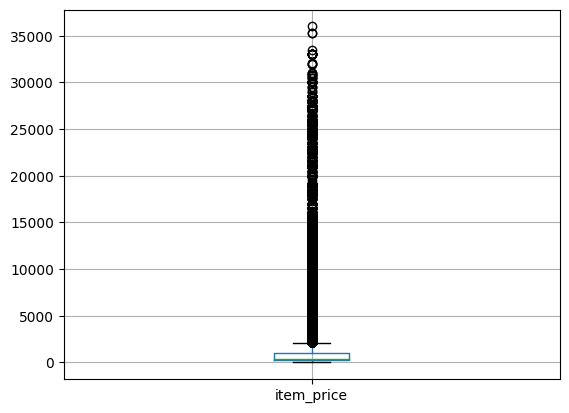

In [182]:
df.boxplot('item_price')




Test quantili

In [183]:
Q1 = df['item_price'].quantile(0.25)
Q3 = df['item_price'].quantile(0.75)
IQR = Q3 - Q1

In [184]:
quantile_out = df.loc[ ( (df['item_price'] < (Q1 - 1.5 * IQR) ) | (df['item_price'] > (Q3 + 1.5 * IQR)  ) )] 

In [185]:
quantile_out.item_price.min()

2125.0

<AxesSubplot:>

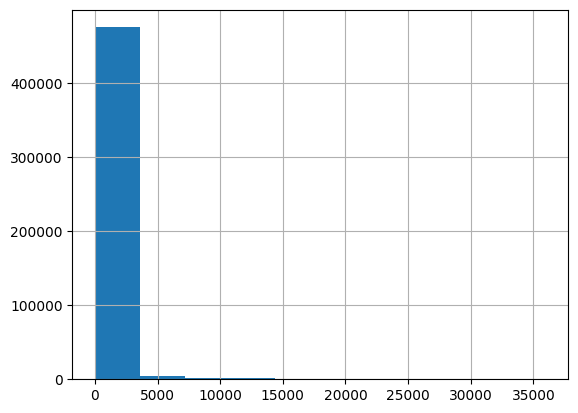

In [186]:
df.item_price.hist()

In [187]:
mean_price = df.item_price.mean()
median_price = df.item_price.median()

print('mean:' + str(mean_price))
print('median:' + str(median_price))

mean:869.8327485528173
median:399.0


In [188]:
sigma_price = df.item_price.std()
print('standard dev:' + str(sigma_price))

standard dev:1653.3119786814098


In [189]:
outliers = df[df.item_price > mean_price + 3*sigma_price]

In [190]:
print(len(df[df.item_price > mean_price + 3*sigma_price]))
print( len(df[df.item_price <= mean_price + 3*sigma_price]))

4633
479496


In [191]:
print(4633/484129*100)
#0,96% of the dataset are outliers for item_price

0.9569763430821123


In [192]:
df2 = df.drop(outliers.index)
df.item_price.max()

35990.0

<AxesSubplot:>

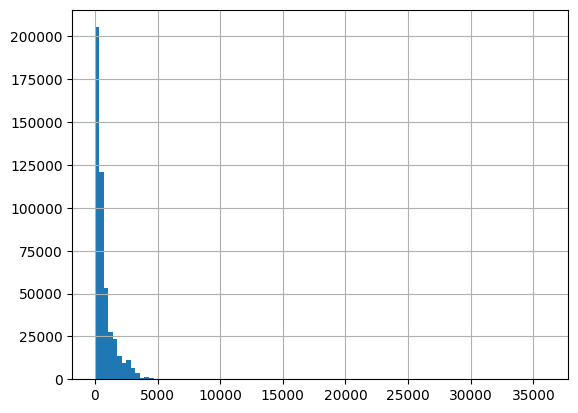

In [193]:
df.item_price.hist(bins=100)

We plot a projection of outliers deletion

<AxesSubplot:>

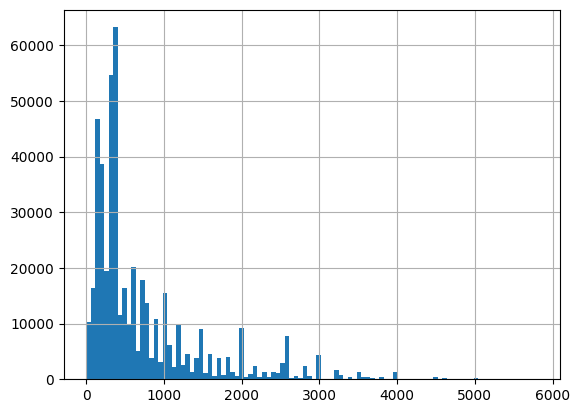

In [194]:
df2.item_price.hist(bins=100)

<AxesSubplot:>

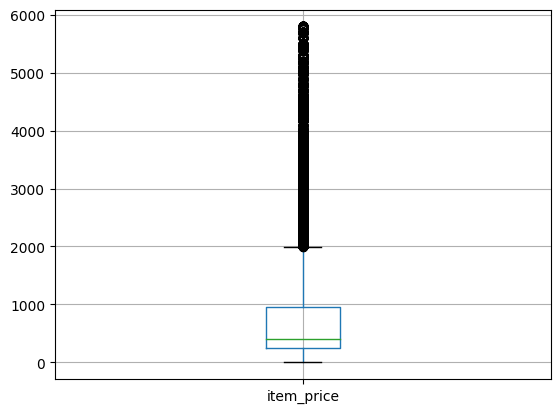

In [195]:
df2.boxplot('item_price')

In [196]:
mean_price2 = df2.item_price.mean()
median_price2 = df2.item_price.median()

print('mean:' + str(mean_price2))
print('median:' + str(median_price2))

mean:740.1289226849638
median:399.0


In [197]:
sigma_price2 = df2.item_price.std()
print('standard dev:' + str(sigma_price2))

standard dev:785.0881541170224


In [198]:
#sostituzione outliers
outliers['item_price']=median_price2
df.update(outliers)
df['item_price'].mean()

/var/folders/nx/7fwc9svx06d5smgh8xw0ql4m0000gn/T/ipykernel_65797/2697904385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['item_price']=median_price2


736.8643995954576

## item_cnt_day

<AxesSubplot:>

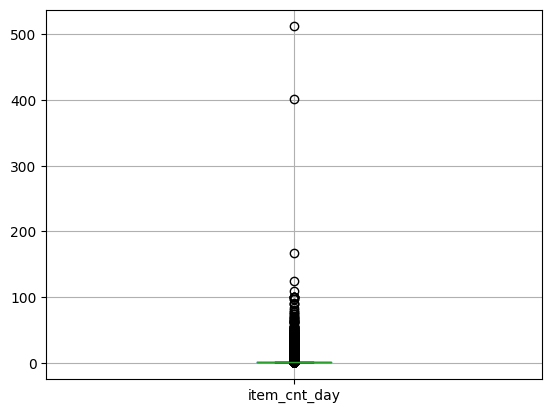

In [199]:
df.boxplot('item_cnt_day')

In [200]:
mean_cnt = df.item_cnt_day.mean()
median_cnt = df.item_cnt_day.median()

print('mean:' + str(mean_cnt))
print('median:' + str(median_cnt))

mean:1.2443708185215097
median:1.0


In [201]:
sigma_cnt = df.item_cnt_day.std()
print('standard dev:' + str(sigma_cnt))

standard dev:1.784217275413928


In [202]:
outliers2 = df2[df2.item_cnt_day > mean_cnt + 3*sigma_cnt]

<AxesSubplot:>

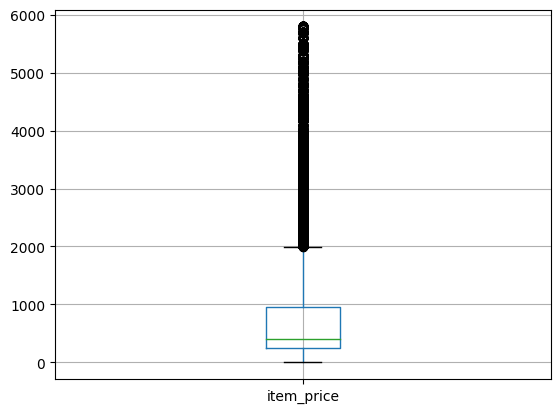

In [203]:
df2.boxplot('item_price')

In [204]:
df2 = df2.drop(outliers2.index)

<AxesSubplot:>

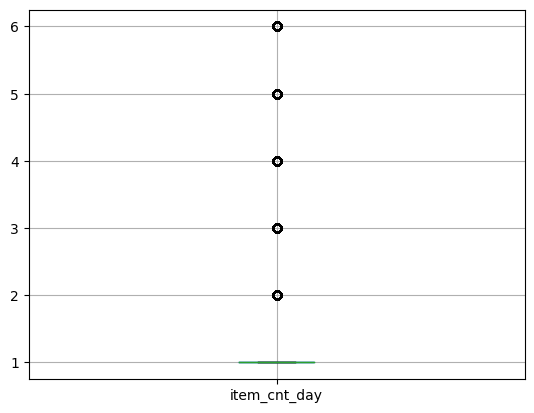

In [205]:
df2.boxplot('item_cnt_day')

<AxesSubplot:>

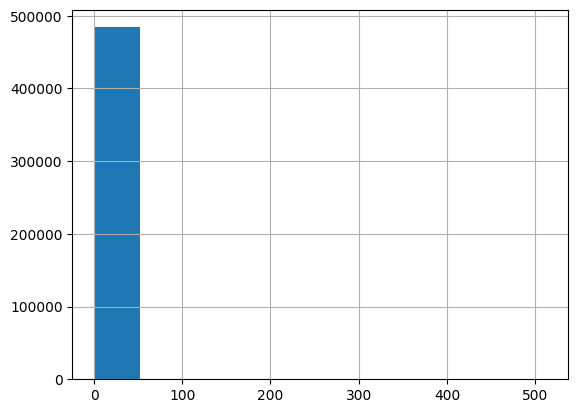

In [206]:
df.item_cnt_day.hist(bins=10)

In [207]:
print(len(df[df.item_cnt_day >= 7]))
print( len(df[df.item_cnt_day < 7] ))

3643
480486


In [208]:
print(3643/484129*100)
#0,75% of the dataset are outliers for "item_cnt_day"

0.752485391290338


<AxesSubplot:>

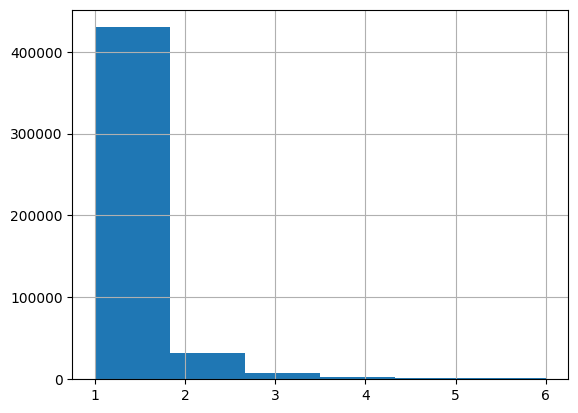

In [209]:
df2.item_cnt_day.hist(bins=6)

In [210]:
mean_cnt2 = df2.item_cnt_day.mean()
median_cnt2 = df2.item_cnt_day.median()

print('mean:' + str(mean_cnt2))
print('median:' + str(median_cnt2))

mean:1.1481984244225019
median:1.0


In [211]:
df.loc[outliers2.index,'item_cnt_day']=median_cnt2

In [212]:
df['item_cnt_day'].mean()

1.1480597113579232

#save dataset

In [213]:
df.to_csv('../Dataset/dfNoOutliers.csv')

In [214]:
df = pd.read_csv('../Dataset/dfNoOutliers.csv', skipinitialspace=True, sep=',')
df = df.set_index('index')

# e) Indicators

## I - total item purchased

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484129 entries, 32632 to 1263632
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                484129 non-null  object 
 1   shop_id             484129 non-null  float64
 2   item_id             484129 non-null  float64
 3   item_price          484129 non-null  float64
 4   item_cnt_day        484129 non-null  float64
 5   user_id             484129 non-null  float64
 6   basket_id           484129 non-null  object 
 7   item_name           484129 non-null  object 
 8   item_category_id    484129 non-null  float64
 9   item_category_name  484129 non-null  object 
dtypes: float64(6), object(4)
memory usage: 40.6+ MB


In [216]:
Totalcnt=df.groupby('user_id')['item_cnt_day'].sum()
Totalcnt=pd.DataFrame({'user_id':Totalcnt.index, 'I': Totalcnt.values} )

In [217]:
Totalcnt

,user_id,I
0,1.0,717.0
1,2.0,898.0
2,3.0,409.0
3,4.0,909.0
4,5.0,806.0
...,...,...
819,820.0,771.0
820,821.0,635.0
821,822.0,649.0
822,823.0,640.0


## Iu - total distinct items purchased

In [218]:
df.groupby('user_id')['item_id'].nunique()

user_id
1.0      484
2.0      569
3.0      276
4.0      568
5.0      516
        ... 
820.0    507
821.0    407
822.0    440
823.0    428
824.0      3
Name: item_id, Length: 824, dtype: int64

In [219]:
df[df['user_id']==824]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
290750,2013-03-01 00:00:00,22.0,-1.0,349.0,1.0,824.0,B2824,Unknown,-1.0,Unknown
290006,2013-03-01 00:00:00,22.0,9460.0,350.0,1.0,824.0,B2824,Бухгалтерский и налоговый учет в 1С:Бухгалтери...,49.0,Книги - Методические материалы 1С
290614,2013-03-01 00:00:00,22.0,-1.0,149.0,1.0,824.0,B2824,Unknown,-1.0,Unknown
291389,2013-03-01 00:00:00,22.0,-1.0,498.0,1.0,824.0,B2824,Unknown,-1.0,Unknown
290470,2013-03-01 00:00:00,22.0,16125.0,589.0,1.0,824.0,B2824,Настольная игра Кингс Баунти (King's Bounty) а...,64.0,Подарки - Настольные игры


In [220]:
uniqueKnown = (df.drop(df[df['item_id']==-1].index).groupby('user_id')['item_id'].nunique()).to_frame()
uniqueUn = (df.drop(df[df['item_id']!=-1].index).groupby('user_id')['item_id'].count()).to_frame()
TotalUnique = pd.merge(uniqueKnown, uniqueUn, on='user_id')
TotalUnique['Iu'] = TotalUnique['item_id_x'] + TotalUnique['item_id_y']
TotalUnique = TotalUnique.rename(columns={'item_id_x':'count_uniqueKnown','item_id_y':'count_uniqueUn'})

## Imax - max items purchased in a single shopping session

In [221]:
TotalImax = ( (df.groupby(['user_id','basket_id'])['item_cnt_day'].sum()).to_frame() ).groupby('user_id').max()
TotalImax = TotalImax.rename(columns={'item_cnt_day':'Imax'})

In [222]:
#check
df[df['user_id']==133]

,date,shop_id,item_id,item_price,item_cnt_day,user_id,basket_id,item_name,item_category_id,item_category_name
index,,,,,,,,,,
1274599,2014-01-01 00:00:00,51.0,12132.0,1403.0,1.0,133.0,B52133,Игровой набор микророботов Нано V2 харикейн сэт,62.0,"Подарки - Гаджеты, роботы, спорт"
1315517,2014-01-01 00:00:00,51.0,-1.0,734.0,1.0,133.0,B52133,Unknown,-1.0,Unknown
1274466,2014-01-01 00:00:00,51.0,12542.0,75.0,1.0,133.0,B52133,КЛАССИКА Классика для релаксации 2,55.0,Музыка - CD локального производства
1275778,2014-01-01 00:00:00,51.0,18539.0,119.0,1.0,133.0,B52133,"СВАТЫ 1,2,3 (ПОЛНАЯ ВЕРСИЯ)",40.0,Кино - DVD
1315425,2014-01-01 00:00:00,51.0,5257.0,636.0,1.0,133.0,B52133,"Need for Speed The Run (Classics) [Xbox 360, р...",23.0,Игры - XBOX 360
...,...,...,...,...,...,...,...,...,...,...
1258944,2013-12-06 00:00:00,45.0,3708.0,2299.0,2.0,133.0,B8236818,"Gran Turismo 6 [PS3, русская версия]",19.0,Игры - PS3
1260558,2013-12-06 00:00:00,45.0,5237.0,2599.0,1.0,133.0,B8236818,"Need for Speed Rivals Limited Edition [PS4, ру...",20.0,Игры - PS4
1265904,2013-12-06 00:00:00,45.0,21963.0,1499.0,1.0,133.0,B8236818,Шар-лабиринт Perplexus Epic (125 барьеров),67.0,Подарки - Развитие


## IAvg - mean items purchased in a single shopping session

In [223]:
meanIavg = ( (df.groupby(['user_id','basket_id'])['item_cnt_day'].sum()).to_frame() ).groupby('user_id').mean()
meanIavg = meanIavg.rename(columns={'item_cnt_day':'IAvg'})

## Entropy

In [224]:
import collections
from scipy.stats import entropy
def Shannon(values):
  n=len(values)
  index=collections.Counter([v for v in values])
  shanv=0
  for i in index:
    val=index[i]
    probi=val/float(n)
    entropy=probi*(math.log(probi, 2))
    shanv= shanv+ entropy
  if shanv == 0:
      return 0;
  else:
      return shanv * -1

In [225]:
df.groupby('user_id').item_category_id.apply(Shannon)

user_id
1.0      4.124480
2.0      4.113632
3.0      4.099186
4.0      4.051440
5.0      4.088003
           ...   
820.0    4.320221
821.0    4.088165
822.0    4.219524
823.0    4.125628
824.0    1.370951
Name: item_category_id, Length: 824, dtype: float64

Entropy of the item id

In [226]:
Eb3=df.groupby('user_id').item_id.apply(Shannon)
Eb3=pd.DataFrame(Eb3)
Eb3

,item_id
user_id,
1.0,7.843976
2.0,8.042663
3.0,7.208510
4.0,8.118060
5.0,7.906951
...,...
820.0,8.086788
821.0,7.722489
822.0,7.837770


Entropy of the category id

In [227]:
df.info()
Ebc=df.groupby("user_id").item_category_id.apply(Shannon)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484129 entries, 32632 to 1263632
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                484129 non-null  object 
 1   shop_id             484129 non-null  float64
 2   item_id             484129 non-null  float64
 3   item_price          484129 non-null  float64
 4   item_cnt_day        484129 non-null  float64
 5   user_id             484129 non-null  float64
 6   basket_id           484129 non-null  object 
 7   item_name           484129 non-null  object 
 8   item_category_id    484129 non-null  float64
 9   item_category_name  484129 non-null  object 
dtypes: float64(6), object(4)
memory usage: 56.8+ MB


In [228]:
Ebc

user_id
1.0      4.124480
2.0      4.113632
3.0      4.099186
4.0      4.051440
5.0      4.088003
           ...   
820.0    4.320221
821.0    4.088165
822.0    4.219524
823.0    4.125628
824.0    1.370951
Name: item_category_id, Length: 824, dtype: float64

## Amount mean, min, max
For every user we calculate the min, max and average amount spent

In [229]:
df['total_amount_item'] = df['item_price']*df['item_cnt_day']
DFmeanAmount = ( ((df.groupby(['user_id','basket_id'])['total_amount_item'].sum()).to_frame()).groupby('user_id').total_amount_item.mean() ).to_frame()
DFmaxAmount= ( ((df.groupby(['user_id','basket_id'])['total_amount_item'].sum()).to_frame()).groupby('user_id').total_amount_item.max() ).to_frame()
DFminAmount = ( ((df.groupby(['user_id','basket_id'])['total_amount_item'].sum()).to_frame()).groupby('user_id').total_amount_item.min()).to_frame()

#DFtotalAmount
DFtotalAmount = (df.groupby(['user_id'])['total_amount_item'].sum()).to_frame()

## Unique basket

In [230]:
DFuniqueBasket = (df.groupby('user_id').basket_id.nunique()).to_frame()

## Time indicators (monthly spending, year spending)

array([[<AxesSubplot:title={'center':'total_amount_item'}>]], dtype=object)

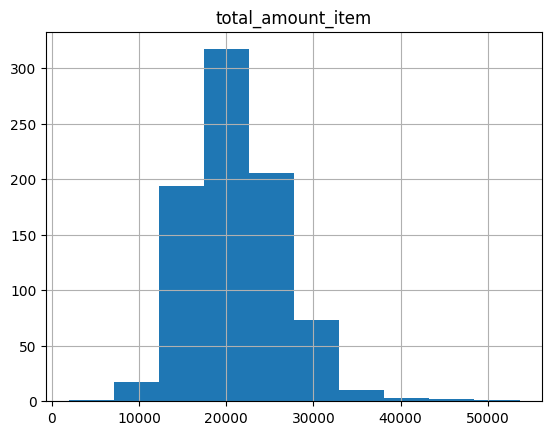

In [231]:
df['date'] = pd.to_datetime(df['date'])
d1 = df.groupby( ['user_id', df['date'].dt.strftime('%m/%Y')])['total_amount_item'].sum().sort_values().to_frame()
avg_amount = d1.groupby('user_id')['total_amount_item'].mean().to_frame()
avg_amount.hist()

In [232]:
DFavg_month_spending = avg_amount

In [233]:
dateMin = df.groupby('user_id')['date'].min().to_frame()
dateMax = df.groupby('user_id')['date'].max().to_frame()
dateMin = dateMin.rename(columns={'date':'minDate'})
dateMin = dateMin.merge(dateMax, on='user_id')

In [234]:
dateMin['monthDiff'] = ( (dateMin.date - dateMin.minDate)/np.timedelta64(1, 'M'))
dateMin['monthDiff'] = dateMin['monthDiff'].astype(int)
t1 = ( df.groupby( ['user_id', df['date'].dt.strftime('%m/%Y')])['date'].count()).to_frame()
activeMonths = t1.groupby('user_id').nunique('date')
compareMonths = dateMin.merge(activeMonths, on='user_id')

In [235]:
compareMonths[compareMonths['date_y'] > compareMonths['monthDiff']]

,minDate,date_x,monthDiff,date_y
user_id,,,,
824.0,2013-03-01,2013-03-01,0,1


## Standard Deviation

In [236]:
std_Amount=( ((df.groupby(['user_id','basket_id'])['total_amount_item'].sum()).to_frame()).groupby('user_id').total_amount_item.std()).to_frame()
std_Amount.fillna(-1,inplace=True)

## Profile Definition

In [237]:
DFmeanAmount = DFmeanAmount.rename(columns={'total_amount_item':'meanAmount_BSKT'})
DFmaxAmount = DFmaxAmount.rename(columns={'total_amount_item':'maxAmount_BSKT'})
DFminAmount = DFminAmount.rename(columns={'total_amount_item':'minAmount_BSKT'})
DFuniqueBasket = DFuniqueBasket.rename(columns={'basket_id':'unique_baskets'})
DFtotalAmount = DFtotalAmount.rename(columns={'total_amount_item':'totalAmount'})
DFavg_month_spending = DFavg_month_spending.rename(columns={'total_amount_item':'avg_month_spent'})
std_Amount=std_Amount.rename(columns={'total_amount_item':'stdAmount_BSKT'})

In [238]:

Profile = pd.merge(TotalImax, TotalUnique.drop(columns=['count_uniqueKnown', 'count_uniqueUn']), on='user_id', how='left' )
Profile = Profile.merge(Totalcnt, on='user_id',how='left')
Profile = Profile.merge(meanIavg, on='user_id',how='left')
Profile = Profile.merge(DFmeanAmount, on='user_id',how='left')
Profile = Profile.merge(DFmaxAmount, on='user_id',how='left')
Profile = Profile.merge(DFminAmount, on='user_id',how='left')
Profile = Profile.merge(DFuniqueBasket, on='user_id',how='left')
Profile = Profile.merge(DFtotalAmount, on='user_id',how='left')
Profile = Profile.merge(Eb3, on='user_id', how='left')
Profile = Profile.rename(columns={'item_id':'entropy_itemID'})
Profile = Profile.merge(Ebc, on='user_id', how='left')
Profile = Profile.rename(columns={'item_category_id':'entropy_CategoryID'})
Profile = Profile.merge(DFavg_month_spending, on='user_id', how='left')
Profile= Profile.merge(std_Amount, on='user_id',how='left')

In [239]:
Profile

,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT
0,1.0,151.0,609,717.0,11.564516,7976.434672,83044.757624,5.000000,62,494538.949643,7.843976,4.124480,21501.693463,14377.761175
1,2.0,135.0,715,898.0,10.441860,7867.247483,83071.213484,10.000000,86,676583.283530,8.042663,4.113632,27063.331341,13835.276391
2,3.0,60.0,345,409.0,8.346939,7685.739820,64478.756945,49.000000,49,376601.251181,7.208510,4.099186,16373.967443,11745.877637
3,4.0,209.0,705,909.0,13.984615,9726.515000,123667.785452,140.507317,65,632223.474988,8.118060,4.051440,28737.430681,20357.971933
4,5.0,99.0,653,806.0,12.029851,9265.088309,70779.128314,28.000000,67,620760.916704,7.906951,4.088003,26989.605074,17104.844364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,820.0,87.0,615,771.0,11.173913,8649.109739,88948.983643,5.000000,69,596788.571962,8.086788,4.320221,24866.190498,15832.609982
820,821.0,75.0,505,635.0,9.338235,6614.912725,58318.344132,58.000000,68,449814.065317,7.722489,4.088165,16659.780197,10827.521190
821,822.0,90.0,544,649.0,9.686567,6441.238846,48346.024241,99.000000,67,431563.002704,7.837770,4.219524,17981.791779,8990.527177
822,823.0,70.0,528,640.0,9.411765,7498.550580,54058.895126,5.000000,68,509901.439472,7.815971,4.125628,19611.593826,9945.858973


In [240]:
Profile['stdMean_ratio'] =abs(Profile['stdAmount_BSKT']/Profile['meanAmount_BSKT'])

In [241]:
Profile['totalAmount_factor'] = Profile.stdMean_ratio*Profile.totalAmount

#f) Indicators analysis (distribution, visualization, correlation ecc.)

In [242]:
Profile.drop(columns=['user_id']).describe()

,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,8.240000e+02,824.000000,824.000000,824.000000,824.000000,824.000000,8.240000e+02
mean,101.737864,548.356796,674.525485,9.985629,7503.680875,77781.200524,68.810689,67.190534,5.065209e+05,7.802594,4.190130,21110.748971,13226.387687,1.718378,9.048594e+05
std,56.852171,136.812583,182.672364,1.675316,1389.860815,51598.852911,84.677379,12.655021,1.410825e+05,0.388762,0.153583,5397.309252,5745.370824,0.434957,4.750897e+05
min,5.000000,5.000000,5.000000,5.000000,1935.000000,1935.000000,0.100000,1.000000,1.935000e+03,1.370951,1.370951,1935.000000,-1.000000,0.000517,1.000000e+00
25%,62.000000,452.750000,550.000000,8.832547,6522.949304,47593.697100,10.000000,59.000000,4.106950e+05,7.614830,4.118478,17287.368422,9776.543395,1.445040,6.100057e+05
50%,87.000000,531.000000,651.000000,9.760582,7360.301656,64232.267204,61.000000,66.500000,4.859719e+05,7.824141,4.197649,20367.825950,11932.259911,1.634285,7.901286e+05
75%,127.000000,634.000000,783.000000,11.036045,8299.025032,91375.847550,99.000000,75.000000,5.969894e+05,8.039248,4.272263,24384.269826,15034.716966,1.894656,1.084549e+06
max,509.000000,1206.000000,1595.000000,17.622222,14318.475342,530553.500767,1935.000000,112.000000,1.249280e+06,8.841956,4.524700,53637.661391,57531.614949,4.105653,5.129109e+06


In [243]:
Profile.drop(columns=['user_id']).median()

Imax                      87.000000
Iu                       531.000000
I                        651.000000
IAvg                       9.760582
meanAmount_BSKT         7360.301656
maxAmount_BSKT         64232.267204
minAmount_BSKT            61.000000
unique_baskets            66.500000
totalAmount           485971.891029
entropy_itemID             7.824141
entropy_CategoryID         4.197649
avg_month_spent        20367.825950
stdAmount_BSKT         11932.259911
stdMean_ratio              1.634285
totalAmount_factor    790128.622037
dtype: float64

array([[<AxesSubplot:title={'center':'Imax'}>,
        <AxesSubplot:title={'center':'Iu'}>,
        <AxesSubplot:title={'center':'I'}>,
        <AxesSubplot:title={'center':'IAvg'}>],
       [<AxesSubplot:title={'center':'meanAmount_BSKT'}>,
        <AxesSubplot:title={'center':'maxAmount_BSKT'}>,
        <AxesSubplot:title={'center':'minAmount_BSKT'}>,
        <AxesSubplot:title={'center':'unique_baskets'}>],
       [<AxesSubplot:title={'center':'totalAmount'}>,
        <AxesSubplot:title={'center':'entropy_itemID'}>,
        <AxesSubplot:title={'center':'entropy_CategoryID'}>,
        <AxesSubplot:title={'center':'avg_month_spent'}>],
       [<AxesSubplot:title={'center':'stdAmount_BSKT'}>,
        <AxesSubplot:title={'center':'stdMean_ratio'}>,
        <AxesSubplot:title={'center':'totalAmount_factor'}>,
        <AxesSubplot:>]], dtype=object)

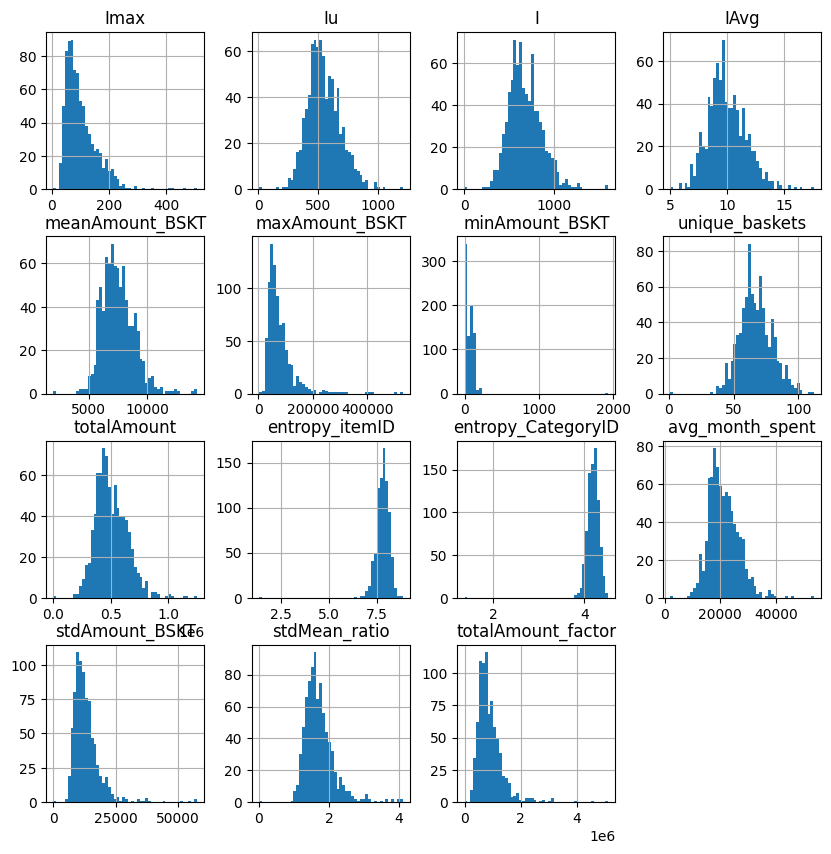

In [244]:
Profile.drop(columns=['user_id']).hist(bins=50, figsize = (10,10))

<AxesSubplot:>

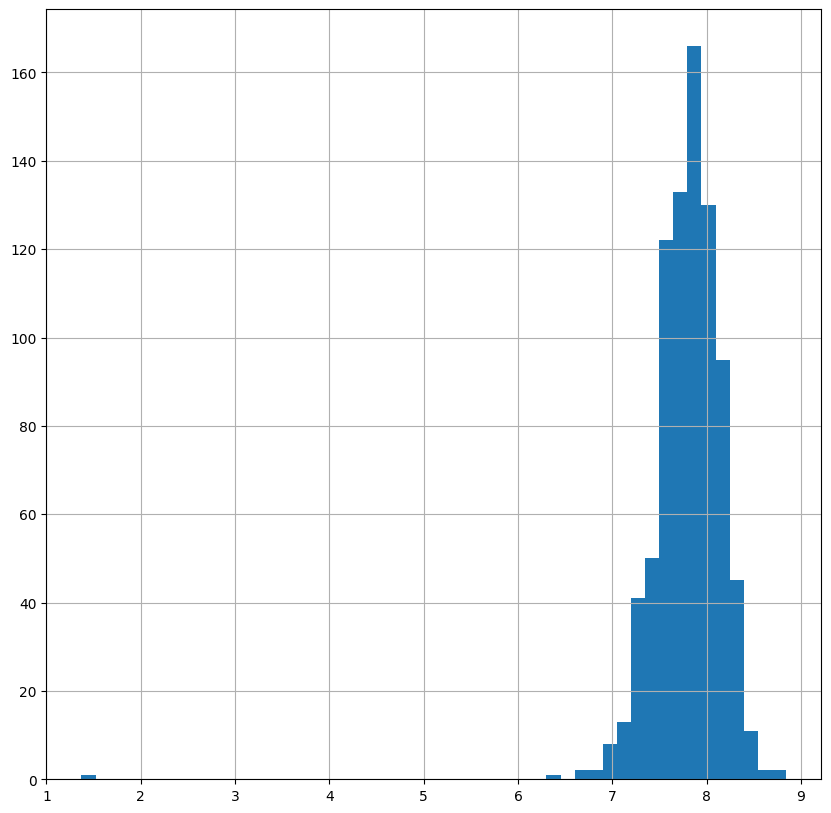

In [245]:
Profile.entropy_itemID.hist(bins=50, figsize = (10,10))

<AxesSubplot:>

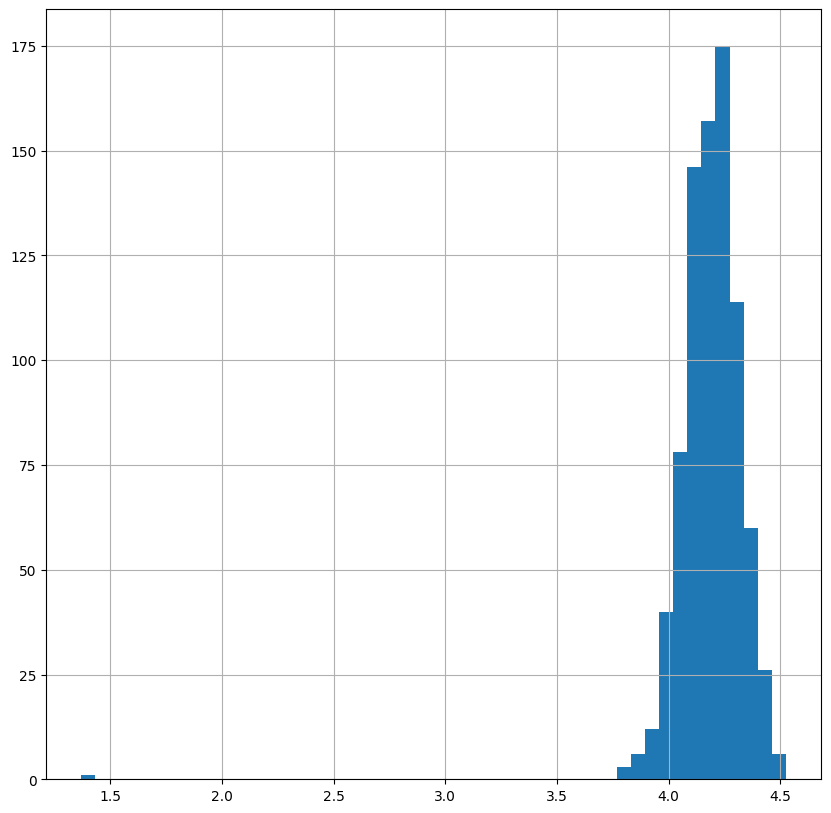

In [246]:
Profile.entropy_CategoryID.hist(bins=50, figsize = (10,10))

<AxesSubplot:>

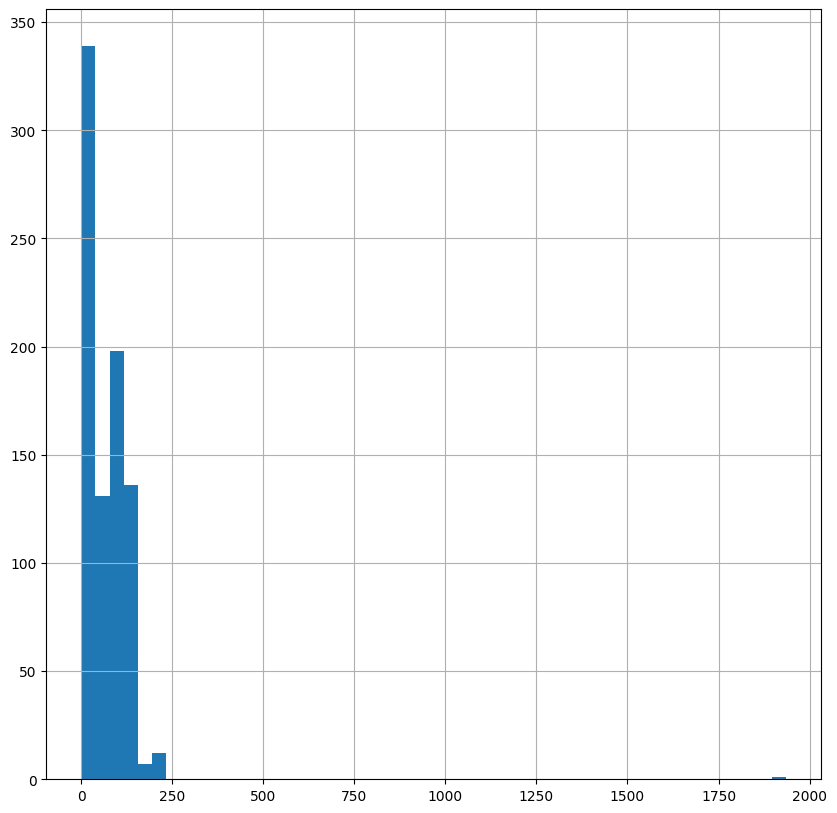

In [247]:
Profile.minAmount_BSKT.hist(bins=50, figsize = (10,10))

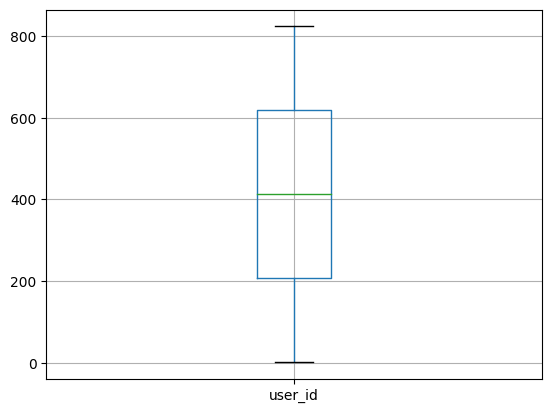

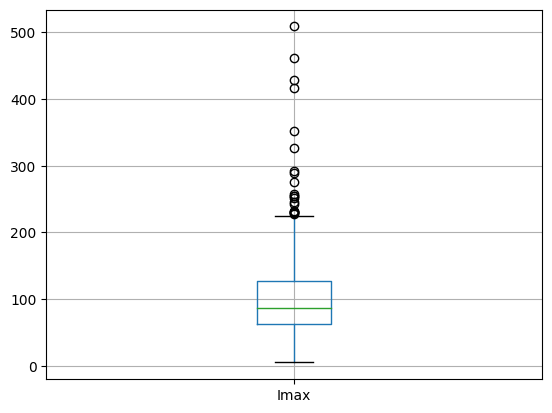

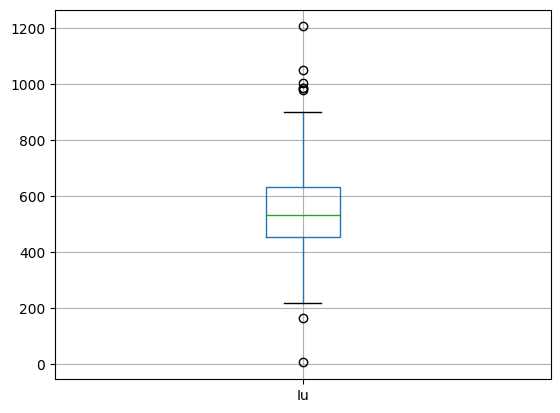

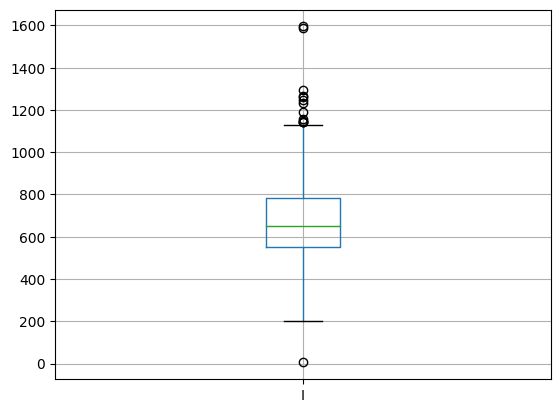

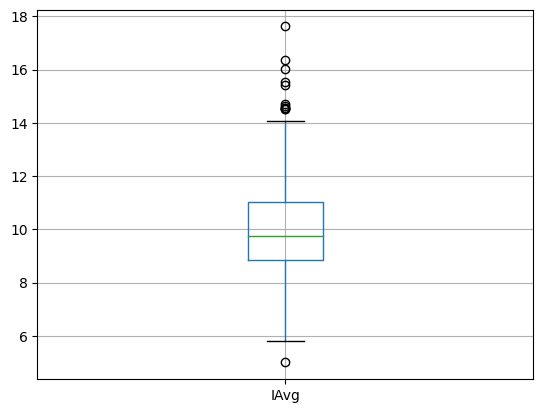

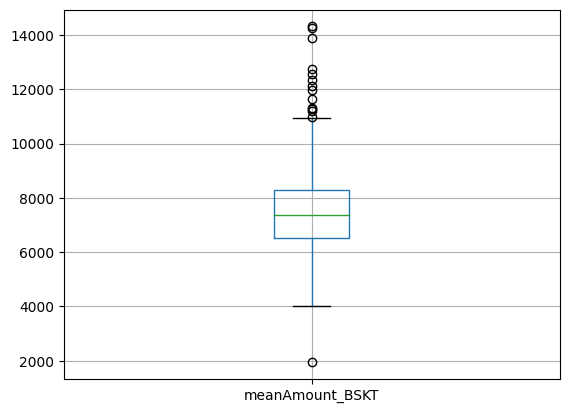

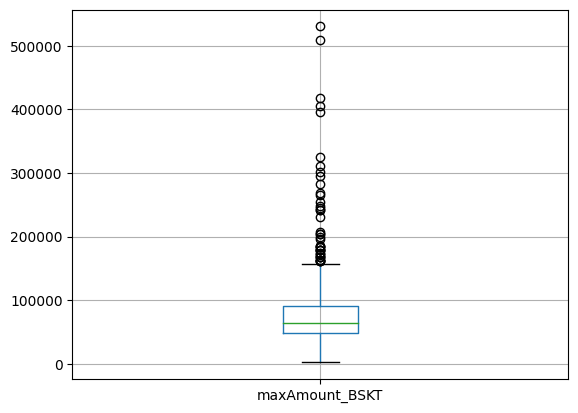

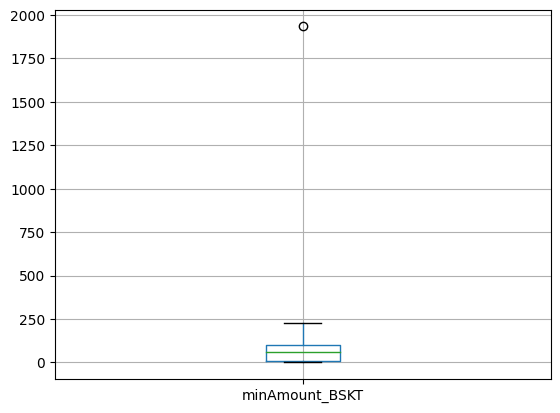

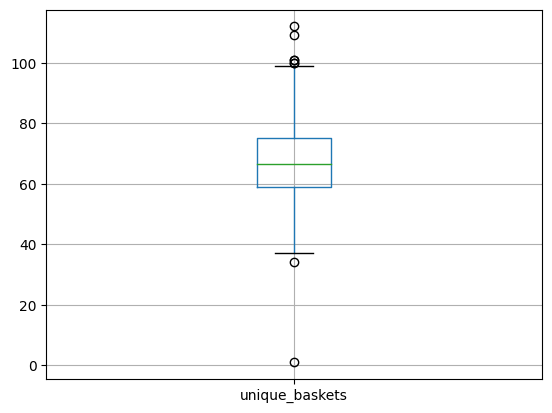

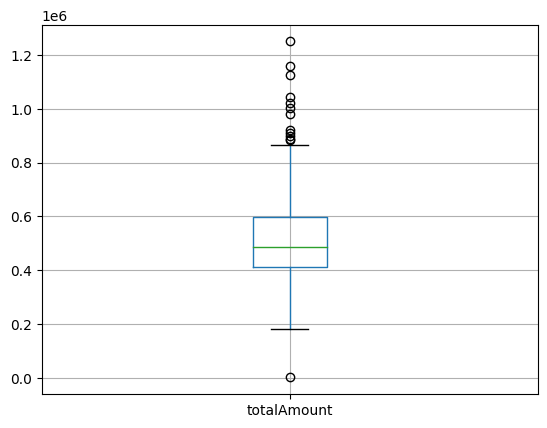

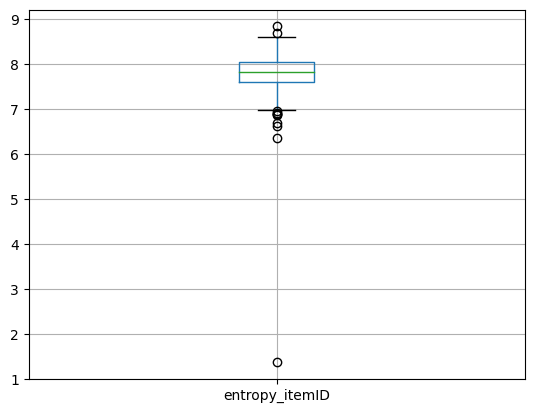

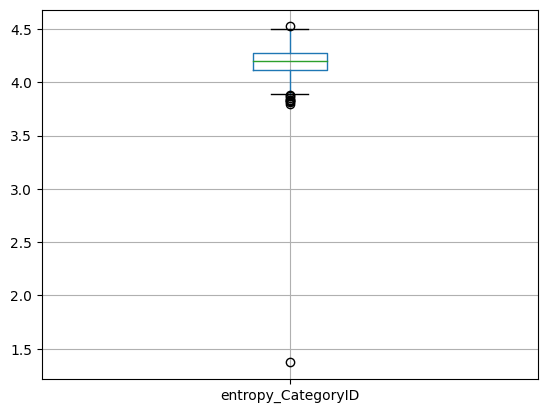

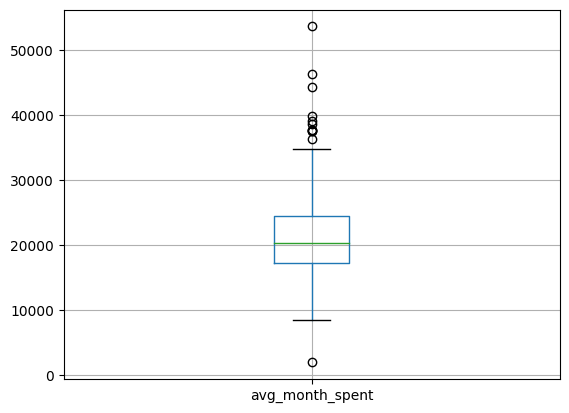

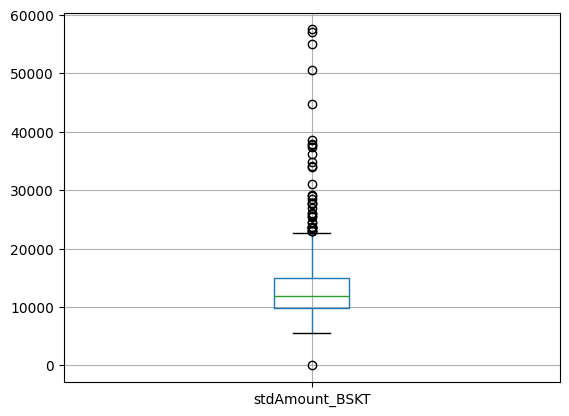

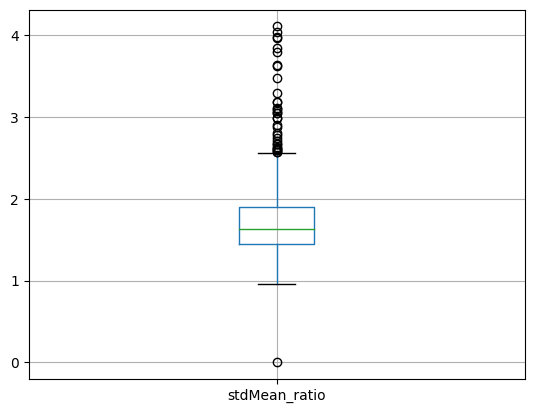

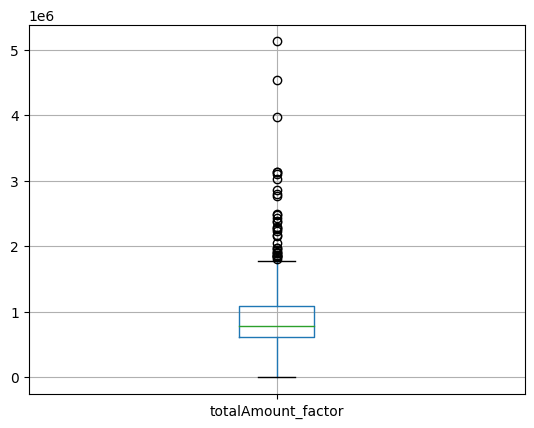

In [248]:
import matplotlib.pyplot as plt

for column in Profile:
    plt.figure()
    Profile.boxplot([column])



# g) Outliers on indicators

## Imax

In [249]:
Q1 = Profile['Imax'].quantile(0.25)
Q3 = Profile['Imax'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['Imax'] < (Q1 - 1.5 * IQR) ) | (Profile['Imax'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
10,11.0,326.0,546,809.0,12.446154,10305.623172,301119.315415,10.000000,65,6.698655e+05,7.836945,4.345932,26794.620246,37465.615919,3.635454,2.435265e+06
137,138.0,242.0,867,1188.0,13.054945,11199.420625,295177.630451,58.000000,91,1.019147e+06,8.495615,4.431989,44310.751169,34094.434080,3.044303,3.102594e+06
175,176.0,230.0,708,933.0,11.378049,9354.984909,253753.071591,28.000000,82,7.671088e+05,7.982909,4.207421,29504.183174,29128.971923,3.113738,2.388576e+06
178,179.0,254.0,660,802.0,11.794118,8238.774282,167977.352198,139.000000,68,5.602367e+05,8.054316,4.229517,24358.115270,21459.411571,2.604685,1.459240e+06
191,192.0,509.0,1050,1586.0,17.622222,13880.884603,530553.500767,89.726027,90,1.249280e+06,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
207,208.0,462.0,865,1293.0,16.367089,14258.112522,508857.853504,99.000000,79,1.126391e+06,8.330002,4.271943,53637.661391,57531.614949,4.035009,4.544998e+06
225,226.0,229.0,788,980.0,13.424658,9512.417313,125162.007568,5.000000,73,6.944065e+05,8.311888,4.223158,31563.930174,18986.381364,1.995958,1.386006e+06
254,255.0,231.0,750,1033.0,11.228261,9612.842031,242045.366710,58.000000,92,8.843815e+05,8.290618,4.276018,31585.052388,26882.521128,2.796522,2.473192e+06
473,474.0,232.0,766,994.0,16.032258,11970.209538,142287.002410,149.000000,62,7.421530e+05,8.175839,4.265364,39060.683755,27743.640861,2.317724,1.720106e+06
481,482.0,228.0,878,1086.0,11.431579,8222.235055,111600.933281,4.916589,95,7.811123e+05,8.361941,4.197612,27896.868936,14522.508612,1.766248,1.379638e+06


In [250]:
Profile.loc[quantile_out.index, 'Imax'] = Profile.Imax.mean()

## I

In [251]:
Q1 = Profile['I'].quantile(0.25)
Q3 = Profile['I'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['I'] < (Q1 - 1.5 * IQR) ) | (Profile['I'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
90,91.0,175.000000,987,1233.0,13.258065,8729.857693,94162.210909,99.000000,93,8.118768e+05,8.361735,4.118872,31226.029439,17567.203372,2.012313,1.633750e+06
137,138.0,101.737864,867,1188.0,13.054945,11199.420625,295177.630451,58.000000,91,1.019147e+06,8.495615,4.431989,44310.751169,34094.434080,3.044303,3.102594e+06
191,192.0,101.737864,1050,1586.0,17.622222,13880.884603,530553.500767,89.726027,90,1.249280e+06,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
207,208.0,101.737864,865,1293.0,16.367089,14258.112522,508857.853504,99.000000,79,1.126391e+06,8.330002,4.271943,53637.661391,57531.614949,4.035009,4.544998e+06
283,284.0,224.000000,900,1143.0,11.316832,8776.073183,146444.702747,15.000000,101,8.863834e+05,8.455449,4.351175,32829.014498,20356.375122,2.319531,2.055994e+06
299,300.0,163.000000,979,1263.0,11.276786,8765.467918,150104.532084,5.000000,112,9.817324e+05,8.532138,4.295224,37758.938723,21238.007428,2.422918,2.378657e+06
350,351.0,194.000000,986,1248.0,12.480000,10438.303580,153437.187609,0.100000,100,1.043830e+06,8.552579,4.404820,34794.345266,22715.374306,2.176156,2.271537e+06
564,565.0,101.737864,1206,1595.0,14.633028,10610.630988,184666.738076,20.000000,109,1.156559e+06,8.841956,4.335270,39881.337162,25407.782909,2.394559,2.769448e+06
570,571.0,216.000000,1005,1264.0,14.528736,10310.607600,138488.698557,69.000000,87,8.970229e+05,8.700711,4.179069,30931.822800,22691.616879,2.200803,1.974171e+06
583,584.0,101.737864,809,1158.0,13.011236,11264.403194,417474.002114,99.000000,89,1.002532e+06,8.079559,4.218480,38558.918627,44699.648118,3.968222,3.978269e+06


In [252]:
Profile.loc[quantile_out.index, 'I'] = Profile.I.mean()

## Iu

In [253]:
Q1 = Profile['Iu'].quantile(0.25)
Q3 = Profile['Iu'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['Iu'] < (Q1 - 1.5 * IQR) ) | (Profile['Iu'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
90,91.0,175.000000,987,674.525485,13.258065,8729.857693,94162.210909,99.000000,93,8.118768e+05,8.361735,4.118872,31226.029439,17567.203372,2.012313,1.633750e+06
191,192.0,101.737864,1050,674.525485,17.622222,13880.884603,530553.500767,89.726027,90,1.249280e+06,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
299,300.0,163.000000,979,674.525485,11.276786,8765.467918,150104.532084,5.000000,112,9.817324e+05,8.532138,4.295224,37758.938723,21238.007428,2.422918,2.378657e+06
350,351.0,194.000000,986,674.525485,12.480000,10438.303580,153437.187609,0.100000,100,1.043830e+06,8.552579,4.404820,34794.345266,22715.374306,2.176156,2.271537e+06
564,565.0,101.737864,1206,674.525485,14.633028,10610.630988,184666.738076,20.000000,109,1.156559e+06,8.841956,4.335270,39881.337162,25407.782909,2.394559,2.769448e+06
570,571.0,216.000000,1005,674.525485,14.528736,10310.607600,138488.698557,69.000000,87,8.970229e+05,8.700711,4.179069,30931.822800,22691.616879,2.200803,1.974171e+06
779,780.0,27.000000,165,201.000000,5.911765,5950.564663,29719.500000,15.000000,34,2.023192e+05,6.365422,4.271758,12644.949908,8010.743666,1.346216,2.723653e+05
823,824.0,5.000000,5,674.525485,5.000000,1935.000000,1935.000000,1935.000000,1,1.935000e+03,1.370951,1.370951,1935.000000,-1.000000,0.000517,1.000000e+00


In [254]:
Profile.loc[quantile_out.index, 'Iu'] = Profile.Iu.mean()

## Iavg

In [255]:
Q1 = Profile['IAvg'].quantile(0.25)
Q3 = Profile['IAvg'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['IAvg'] < (Q1 - 1.5 * IQR) ) | (Profile['IAvg'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
191,192.0,101.737864,548.356796,674.525485,17.622222,13880.884603,530553.500767,89.726027,90,1.249280e+06,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,16.367089,14258.112522,508857.853504,99.000000,79,1.126391e+06,8.330002,4.271943,53637.661391,57531.614949,4.035009,4.544998e+06
270,271.0,181.000000,887.000000,1118.000000,14.710526,9431.807464,108137.106285,5.000000,76,7.168174e+05,8.464574,4.148152,29867.390303,18319.428892,1.942303,1.392277e+06
287,288.0,200.000000,635.000000,762.000000,15.551020,9996.036372,101488.706740,65.000000,49,4.898058e+05,7.948759,3.950799,24490.289110,18937.388894,1.894490,9.279321e+05
321,322.0,218.000000,802.000000,991.000000,14.573529,10466.471487,163670.113451,4.800000,68,7.117201e+05,8.319381,4.213464,37458.950584,24510.728776,2.341833,1.666730e+06
396,397.0,195.000000,663.000000,803.000000,15.442308,10592.840299,99680.899700,5.000000,52,5.508277e+05,8.029334,4.184973,22951.153982,17593.678310,1.660903,9.148713e+05
473,474.0,101.737864,766.000000,994.000000,16.032258,11970.209538,142287.002410,149.000000,62,7.421530e+05,8.175839,4.265364,39060.683755,27743.640861,2.317724,1.720106e+06
564,565.0,101.737864,548.356796,674.525485,14.633028,10610.630988,184666.738076,20.000000,109,1.156559e+06,8.841956,4.335270,39881.337162,25407.782909,2.394559,2.769448e+06
570,571.0,216.000000,548.356796,674.525485,14.528736,10310.607600,138488.698557,69.000000,87,8.970229e+05,8.700711,4.179069,30931.822800,22691.616879,2.200803,1.974171e+06
633,634.0,147.000000,670.000000,856.000000,14.508475,9497.884390,90541.283495,149.000000,59,5.603752e+05,7.831515,4.268920,24364.138219,16553.477584,1.742859,9.766552e+05


In [256]:
Profile.loc[quantile_out.index, 'IAvg'] = Profile.IAvg.mean()

## Amount (mean, min, max)

meanAmount

In [257]:
Q1 = Profile['meanAmount_BSKT'].quantile(0.25)
Q3 = Profile['meanAmount_BSKT'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['meanAmount_BSKT'] < (Q1 - 1.5 * IQR) ) | (Profile['meanAmount_BSKT'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
137,138.0,101.737864,867.000000,674.525485,13.054945,11199.420625,295177.630451,58.000000,91,1.019147e+06,8.495615,4.431989,44310.751169,34094.434080,3.044303,3.102594e+06
191,192.0,101.737864,548.356796,674.525485,9.985629,13880.884603,530553.500767,89.726027,90,1.249280e+06,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,9.985629,14258.112522,508857.853504,99.000000,79,1.126391e+06,8.330002,4.271943,53637.661391,57531.614949,4.035009,4.544998e+06
428,429.0,196.000000,497.000000,652.000000,13.040000,12343.533439,269241.527841,110.000000,50,6.171767e+05,7.595493,4.340021,29389.365330,37954.112556,3.074817,1.897706e+06
473,474.0,101.737864,766.000000,994.000000,9.985629,11970.209538,142287.002410,149.000000,62,7.421530e+05,8.175839,4.265364,39060.683755,27743.640861,2.317724,1.720106e+06
523,524.0,101.737864,520.000000,855.000000,13.790323,12735.764905,395761.427051,10.000000,62,7.896174e+05,8.134617,4.524700,37600.829720,50649.213294,3.976927,3.140251e+06
529,530.0,170.000000,683.000000,871.000000,13.000000,11323.323091,156274.817428,99.000000,67,7.586626e+05,8.074970,4.155674,31610.943630,23684.029084,2.091615,1.586830e+06
532,533.0,204.000000,790.000000,1002.000000,13.726027,10966.851104,161187.643515,46.700000,73,8.005801e+05,8.208456,4.228273,32023.205225,23766.321874,2.167105,1.734941e+06
583,584.0,101.737864,809.000000,674.525485,13.011236,11264.403194,417474.002114,99.000000,89,1.002532e+06,8.079559,4.218480,38558.918627,44699.648118,3.968222,3.978269e+06
673,674.0,101.737864,514.000000,746.000000,13.563636,14318.475342,405320.820853,229.000000,55,7.875161e+05,7.832912,4.249791,31500.645752,54951.823973,3.837826,3.022350e+06


In [258]:
Profile.loc[quantile_out.index, 'meanAmount_BSKT'] = Profile.meanAmount_BSKT.mean()

maxAmount

In [259]:
Q1 = Profile['maxAmount_BSKT'].quantile(0.25)
Q3 = Profile['maxAmount_BSKT'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['maxAmount_BSKT'] < (Q1 - 1.5 * IQR) ) | (Profile['maxAmount_BSKT'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
10,11.0,101.737864,546.000000,809.000000,12.446154,10305.623172,301119.315415,10.000000,65,6.698655e+05,7.836945,4.345932,26794.620246,37465.615919,3.635454,2.435265e+06
43,44.0,162.000000,560.000000,708.000000,11.606557,9498.787752,173060.192870,69.000000,61,5.794261e+05,7.794417,4.145786,26337.547856,23609.976766,2.485578,1.440209e+06
87,88.0,158.000000,689.000000,907.000000,12.093333,9843.669979,203478.042087,99.000000,75,7.382752e+05,7.994696,4.286297,28395.201864,25906.996849,2.631843,1.943025e+06
137,138.0,101.737864,867.000000,674.525485,13.054945,7503.680875,295177.630451,58.000000,91,1.019147e+06,8.495615,4.431989,44310.751169,34094.434080,3.044303,3.102594e+06
175,176.0,101.737864,708.000000,933.000000,11.378049,9354.984909,253753.071591,28.000000,82,7.671088e+05,7.982909,4.207421,29504.183174,29128.971923,3.113738,2.388576e+06
177,178.0,171.000000,509.000000,634.000000,9.188406,7850.771734,185533.369442,20.000000,69,5.417032e+05,7.654076,4.368122,22570.968735,23446.559230,2.986529,1.617813e+06
178,179.0,101.737864,660.000000,802.000000,11.794118,8238.774282,167977.352198,139.000000,68,5.602367e+05,8.054316,4.229517,24358.115270,21459.411571,2.604685,1.459240e+06
191,192.0,101.737864,548.356796,674.525485,9.985629,7503.680875,530553.500767,89.726027,90,1.249280e+06,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,9.985629,7503.680875,508857.853504,99.000000,79,1.126391e+06,8.330002,4.271943,53637.661391,57531.614949,4.035009,4.544998e+06
209,210.0,178.000000,774.000000,966.000000,12.384615,8593.628921,163618.556357,79.000000,78,6.703031e+05,8.182176,4.041055,29143.611124,20302.851640,2.362547,1.583622e+06


In [260]:
Profile.loc[quantile_out.index, 'maxAmount_BSKT'] = Profile.maxAmount_BSKT.mean()

minAmount

In [261]:
Q1 = Profile['minAmount_BSKT'].quantile(0.25)
Q3 = Profile['minAmount_BSKT'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['minAmount_BSKT'] < (Q1 - 1.5 * IQR) ) | (Profile['minAmount_BSKT'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
823,824.0,5.0,548.356796,674.525485,9.985629,7503.680875,1935.0,1935.0,1,1935.0,1.370951,1.370951,1935.0,-1.0,0.000517,1.0


In [262]:
Profile.loc[quantile_out.index, 'minAmount_BSKT'] = Profile.minAmount_BSKT.mean()

totalAmount

In [263]:
Q1 = Profile['totalAmount'].quantile(0.25)
Q3 = Profile['totalAmount'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['totalAmount'] < (Q1 - 1.5 * IQR) ) | (Profile['totalAmount'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
137,138.0,101.737864,867.000000,674.525485,13.054945,7503.680875,77781.200524,58.000000,91,1.019147e+06,8.495615,4.431989,44310.751169,34094.434080,3.044303,3.102594e+06
191,192.0,101.737864,548.356796,674.525485,9.985629,7503.680875,77781.200524,89.726027,90,1.249280e+06,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,9.985629,7503.680875,77781.200524,99.000000,79,1.126391e+06,8.330002,4.271943,53637.661391,57531.614949,4.035009,4.544998e+06
254,255.0,101.737864,750.000000,1033.000000,11.228261,9612.842031,77781.200524,58.000000,92,8.843815e+05,8.290618,4.276018,31585.052388,26882.521128,2.796522,2.473192e+06
283,284.0,224.000000,900.000000,674.525485,11.316832,8776.073183,146444.702747,15.000000,101,8.863834e+05,8.455449,4.351175,32829.014498,20356.375122,2.319531,2.055994e+06
299,300.0,163.000000,548.356796,674.525485,11.276786,8765.467918,150104.532084,5.000000,112,9.817324e+05,8.532138,4.295224,37758.938723,21238.007428,2.422918,2.378657e+06
350,351.0,194.000000,548.356796,674.525485,12.480000,10438.303580,153437.187609,0.100000,100,1.043830e+06,8.552579,4.404820,34794.345266,22715.374306,2.176156,2.271537e+06
403,404.0,214.000000,833.000000,1098.000000,12.767442,10684.089302,77781.200524,141.000000,86,9.188317e+05,8.241370,4.309010,32815.417140,28909.237668,2.705821,2.486194e+06
564,565.0,101.737864,548.356796,674.525485,9.985629,10610.630988,77781.200524,20.000000,109,1.156559e+06,8.841956,4.335270,39881.337162,25407.782909,2.394559,2.769448e+06
570,571.0,216.000000,548.356796,674.525485,9.985629,10310.607600,138488.698557,69.000000,87,8.970229e+05,8.700711,4.179069,30931.822800,22691.616879,2.200803,1.974171e+06


In [264]:
Profile.loc[quantile_out.index, 'totalAmount'] = Profile.totalAmount.mean()

## Unique basket

In [265]:
Q1 = Profile['unique_baskets'].quantile(0.25)
Q3 = Profile['unique_baskets'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['unique_baskets'] < (Q1 - 1.5 * IQR) ) | (Profile['unique_baskets'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
283,284.0,224.000000,900.000000,674.525485,11.316832,8776.073183,146444.702747,15.000000,101,506520.874950,8.455449,4.351175,32829.014498,20356.375122,2.319531,2.055994e+06
299,300.0,163.000000,548.356796,674.525485,11.276786,8765.467918,150104.532084,5.000000,112,506520.874950,8.532138,4.295224,37758.938723,21238.007428,2.422918,2.378657e+06
350,351.0,194.000000,548.356796,674.525485,12.480000,10438.303580,153437.187609,0.100000,100,506520.874950,8.552579,4.404820,34794.345266,22715.374306,2.176156,2.271537e+06
534,535.0,99.000000,811.000000,1042.000000,10.420000,7941.906742,125168.917841,5.000000,100,794190.674192,8.291047,4.155908,28363.952650,16149.089195,2.033402,1.614909e+06
564,565.0,101.737864,548.356796,674.525485,9.985629,10610.630988,77781.200524,20.000000,109,506520.874950,8.841956,4.335270,39881.337162,25407.782909,2.394559,2.769448e+06
779,780.0,27.000000,548.356796,201.000000,5.911765,5950.564663,29719.500000,15.000000,34,202319.198525,6.365422,4.271758,12644.949908,8010.743666,1.346216,2.723653e+05
809,810.0,122.000000,896.000000,674.525485,11.316832,8988.773241,125074.747881,58.000000,101,506520.874950,8.511770,4.330901,36314.643894,18310.880290,2.037083,1.849399e+06
823,824.0,5.000000,548.356796,674.525485,9.985629,7503.680875,1935.000000,68.810689,1,506520.874950,1.370951,1.370951,1935.000000,-1.000000,0.000517,1.000000e+00


In [266]:
Profile.loc[quantile_out.index, 'unique_baskets'] = Profile.unique_baskets.mean()

## Average spent per month

<AxesSubplot:>

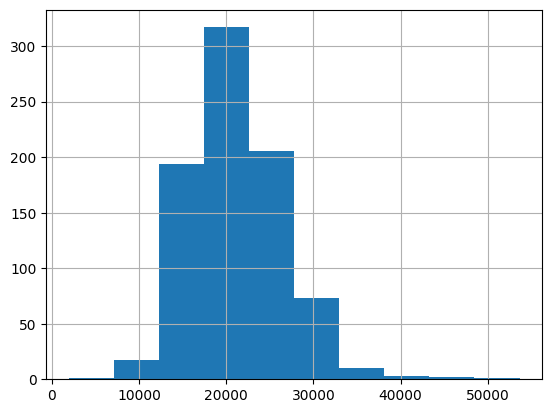

In [267]:
Profile.avg_month_spent.hist()

In [268]:
Profile.avg_month_spent.median()

20367.8259503452

In [269]:
Q1 = Profile['avg_month_spent'].quantile(0.25)
Q3 = Profile['avg_month_spent'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['avg_month_spent'] < (Q1 - 1.5 * IQR) ) | (Profile['avg_month_spent'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
137,138.0,101.737864,867.000000,674.525485,13.054945,7503.680875,77781.200524,58.000000,91.000000,506520.874950,8.495615,4.431989,44310.751169,34094.434080,3.044303,3.102594e+06
191,192.0,101.737864,548.356796,674.525485,9.985629,7503.680875,77781.200524,89.726027,90.000000,506520.874950,8.614114,4.292763,46269.615343,56990.095780,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,9.985629,7503.680875,77781.200524,99.000000,79.000000,506520.874950,8.330002,4.271943,53637.661391,57531.614949,4.035009,4.544998e+06
299,300.0,163.000000,548.356796,674.525485,11.276786,8765.467918,150104.532084,5.000000,67.190534,506520.874950,8.532138,4.295224,37758.938723,21238.007428,2.422918,2.378657e+06
321,322.0,218.000000,802.000000,991.000000,9.985629,10466.471487,77781.200524,4.800000,68.000000,711720.061095,8.319381,4.213464,37458.950584,24510.728776,2.341833,1.666730e+06
473,474.0,101.737864,766.000000,994.000000,9.985629,7503.680875,142287.002410,149.000000,62.000000,742152.991351,8.175839,4.265364,39060.683755,27743.640861,2.317724,1.720106e+06
523,524.0,101.737864,520.000000,855.000000,13.790323,7503.680875,77781.200524,10.000000,62.000000,789617.424123,8.134617,4.524700,37600.829720,50649.213294,3.976927,3.140251e+06
564,565.0,101.737864,548.356796,674.525485,9.985629,10610.630988,77781.200524,20.000000,67.190534,506520.874950,8.841956,4.335270,39881.337162,25407.782909,2.394559,2.769448e+06
583,584.0,101.737864,809.000000,674.525485,13.011236,7503.680875,77781.200524,99.000000,89.000000,506520.874950,8.079559,4.218480,38558.918627,44699.648118,3.968222,3.978269e+06
707,708.0,101.737864,547.000000,775.000000,13.135593,7503.680875,77781.200524,77.000000,59.000000,715308.382741,7.987923,4.432537,37647.809618,38640.946220,3.187179,2.279816e+06


In [270]:
Profile.loc[quantile_out.index, 'avg_month_spent'] = Profile.avg_month_spent.mean()

## Standard Deviation Total Amount

In [271]:
Q1 = Profile['stdAmount_BSKT'].quantile(0.25)
Q3 = Profile['stdAmount_BSKT'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['stdAmount_BSKT'] < (Q1 - 1.5 * IQR) ) | (Profile['stdAmount_BSKT'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out

,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
10,11.0,101.737864,546.000000,809.000000,12.446154,10305.623172,77781.200524,10.000000,65.000000,669865.506152,7.836945,4.345932,26794.620246,37465.615919,3.635454,2.435265e+06
43,44.0,162.000000,560.000000,708.000000,11.606557,9498.787752,77781.200524,69.000000,61.000000,579426.052842,7.794417,4.145786,26337.547856,23609.976766,2.485578,1.440209e+06
87,88.0,158.000000,689.000000,907.000000,12.093333,9843.669979,77781.200524,99.000000,75.000000,738275.248457,7.994696,4.286297,28395.201864,25906.996849,2.631843,1.943025e+06
137,138.0,101.737864,867.000000,674.525485,13.054945,7503.680875,77781.200524,58.000000,91.000000,506520.874950,8.495615,4.431989,21110.748971,34094.434080,3.044303,3.102594e+06
175,176.0,101.737864,708.000000,933.000000,11.378049,9354.984909,77781.200524,28.000000,82.000000,767108.762515,7.982909,4.207421,29504.183174,29128.971923,3.113738,2.388576e+06
177,178.0,171.000000,509.000000,634.000000,9.188406,7850.771734,77781.200524,20.000000,69.000000,541703.249649,7.654076,4.368122,22570.968735,23446.559230,2.986529,1.617813e+06
191,192.0,101.737864,548.356796,674.525485,9.985629,7503.680875,77781.200524,89.726027,90.000000,506520.874950,8.614114,4.292763,21110.748971,56990.095780,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,9.985629,7503.680875,77781.200524,99.000000,79.000000,506520.874950,8.330002,4.271943,21110.748971,57531.614949,4.035009,4.544998e+06
241,242.0,174.000000,541.000000,731.000000,10.295775,8718.740651,77781.200524,149.000000,71.000000,619030.586244,7.923345,4.304129,26914.373315,27757.821389,3.183696,1.970805e+06
254,255.0,101.737864,750.000000,1033.000000,11.228261,9612.842031,77781.200524,58.000000,92.000000,506520.874950,8.290618,4.276018,31585.052388,26882.521128,2.796522,2.473192e+06


In [272]:
Profile.loc[quantile_out.index, 'stdAmount_BSKT'] = Profile.stdAmount_BSKT.mean()

## Functions

<AxesSubplot:>

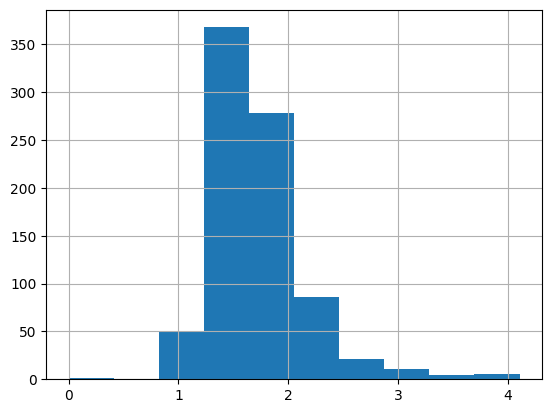

In [273]:
Profile.stdMean_ratio.hist()

In [274]:
Q1 = Profile['stdMean_ratio'].quantile(0.25)
Q3 = Profile['stdMean_ratio'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['stdMean_ratio'] < (Q1 - 1.5 * IQR) ) | (Profile['stdMean_ratio'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out

,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
10,11.0,101.737864,546.000000,809.000000,12.446154,10305.623172,77781.200524,10.000000,65.000000,669865.506152,7.836945,4.345932,26794.620246,13226.387687,3.635454,2.435265e+06
87,88.0,158.000000,689.000000,907.000000,12.093333,9843.669979,77781.200524,99.000000,75.000000,738275.248457,7.994696,4.286297,28395.201864,13226.387687,2.631843,1.943025e+06
137,138.0,101.737864,867.000000,674.525485,13.054945,7503.680875,77781.200524,58.000000,91.000000,506520.874950,8.495615,4.431989,21110.748971,13226.387687,3.044303,3.102594e+06
175,176.0,101.737864,708.000000,933.000000,11.378049,9354.984909,77781.200524,28.000000,82.000000,767108.762515,7.982909,4.207421,29504.183174,13226.387687,3.113738,2.388576e+06
177,178.0,171.000000,509.000000,634.000000,9.188406,7850.771734,77781.200524,20.000000,69.000000,541703.249649,7.654076,4.368122,22570.968735,13226.387687,2.986529,1.617813e+06
178,179.0,101.737864,660.000000,802.000000,11.794118,8238.774282,77781.200524,139.000000,68.000000,560236.651207,8.054316,4.229517,24358.115270,21459.411571,2.604685,1.459240e+06
191,192.0,101.737864,548.356796,674.525485,9.985629,7503.680875,77781.200524,89.726027,90.000000,506520.874950,8.614114,4.292763,21110.748971,13226.387687,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,9.985629,7503.680875,77781.200524,99.000000,79.000000,506520.874950,8.330002,4.271943,21110.748971,13226.387687,4.035009,4.544998e+06
226,227.0,212.000000,504.000000,617.000000,11.865385,8471.457013,150717.550670,25.000000,52.000000,440515.764657,7.616133,4.005267,19152.859333,21814.016978,2.575002,1.134329e+06
241,242.0,174.000000,541.000000,731.000000,10.295775,8718.740651,77781.200524,149.000000,71.000000,619030.586244,7.923345,4.304129,26914.373315,13226.387687,3.183696,1.970805e+06


<AxesSubplot:>

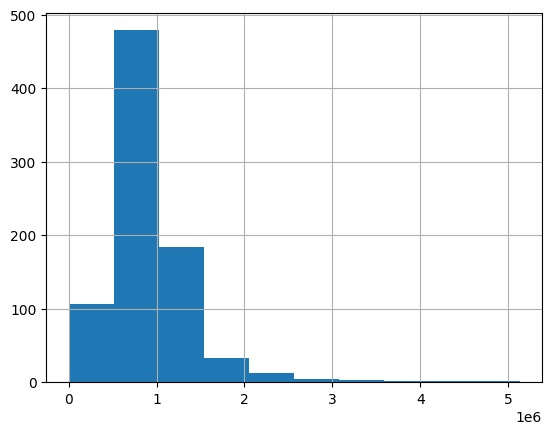

In [275]:
Profile.totalAmount_factor.hist()

In [276]:
Q1 = Profile['totalAmount_factor'].quantile(0.25)
Q3 = Profile['totalAmount_factor'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['totalAmount_factor'] < (Q1 - 1.5 * IQR) ) | (Profile['totalAmount_factor'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out

,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
10,11.0,101.737864,546.000000,809.000000,12.446154,10305.623172,77781.200524,10.000000,65.000000,669865.506152,7.836945,4.345932,26794.620246,13226.387687,3.635454,2.435265e+06
87,88.0,158.000000,689.000000,907.000000,12.093333,9843.669979,77781.200524,99.000000,75.000000,738275.248457,7.994696,4.286297,28395.201864,13226.387687,2.631843,1.943025e+06
137,138.0,101.737864,867.000000,674.525485,13.054945,7503.680875,77781.200524,58.000000,91.000000,506520.874950,8.495615,4.431989,21110.748971,13226.387687,3.044303,3.102594e+06
165,166.0,119.000000,868.000000,1075.000000,10.858586,7737.234110,125019.199873,28.000000,99.000000,765986.176889,8.359151,4.198692,30639.447076,18632.799956,2.408199,1.844647e+06
175,176.0,101.737864,708.000000,933.000000,11.378049,9354.984909,77781.200524,28.000000,82.000000,767108.762515,7.982909,4.207421,29504.183174,13226.387687,3.113738,2.388576e+06
191,192.0,101.737864,548.356796,674.525485,9.985629,7503.680875,77781.200524,89.726027,90.000000,506520.874950,8.614114,4.292763,21110.748971,13226.387687,4.105653,5.129109e+06
207,208.0,101.737864,865.000000,674.525485,9.985629,7503.680875,77781.200524,99.000000,79.000000,506520.874950,8.330002,4.271943,21110.748971,13226.387687,4.035009,4.544998e+06
241,242.0,174.000000,541.000000,731.000000,10.295775,8718.740651,77781.200524,149.000000,71.000000,619030.586244,7.923345,4.304129,26914.373315,13226.387687,3.183696,1.970805e+06
254,255.0,101.737864,750.000000,1033.000000,11.228261,9612.842031,77781.200524,58.000000,92.000000,506520.874950,8.290618,4.276018,31585.052388,13226.387687,2.796522,2.473192e+06
283,284.0,224.000000,900.000000,674.525485,11.316832,8776.073183,146444.702747,15.000000,67.190534,506520.874950,8.455449,4.351175,32829.014498,20356.375122,2.319531,2.055994e+06


In [277]:
Profile.loc[quantile_out.index, 'totalAmount_factor'] = Profile.totalAmount_factor.mean()

## Entropy Item_Id

In [278]:
Q1 = Profile['entropy_itemID'].quantile(0.25)
Q3 = Profile['entropy_itemID'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['entropy_itemID'] < (Q1 - 1.5 * IQR) ) | (Profile['entropy_itemID'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out


,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
151,152.0,32.000000,216.000000,255.000000,5.795455,4214.479953,26451.355300,58.000000,44.000000,185437.117927,6.627148,3.934142,8428.959906,5623.579110,1.334347,247437.480832
354,355.0,47.000000,305.000000,344.000000,7.166667,5609.612460,45375.842238,148.000000,48.000000,269261.398101,6.874397,3.986663,13463.069905,7774.406021,1.385908,373171.489001
355,356.0,32.000000,285.000000,324.000000,7.363636,5728.886688,42216.332571,149.000000,44.000000,252071.014274,6.957687,4.038509,13266.895488,7312.360142,1.276402,321743.846268
389,390.0,44.000000,258.000000,298.000000,6.772727,5131.932860,27902.875000,99.000000,44.000000,225805.045850,6.906956,4.036576,11884.476097,6843.530832,1.333519,301115.356594
499,500.0,40.000000,290.000000,332.000000,6.509804,4441.274736,30463.873373,149.000000,51.000000,226505.011536,6.899273,3.811517,9848.043980,6657.019132,1.498898,339507.975713
502,503.0,89.000000,338.000000,407.000000,11.000000,8086.242994,66456.277850,99.000000,37.000000,299190.990781,6.901386,4.059988,15746.894252,13301.672702,1.644976,492161.889979
564,565.0,101.737864,548.356796,674.525485,9.985629,10610.630988,77781.200524,20.000000,67.190534,506520.874950,8.841956,4.335270,21110.748971,13226.387687,2.394559,904859.371725
570,571.0,216.000000,548.356796,674.525485,9.985629,10310.607600,138488.698557,69.000000,87.000000,506520.874950,8.700711,4.179069,30931.822800,22691.616879,2.200803,904859.371725
692,693.0,27.000000,269.000000,318.000000,5.888889,5126.217377,33218.141667,199.000000,54.000000,276815.738340,6.700432,4.248217,13181.701826,6922.439515,1.350399,373811.733802
779,780.0,27.000000,548.356796,201.000000,5.911765,5950.564663,29719.500000,15.000000,67.190534,202319.198525,6.365422,4.271758,12644.949908,8010.743666,1.346216,272365.284656


In [279]:
Profile.loc[quantile_out.index, 'entropy_itemID'] = Profile.entropy_itemID.mean()

## Entropy Category

In [280]:
Q1 = Profile['entropy_CategoryID'].quantile(0.25)
Q3 = Profile['entropy_CategoryID'].quantile(0.75)
IQR = Q3 - Q1

quantile_out = Profile.loc[ ( (Profile['entropy_CategoryID'] < (Q1 - 1.5 * IQR) ) | (Profile['entropy_CategoryID'] > (Q3 + 1.5 * IQR)  ) )] 
quantile_out

,user_id,Imax,Iu,I,IAvg,meanAmount_BSKT,maxAmount_BSKT,minAmount_BSKT,unique_baskets,totalAmount,entropy_itemID,entropy_CategoryID,avg_month_spent,stdAmount_BSKT,stdMean_ratio,totalAmount_factor
41,42.0,46.000000,417.000000,473.000000,7.883333,4880.339657,26145.000000,3.000000,60.000000,292820.379417,7.689594,3.835984,16267.798857,6238.723051,1.278338,374323.383040
190,191.0,69.000000,470.000000,594.000000,9.737705,7176.904855,48137.465530,28.000000,61.000000,437791.196173,7.619548,3.870486,23041.641904,10776.940735,1.501614,657393.384821
218,219.0,73.000000,324.000000,380.000000,8.444444,5487.490096,40653.198949,1.830000,45.000000,246937.054327,7.199002,3.828911,12346.852716,8381.853476,1.527448,377183.406427
307,308.0,37.000000,412.000000,495.000000,9.166667,6080.353826,26447.856768,77.000000,54.000000,328339.106611,7.220858,3.798543,13133.564264,6442.384877,1.059541,347888.783332
463,464.0,55.000000,510.000000,604.000000,8.882353,5918.957413,36294.322826,5.000000,68.000000,402489.104094,7.588108,3.833604,15480.350157,8066.383115,1.362805,548514.051831
499,500.0,40.000000,290.000000,332.000000,6.509804,4441.274736,30463.873373,149.000000,51.000000,226505.011536,7.802594,3.811517,9848.043980,6657.019132,1.498898,339507.975713
523,524.0,101.737864,520.000000,855.000000,13.790323,7503.680875,77781.200524,10.000000,62.000000,789617.424123,8.134617,4.524700,21110.748971,13226.387687,3.976927,904859.371725
551,552.0,93.000000,647.000000,807.000000,10.760000,7262.742517,68565.333404,30.000000,75.000000,544705.688791,7.736342,3.885784,19453.774600,12560.655694,1.729465,942049.177051
693,694.0,50.000000,388.000000,476.000000,8.654545,5474.704938,24602.398942,6.000000,55.000000,301108.771587,7.539570,3.853177,11581.106599,6389.880504,1.167164,351443.427740
823,824.0,5.000000,548.356796,674.525485,9.985629,7503.680875,1935.000000,68.810689,67.190534,506520.874950,7.802594,1.370951,21110.748971,13226.387687,0.000517,1.000000


In [281]:
Profile.loc[quantile_out.index, 'entropy_CategoryID'] = Profile.entropy_CategoryID.mean()

# h) Indicators analysis after outliers

array([[<AxesSubplot:title={'center':'Imax'}>,
        <AxesSubplot:title={'center':'Iu'}>,
        <AxesSubplot:title={'center':'I'}>,
        <AxesSubplot:title={'center':'IAvg'}>],
       [<AxesSubplot:title={'center':'meanAmount_BSKT'}>,
        <AxesSubplot:title={'center':'maxAmount_BSKT'}>,
        <AxesSubplot:title={'center':'minAmount_BSKT'}>,
        <AxesSubplot:title={'center':'unique_baskets'}>],
       [<AxesSubplot:title={'center':'totalAmount'}>,
        <AxesSubplot:title={'center':'entropy_itemID'}>,
        <AxesSubplot:title={'center':'entropy_CategoryID'}>,
        <AxesSubplot:title={'center':'avg_month_spent'}>],
       [<AxesSubplot:title={'center':'stdAmount_BSKT'}>,
        <AxesSubplot:title={'center':'stdMean_ratio'}>,
        <AxesSubplot:title={'center':'totalAmount_factor'}>,
        <AxesSubplot:>]], dtype=object)

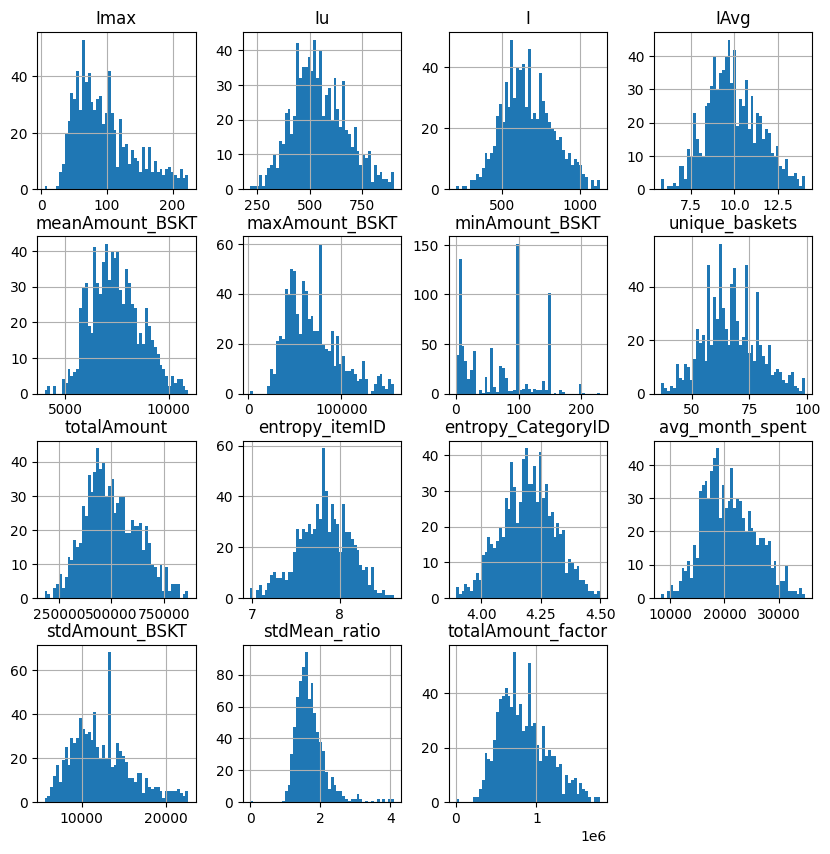

In [282]:
Profile.drop(columns=['user_id']).hist(bins=50, figsize=(10,10))

In [283]:
pd.plotting.scatter_matrix(Profile.drop(columns=['user_id']), alpha=0.2,figsize=(15, 15))
plt.show()

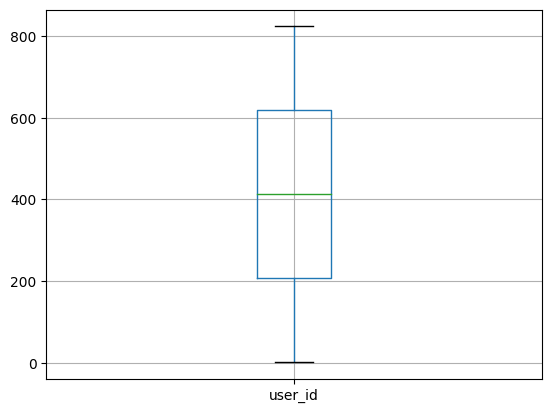

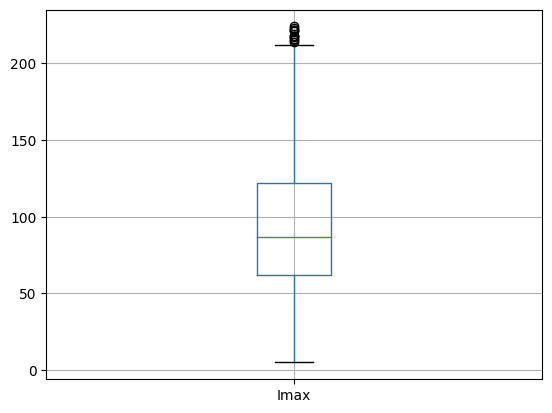

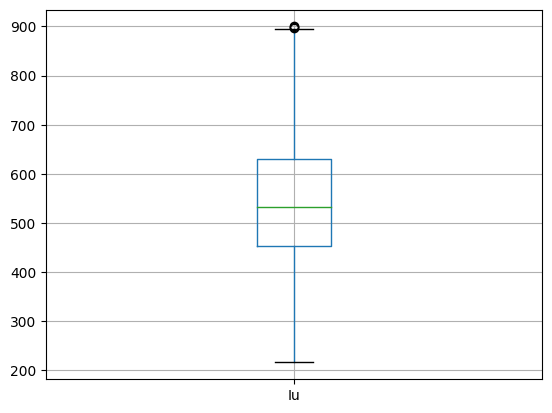

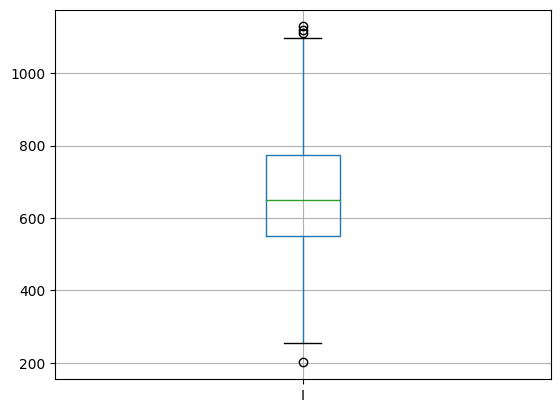

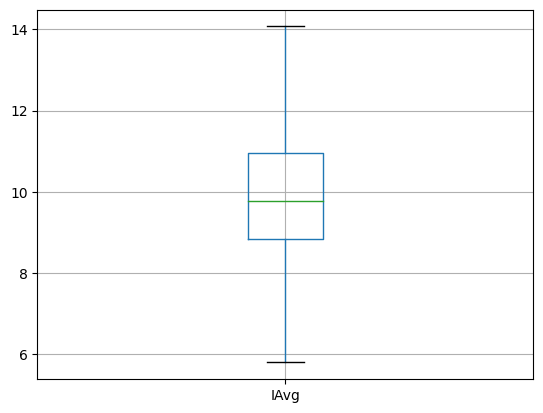

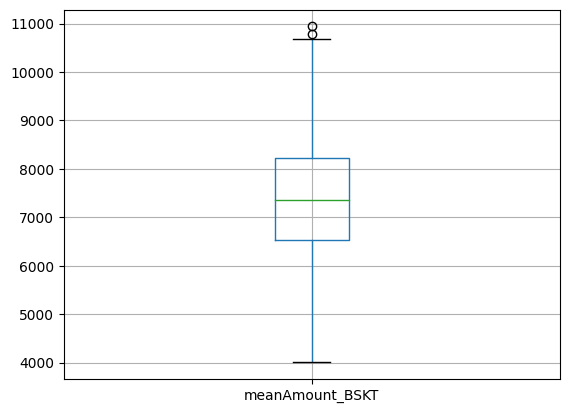

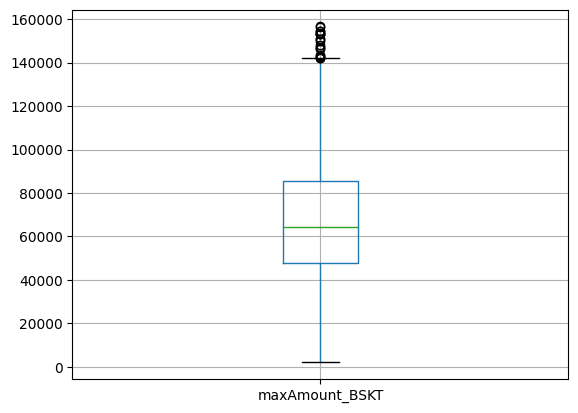

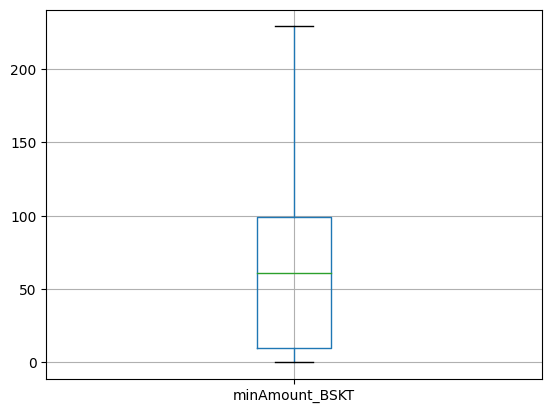

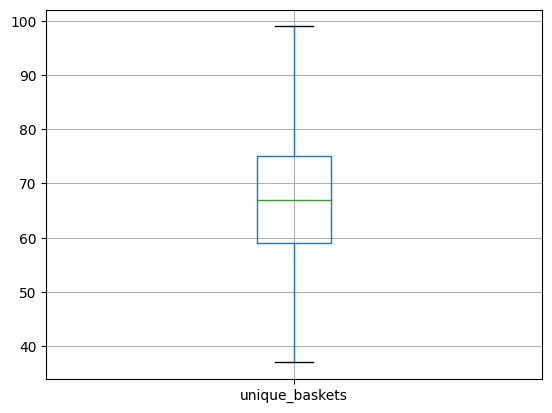

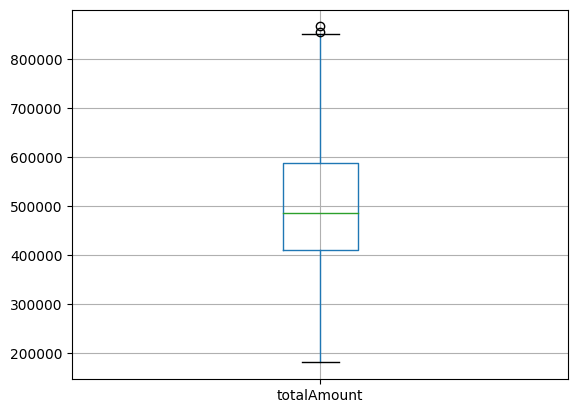

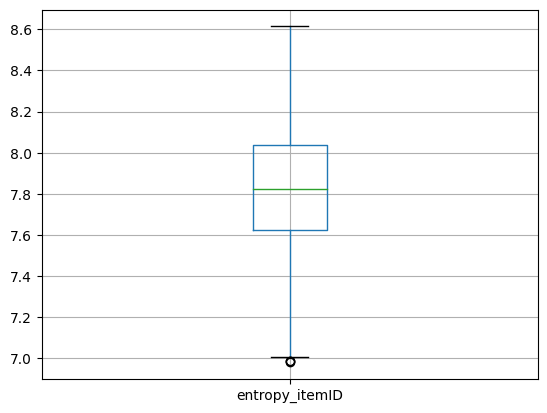

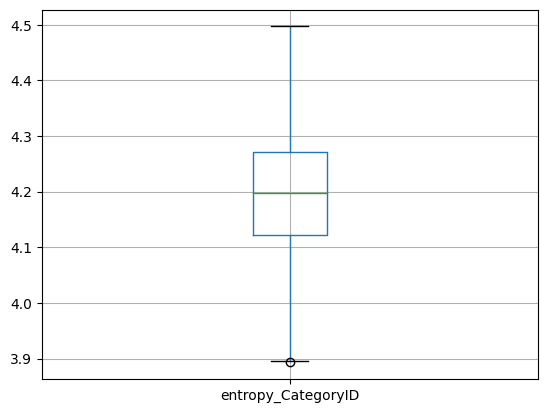

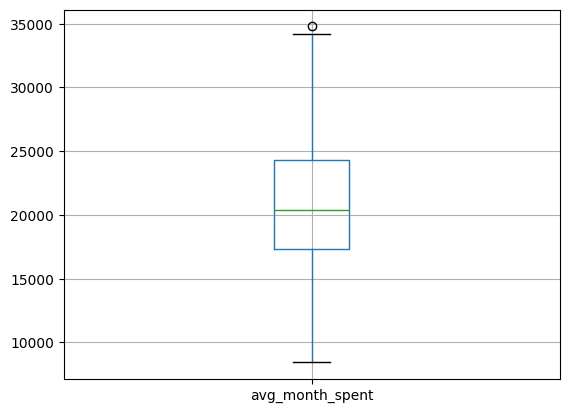

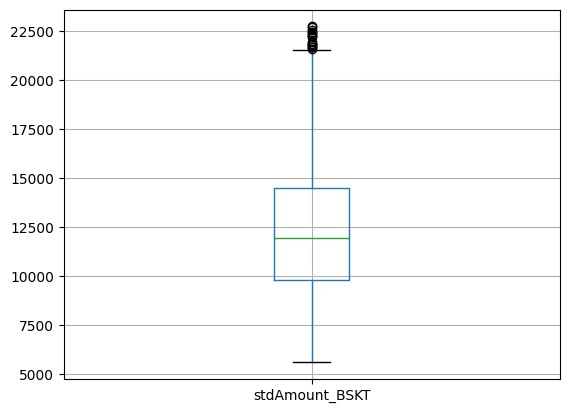

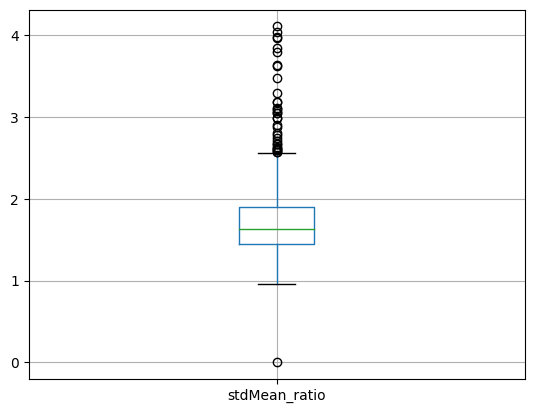

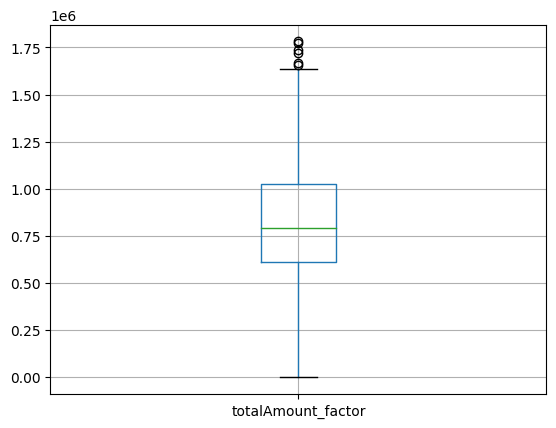

In [284]:
import matplotlib.pyplot as plt

for column in Profile:
    plt.figure()
    Profile.boxplot([column])

<AxesSubplot:xlabel='totalAmount', ylabel='maxAmount_BSKT'>

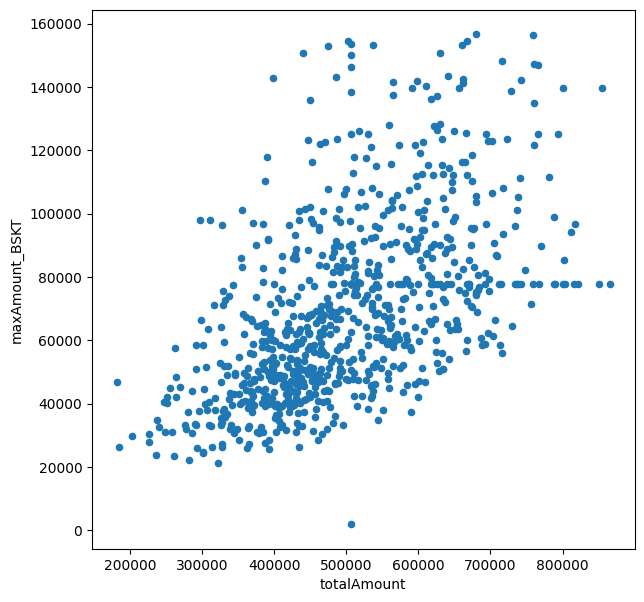

In [285]:
Profile.plot.scatter(x='totalAmount',y='maxAmount_BSKT', figsize = (7, 7))

<AxesSubplot:xlabel='meanAmount_BSKT', ylabel='maxAmount_BSKT'>

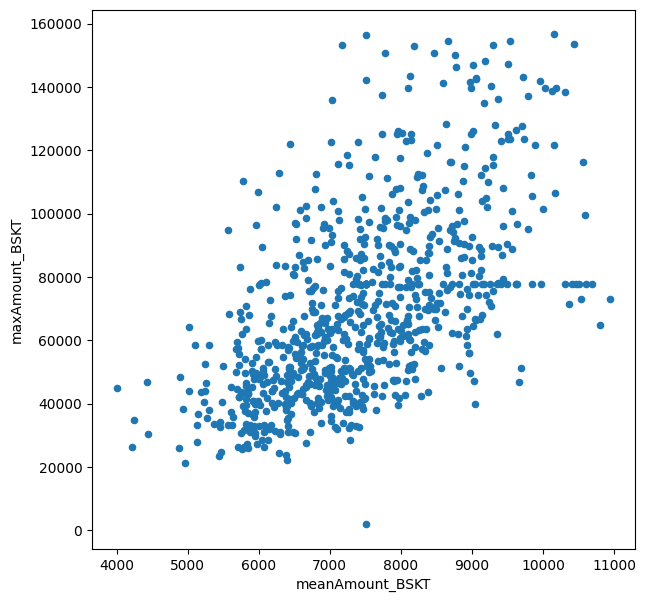

In [286]:
Profile.plot.scatter(x='meanAmount_BSKT',y='maxAmount_BSKT', figsize = (7, 7))

<AxesSubplot:xlabel='Iu', ylabel='I'>

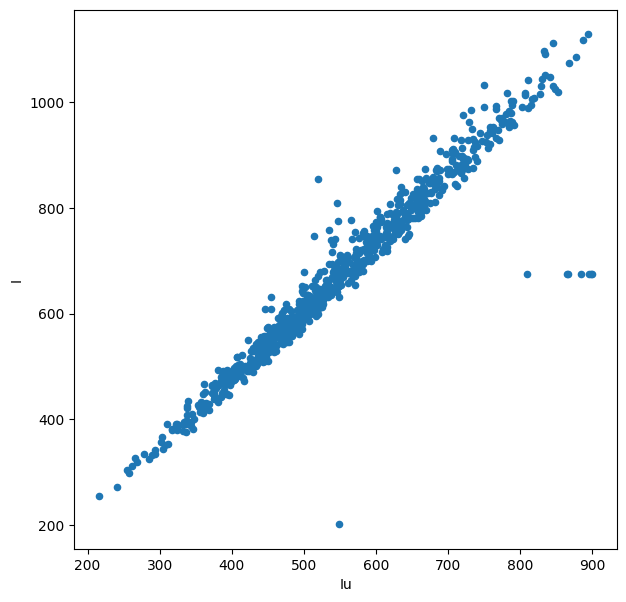

In [287]:
Profile.plot.scatter(x='Iu',y='I', figsize = (7, 7))

<AxesSubplot:xlabel='Iu', ylabel='unique_baskets'>

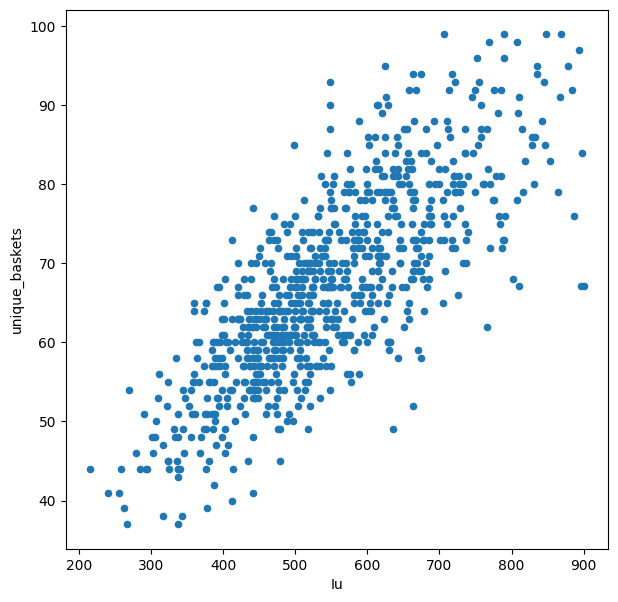

In [288]:
Profile.plot.scatter(x='Iu',y='unique_baskets', figsize = (7, 7))

<AxesSubplot:xlabel='I', ylabel='unique_baskets'>

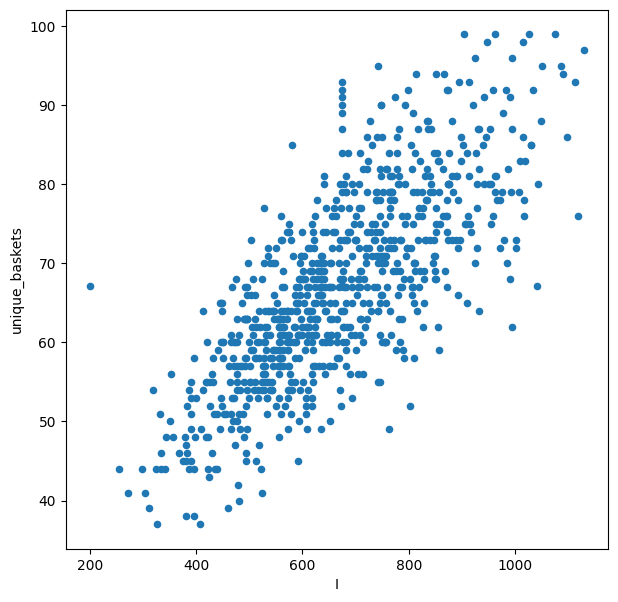

In [289]:
Profile.plot.scatter(x='I',y='unique_baskets', figsize = (7, 7))

<AxesSubplot:xlabel='totalAmount', ylabel='unique_baskets'>

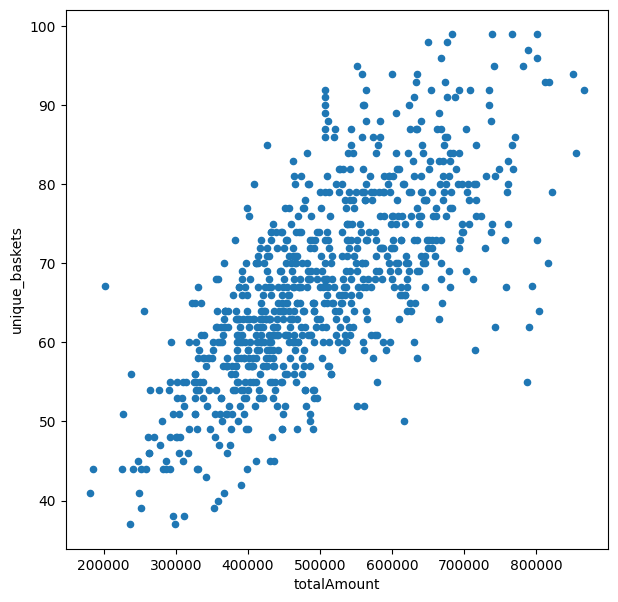

In [290]:
Profile.plot.scatter(x='totalAmount',y='unique_baskets', figsize = (7, 7))

<AxesSubplot:xlabel='meanAmount_BSKT', ylabel='unique_baskets'>

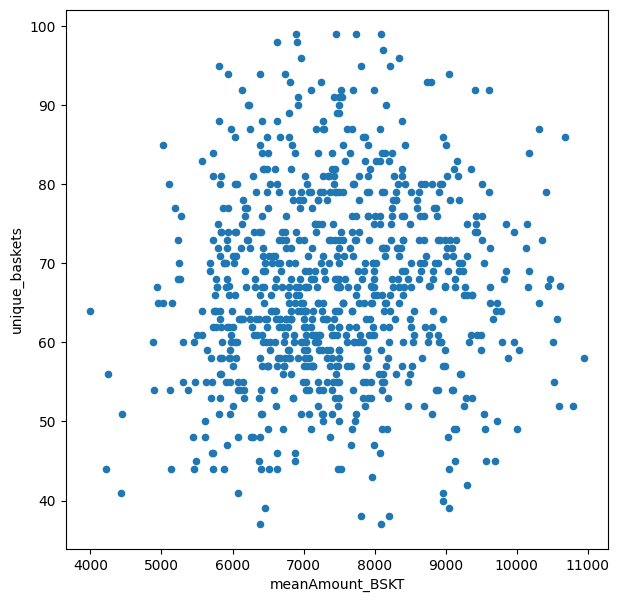

In [291]:
Profile.plot.scatter(x='meanAmount_BSKT',y='unique_baskets', figsize = (7, 7))

<AxesSubplot:xlabel='totalAmount', ylabel='meanAmount_BSKT'>

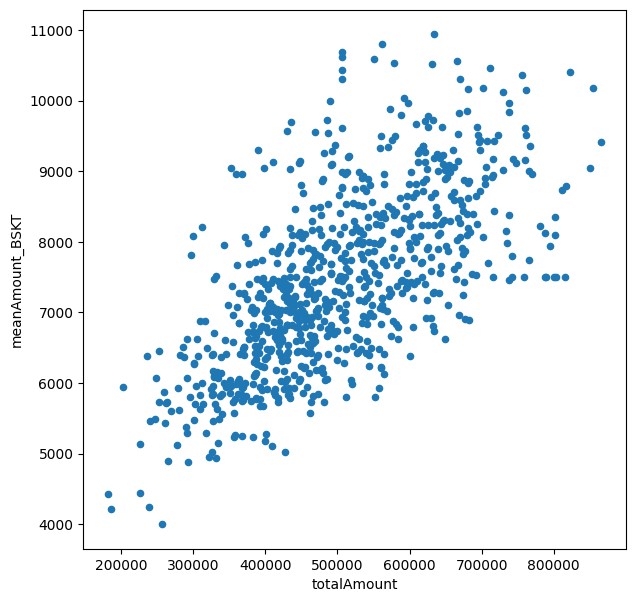

In [292]:
Profile.plot.scatter(x='totalAmount',y='meanAmount_BSKT', figsize = (7, 7))

In [293]:
Profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 0 to 823
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             824 non-null    float64
 1   Imax                824 non-null    float64
 2   Iu                  824 non-null    float64
 3   I                   824 non-null    float64
 4   IAvg                824 non-null    float64
 5   meanAmount_BSKT     824 non-null    float64
 6   maxAmount_BSKT      824 non-null    float64
 7   minAmount_BSKT      824 non-null    float64
 8   unique_baskets      824 non-null    float64
 9   totalAmount         824 non-null    float64
 10  entropy_itemID      824 non-null    float64
 11  entropy_CategoryID  824 non-null    float64
 12  avg_month_spent     824 non-null    float64
 13  stdAmount_BSKT      824 non-null    float64
 14  stdMean_ratio       824 non-null    float64
 15  totalAmount_factor  824 non-null    float64
dtypes: float

#Final users' profile

In [294]:
#scenario where we drop gifts
#Profile.to_csv('../Dataset/UserProfileNOGIFT.csv')

In [295]:
Profile.to_csv('../Dataset/UserProfile.csv')